In [26]:
import sys
sys.path.append(str('/home/jupyter/'))
from configparser import ConfigParser

from repo.MyConfigParser import MyConfigParser

from repo.LoadData import DataLoader
from repo.BuildModel import GenerateModelFile, CreateModel
from repo.Accuracy import AccuracyCalculator, ProphetParameterSearch, PlotAccuracyCharts
from repo.FileGenerator import *

In [27]:
updated_config = ConfigParser()
config_in_path = "/home/jupyter/CA/24 Feb Update/config ups ca.ini"
updated_config.read(config_in_path)

getdict = MyConfigParser()
config_dict=getdict.GetDict(updated_config)

region = config_dict['CLIENTINFO']['country']
cutoff_month = config_dict['PROPHETSETTING']['cut_off_point']
base_start = config_dict['PROPHETSETTING']['reference_start_date1']
base_end = config_dict['PROPHETSETTING']['reference_end_date1']
periods = config_dict['PROPHETSETTING']['periods']
base_periods  = config_dict['PROPHETSETTING']['base_periods']

training_query = config_dict["PROPHETSETTING"]["training_query"]
_input = config_dict["PROPHETSETTING"]["input"]
_output = config_dict["PROPHETSETTING"]["output"]

output_bucket = config_dict["FILEPATH"]["output_bucket"]
folder_name = config_dict["FILEPATH"]["folder_name"]


today = datetime.date.today().strftime("%m.%d.%Y") #'03.10.2023' #
print(today)
base_path = config_dict["FILEPATH"]["base_path"]

boundary_df_in_path = base_path + config_dict["FILEPATH"]["boundary_df_in_path"]
daily_df_out_path = base_path + config_dict["FILEPATH"]["daily_df_out_path"]
analytical_file_path = base_path + config_dict["FILEPATH"]["analytical_file_path"]
cuts_df_in_path = base_path + config_dict["FILEPATH"]["cuts_df_in_path"]
plot_name = base_path + config_dict["FILEPATH"]["plot_name"]
constraint_file_name = base_path + config_dict["FILEPATH"]["constraint_file_name"]

02.05.2024


In [28]:
# today = datetime.date.today().strftime("%m.%d.%Y") #'03.10.2023' #
# print(today)
# base_path = '/home/jupyter/CA/24 Feb Update/'

# config_in_path = base_path + "config ups ca reg.ini"

# boundary_df_in_path = base_path + 'Floor Cap Setting 2023 Global.csv'
# daily_df_out_path = base_path + f'Daily Data {today}.csv'
# analytical_file_path = base_path + 'Analytical_File_NY'+ '.csv'
# cuts_df_in_path = base_path + region + ' Breakdown (1).csv'
# # constraint_file_out_path = base_path + 'Constraint File Modified Nov.csv'
# plot_name = base_path + "Accuracy_By_Month.jpg"
# constraint_file_name = "Constraint File.csv"

In [29]:
daily_df = GetBQData(config_dict["PROPHETSETTING"]["training_query"], config_dict["PROPHETSETTING"]["input"], config_dict["PROPHETSETTING"]["output"])

df = daily_df.copy()
df = df.groupby(['region', 'market', 'account_type', 'funnel', 'ds']).sum().reset_index()

# log Transformation
# df['cost'] = np.log(df['cost'])
# df.loc[(df['cost'] < 0) | (np.isinf(df['cost'])), 'cost'] = 0

df.ds = pd.to_datetime(df.ds)
df = df[~df[['ds', 'y']].isin([np.nan, np.inf, -np.inf]).any(axis=1)]

# df = df[df.ds < cut_off_month]
# remove inactive days
df.drop(df[((df['ds'] >= '2021-08-01')&(df['ds'] <= '2021-10-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Brand'))].index,
       axis = 0, inplace = True)
df.drop(df[((df['ds'] >= '2019-03-01')&(df['ds'] <= '2019-08-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Brand'))].index,
       axis = 0, inplace = True)

df.drop(df[((df['ds'] >= '2021-07-01')&(df['ds'] <= '2021-10-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Generic'))].index,
       axis = 0, inplace = True)

# add regressors
df['anomaly_2021'] = df['ds'].apply(lambda x: 1 if (x >= datetime.datetime(2021,8,1))\
                                     & (x <= datetime.datetime(2021,10,31)) else 0)
df['covid_year_dummy'] = 0
df.loc[(df['ds'] >= '2020-01-01') & (df['ds'] <= '2020-12-31'), 'Covid_Year_Dummy'] = 1

df['weekday_or_weekend'] = df['ds'].apply(lambda x: 1 if x.dayofweek > 4 else 0)

# set cap and floor for log regression
df['Month of Ds'] = df['ds'].dt.month_name()

df.tail()

,region,market,account_type,funnel,ds,X,y,anomaly_2021,covid_year_dummy,Covid_Year_Dummy,weekday_or_weekend,Month of Ds
12592,Canada,Canada,Google AdWords,Generic,2024-01-31,27.19,14.0,0,0,NaN,0,January
12593,Canada,Canada,Google AdWords,Generic,2024-02-01,48.12,11.0,0,0,NaN,0,February
12594,Canada,Canada,Google AdWords,Generic,2024-02-02,49.12,14.0,0,0,NaN,0,February
12595,Canada,Canada,Google AdWords,Generic,2024-02-03,47.95,2.0,0,0,NaN,1,February
12596,Canada,Canada,Google AdWords,Generic,2024-02-04,44.63,0.0,0,0,NaN,1,February


In [30]:
updated_df = Combine(df, 'L')
updated_df.head()

,ds,region,market,account_type,funnel,Identifier,X,y,anomaly_2021,covid_year_dummy,Covid_Year_Dummy,weekday_or_weekend,Month of Ds,new_funnel,generic_cost,competitor_cost,generic_cost_split,competitor_cost_split,Weekend
0,2017-08-10,Canada,Canada,-,Brand,L,1241.550012,555.0,0.0,0.0,0.0,0.0,August,NaN,0.000000,0.0,0.5,0.5,0
1,2017-08-10,Canada,Canada,-,Non_Brand,L,284.660000,1.0,0.0,0.0,0.0,0.0,August,NaN,284.660000,0.0,1.0,0.0,0
2,2017-08-11,Canada,Canada,-,Brand,L,995.119990,442.0,0.0,0.0,0.0,0.0,August,NaN,0.000000,0.0,0.5,0.5,0
3,2017-08-11,Canada,Canada,-,Non_Brand,L,261.089998,1.0,0.0,0.0,0.0,0.0,August,NaN,261.089998,0.0,1.0,0.0,0
4,2017-08-12,Canada,Canada,-,Brand,L,0.000000,12.0,0.0,0.0,0.0,1.0,August,NaN,0.000000,0.0,0.5,0.5,1


In [31]:
covid_df = GetCovidData('Canada')
covid_df.tail()

,ds,market,new_confirmed
986,2022-09-13,Canada,0
987,2022-09-14,Canada,0
988,2022-09-15,Canada,0
989,2022-09-16,Canada,0
990,2022-09-17,Canada,0


In [32]:
final_df = updated_df.merge(covid_df, how = 'left', on = ['ds', 'market'])
final_df = final_df.fillna(0)


final_df['floor'] = 0

boundary_df = pd.read_csv(boundary_df_in_path)
boundary_df.rename(columns = {'Market': 'market', 'Account Type': 'account_type', 'Funnel':'funnel'}, inplace = True)

final_df = pd.merge(final_df, boundary_df, on = ['market', 'account_type', 'funnel'])
final_df['cap'] = final_df.ROAS * final_df.X / final_df.AOV
final_df.loc[final_df.cap == 0, 'cap'] = final_df.cap.max()
final_df = final_df[final_df.ds < cutoff_month].copy()
final_df.to_csv(daily_df_out_path)
final_df.tail()

,ds,region,market,account_type,funnel,Identifier,X,y,anomaly_2021,covid_year_dummy,...,generic_cost,competitor_cost,generic_cost_split,competitor_cost_split,Weekend,new_confirmed,floor,AOV,ROAS,cap
4700,2023-12-27,Canada,Canada,-,Non_Brand,L,1080.4030,168.0,0.0,0.0,...,889.8330,190.57,0.823612,0.176388,0,0,0,43.89,7.12,175.267017
4701,2023-12-28,Canada,Canada,-,Non_Brand,L,838.5643,130.0,0.0,0.0,...,681.8643,156.70,0.810000,0.190000,0,0,0,43.89,7.12,136.035038
4702,2023-12-29,Canada,Canada,-,Non_Brand,L,1034.5693,136.0,0.0,0.0,...,887.3493,147.22,0.857699,0.142301,0,0,0,43.89,7.12,167.831702
4703,2023-12-30,Canada,Canada,-,Non_Brand,L,694.6749,15.0,0.0,0.0,...,631.6349,63.04,0.909253,0.090747,1,0,0,43.89,7.12,112.692761
4704,2023-12-31,Canada,Canada,-,Non_Brand,L,640.8225,10.0,0.0,0.0,...,596.2025,44.62,0.930371,0.069629,1,0,0,43.89,7.12,103.956623


# Analytical File Generator

In [33]:
analytical_input = GetBQData(config_dict["PROPHETSETTING"]["analytical_file_query"], config_dict["PROPHETSETTING"]["input"], config_dict["PROPHETSETTING"]["output"])
analytical_input = Combine(analytical_input, 'L')
generator = AnalyticalFileGenerator(config_dict, analytical_input)
analytical_file_df = generator.generate()
analytical_file_df = pd.merge(analytical_file_df, boundary_df, on = ['market', 'account_type', 'funnel'])
# generator.SaveFile(analytical_file_name, folder_name) # X is input value which should be the sum of all variable splits
analytical_file_df.to_csv(analytical_file_path)

In [34]:
cuts_df = pd.read_csv(cuts_df_in_path)
cuts_df['periods'] = periods
cuts_df['periods_for_acc_cal'] = 183
cuts_df['cutoff_month'] = cutoff_month

query_item_list = [query_item for query_item in [config_dict["CLIENTINFO"]["breakdown1"], \
                             config_dict["CLIENTINFO"]["breakdown2"], \
                             config_dict["CLIENTINFO"]["breakdown3"], \
                             config_dict["CLIENTINFO"]["breakdown4"]]
                             if query_item != None]

cuts_df

,market,account_type,funnel,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,input_mode,weekday_or_weekend,include_holiday,...,covid_year_dummy,anomaly_2021,generic_cost_split,competitor_cost_split,new_confirmed,power,growth,periods,periods_for_acc_cal,cutoff_month
0,Canada,-,Brand,0.500,0.01,1,multiplicative,additive,multiplicative,na,...,na,na,na,na,na,na,logistic,366.0,183,2024-01-01
1,Canada,-,Non_Brand,0.001,0.01,10,multiplicative,multiplicative,multiplicative,na,...,na,na,na,na,na,na,linear,366.0,183,2024-01-01


# Parallel Param Search

In [12]:
# %load_ext autoreload
# %autoreload 2
search_engine = ProphetParameterSearch(power_flag = False, base_path=base_path) # , logistic_flag = False
# search_engine.add_power_params()
grid_brand = search_engine.search(cuts_df[cuts_df.funnel == "Non_Brand"], final_df)
# grid

  0%|          | 0/1 [00:00<?, ?it/s]20:39:57 - cmdstanpy - INFO - Chain [1] start processing
20:39:57 - cmdstanpy - INFO - Chain [1] start processing
20:39:57 - cmdstanpy - INFO - Chain [1] start processing
20:39:57 - cmdstanpy - INFO - Chain [1] done processing
20:39:57 - cmdstanpy - INFO - Chain [1] start processing
20:39:57 - cmdstanpy - INFO - Chain [1] done processing
20:39:57 - cmdstanpy - INFO - Chain [1] done processing
20:39:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.04 Period MAE: 37.19
It's overpredicted.
Monthly Error: 59.04 Period MAE: 37.19


20:39:59 - cmdstanpy - INFO - Chain [1] start processing
20:39:59 - cmdstanpy - INFO - Chain [1] start processing
20:39:59 - cmdstanpy - INFO - Chain [1] done processing
20:39:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.04 Period MAE: 37.19


20:40:01 - cmdstanpy - INFO - Chain [1] start processing
20:40:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.75999999999999
It's underpredicted. 
Monthly Error:91.04 Period MAE: 91.75999999999999


20:40:02 - cmdstanpy - INFO - Chain [1] start processing
20:40:02 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

20:40:02 - cmdstanpy - INFO - Chain [1] done processing


 58.45 Period MAE: 36.22

20:40:02 - cmdstanpy - INFO - Chain [1] done processing


20:40:03 - cmdstanpy - INFO - Chain [1] start processing
20:40:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.45 Period MAE: 36.22


20:40:04 - cmdstanpy - INFO - Chain [1] start processing
20:40:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.75999999999999


20:40:05 - cmdstanpy - INFO - Chain [1] start processing
20:40:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.45 Period MAE: 36.22


20:40:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.78


20:40:07 - cmdstanpy - INFO - Chain [1] done processing
20:40:07 - cmdstanpy - INFO - Chain [1] start processing
20:40:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.66 Period MAE: 41.13


20:40:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.78


20:40:09 - cmdstanpy - INFO - Chain [1] start processing
20:40:09 - cmdstanpy - INFO - Chain [1] done processing
20:40:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.66 Period MAE: 41.13
It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.78


20:40:10 - cmdstanpy - INFO - Chain [1] start processing
20:40:10 - cmdstanpy - INFO - Chain [1] start processing
20:40:11 - cmdstanpy - INFO - Chain [1] done processing
20:40:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.It's underpredicted.
Monthly Error: 
91.04 Period MAE:Monthly Error:  62.6691.77 
Period MAE: 41.13


20:40:12 - cmdstanpy - INFO - Chain [1] start processing
20:40:12 - cmdstanpy - INFO - Chain [1] start processing
20:40:12 - cmdstanpy - INFO - Chain [1] done processing
20:40:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:40:14 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 75.86 Period MAE: 48.15


20:40:14 - cmdstanpy - INFO - Chain [1] start processing
20:40:14 - cmdstanpy - INFO - Chain [1] done processing
20:40:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's overpredicted.
Monthly Error: 75.86 Period MAE: 48.15


20:40:15 - cmdstanpy - INFO - Chain [1] start processing
20:40:15 - cmdstanpy - INFO - Chain [1] start processing
20:40:16 - cmdstanpy - INFO - Chain [1] done processing
20:40:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98
It's overpredicted.
Monthly Error: 75.86 Period MAE: 48.15


20:40:17 - cmdstanpy - INFO - Chain [1] start processing
20:40:17 - cmdstanpy - INFO - Chain [1] start processing
20:40:18 - cmdstanpy - INFO - Chain [1] done processing
20:40:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


20:40:19 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.27 Period MAE: 48.49


20:40:19 - cmdstanpy - INFO - Chain [1] done processing
20:40:19 - cmdstanpy - INFO - Chain [1] start processing
20:40:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.27 Period MAE: 48.49
It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


20:40:21 - cmdstanpy - INFO - Chain [1] start processing
20:40:21 - cmdstanpy - INFO - Chain [1] start processing
20:40:21 - cmdstanpy - INFO - Chain [1] done processing
20:40:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.89 Period MAE: 91.88


20:40:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.27 Period MAE: 48.49


20:40:23 - cmdstanpy - INFO - Chain [1] start processing
20:40:23 - cmdstanpy - INFO - Chain [1] done processing
20:40:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.89 Period MAE: 91.88


20:40:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 75.91 Period MAE: 48.1


20:40:25 - cmdstanpy - INFO - Chain [1] start processing
20:40:25 - cmdstanpy - INFO - Chain [1] done processing
20:40:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.89 Period MAE: 91.88
It's overpredicted.
Monthly Error: 75.91 Period MAE: 48.1


20:40:26 - cmdstanpy - INFO - Chain [1] start processing
20:40:26 - cmdstanpy - INFO - Chain [1] start processing
20:40:26 - cmdstanpy - INFO - Chain [1] done processing
20:40:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


20:40:27 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 75.91 Period MAE: 48.1


20:40:28 - cmdstanpy - INFO - Chain [1] start processing
20:40:28 - cmdstanpy - INFO - Chain [1] done processing
20:40:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.04 Period MAE: 37.19
It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


20:40:29 - cmdstanpy - INFO - Chain [1] start processing
20:40:30 - cmdstanpy - INFO - Chain [1] start processing
20:40:30 - cmdstanpy - INFO - Chain [1] done processing
20:40:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99
It's overpredicted.
Monthly Error: 59.04 Period MAE: 37.19


20:40:31 - cmdstanpy - INFO - Chain [1] start processing
20:40:31 - cmdstanpy - INFO - Chain [1] start processing
20:40:31 - cmdstanpy - INFO - Chain [1] done processing
20:40:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.75999999999999
It's overpredicted.
Monthly Error: 59.04 Period MAE: 37.19


20:40:33 - cmdstanpy - INFO - Chain [1] start processing
20:40:33 - cmdstanpy - INFO - Chain [1] start processing
20:40:33 - cmdstanpy - INFO - Chain [1] done processing
20:40:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's overpredicted.
Monthly Error:
 Monthly Error:91.04 57.63  Period MAE: 91.75999999999999
Period MAE: 35.23


20:40:34 - cmdstanpy - INFO - Chain [1] start processing
20:40:34 - cmdstanpy - INFO - Chain [1] start processing
20:40:35 - cmdstanpy - INFO - Chain [1] done processing
20:40:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.63 Period MAE: 35.23
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.75999999999999


20:40:36 - cmdstanpy - INFO - Chain [1] start processing
20:40:36 - cmdstanpy - INFO - Chain [1] start processing
20:40:36 - cmdstanpy - INFO - Chain [1] done processing
20:40:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.63 Period MAE: 35.23
It's underpredicted.
Monthly Error: 

20:40:38 - cmdstanpy - INFO - Chain [1] start processing


91.05 Period MAE: 91.78


20:40:38 - cmdstanpy - INFO - Chain [1] start processing
20:40:38 - cmdstanpy - INFO - Chain [1] done processing
20:40:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.78It's overpredicted.

Monthly Error: 59.41 Period MAE: 38.05


20:40:39 - cmdstanpy - INFO - Chain [1] start processing
20:40:40 - cmdstanpy - INFO - Chain [1] start processing
20:40:40 - cmdstanpy - INFO - Chain [1] done processing
20:40:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.78
It's overpredicted.
Monthly Error: 59.41 Period MAE: 38.05


20:40:41 - cmdstanpy - INFO - Chain [1] start processing
20:40:42 - cmdstanpy - INFO - Chain [1] start processing
20:40:42 - cmdstanpy - INFO - Chain [1] done processing
20:40:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's overpredicted.
Monthly Error: 59.41 Period MAE: 38.05

20:40:44 - cmdstanpy - INFO - Chain [1] start processing


20:40:44 - cmdstanpy - INFO - Chain [1] start processing
20:40:44 - cmdstanpy - INFO - Chain [1] done processing
20:40:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 75.86 Period MAE: 48.15
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:40:46 - cmdstanpy - INFO - Chain [1] start processing
20:40:47 - cmdstanpy - INFO - Chain [1] start processing
20:40:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:40:47 - cmdstanpy - INFO - Chain [1] done processing
20:40:47 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 75.86 Period MAE: 

20:40:48 - cmdstanpy - INFO - Chain [1] done processing


48.15


20:40:48 - cmdstanpy - INFO - Chain [1] start processing
20:40:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 75.86 Period MAE: 48.15


20:40:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


20:40:50 - cmdstanpy - INFO - Chain [1] start processing
20:40:50 - cmdstanpy - INFO - Chain [1] done processing
20:40:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.72 Period MAE: 48.89It's underpredicted.

Monthly Error: 99.97 Period MAE: 99.98


20:40:51 - cmdstanpy - INFO - Chain [1] start processing
20:40:51 - cmdstanpy - INFO - Chain [1] start processing
20:40:52 - cmdstanpy - INFO - Chain [1] done processing
20:40:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98
It's overpredicted.
Monthly Error: 76.72 Period MAE: 48.89


20:40:53 - cmdstanpy - INFO - Chain [1] start processing
20:40:53 - cmdstanpy - INFO - Chain [1] start processing
20:40:54 - cmdstanpy - INFO - Chain [1] done processing
20:40:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001


20:40:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.72 Period MAE: 48.89


20:40:56 - cmdstanpy - INFO - Chain [1] start processing
20:40:56 - cmdstanpy - INFO - Chain [1] done processing
20:40:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001


20:40:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.81 Period MAE: 47.36


20:40:57 - cmdstanpy - INFO - Chain [1] start processing
20:40:57 - cmdstanpy - INFO - Chain [1] done processing
20:40:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001


20:40:58 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.81 Period MAE: 47.36


20:40:59 - cmdstanpy - INFO - Chain [1] start processing
20:40:59 - cmdstanpy - INFO - Chain [1] done processing
20:40:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
It's underpredicted.Monthly Error:
 Monthly Error: 99.97 76.81Period MAE: 99.98 Period MAE:
 47.36


20:41:00 - cmdstanpy - INFO - Chain [1] start processing
20:41:01 - cmdstanpy - INFO - Chain [1] start processing
20:41:01 - cmdstanpy - INFO - Chain [1] done processing
20:41:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98
It's overpredicted.
Monthly Error: 59.04 Period MAE: 37.19


20:41:02 - cmdstanpy - INFO - Chain [1] start processing
20:41:02 - cmdstanpy - INFO - Chain [1] start processing
20:41:03 - cmdstanpy - INFO - Chain [1] done processing
20:41:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.04 Period MAE: 37.19


20:41:04 - cmdstanpy - INFO - Chain [1] start processing
20:41:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


20:41:05 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.04 Period MAE: 37.19


20:41:05 - cmdstanpy - INFO - Chain [1] done processing
20:41:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.75999999999999


20:41:07 - cmdstanpy - INFO - Chain [1] start processing
20:41:07 - cmdstanpy - INFO - Chain [1] done processing
20:41:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:It's underpredicted. 58.01
Monthly Error:  91.04 Period MAE:Period MAE:  91.7599999999999935.699999999999996



20:41:08 - cmdstanpy - INFO - Chain [1] start processing
20:41:08 - cmdstanpy - INFO - Chain [1] start processing
20:41:09 - cmdstanpy - INFO - Chain [1] done processing
20:41:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.75999999999999
It's overpredicted.
Monthly Error: 58.01 Period MAE: 35.699999999999996


20:41:10 - cmdstanpy - INFO - Chain [1] start processing
20:41:10 - cmdstanpy - INFO - Chain [1] start processing
20:41:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.78


20:41:11 - cmdstanpy - INFO - Chain [1] done processing
20:41:11 - cmdstanpy - INFO - Chain [1] start processing
20:41:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.01 Period MAE: 35.699999999999996


20:41:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.78


20:41:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:  58.5Period MAE: 37.3


20:41:13 - cmdstanpy - INFO - Chain [1] start processing
20:41:13 - cmdstanpy - INFO - Chain [1] start processing
20:41:14 - cmdstanpy - INFO - Chain [1] done processing
20:41:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.5 Period MAE: 37.3


20:41:15 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.78


20:41:15 - cmdstanpy - INFO - Chain [1] start processing
20:41:16 - cmdstanpy - INFO - Chain [1] done processing
20:41:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.5 Period MAE: 37.3


20:41:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:41:17 - cmdstanpy - INFO - Chain [1] done processing
20:41:18 - cmdstanpy - INFO - Chain [1] start processing
20:41:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: It's underpredicted.75.86
 Monthly Error:Period MAE:  91.0448.15 
Period MAE: 91.77


20:41:19 - cmdstanpy - INFO - Chain [1] start processing
20:41:19 - cmdstanpy - INFO - Chain [1] start processing
20:41:19 - cmdstanpy - INFO - Chain [1] done processing
20:41:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: It's underpredicted.75.86
 Monthly Error: 91.04 Period MAE: 91.77
Period MAE: 48.15


20:41:21 - cmdstanpy - INFO - Chain [1] start processing
20:41:21 - cmdstanpy - INFO - Chain [1] start processing
20:41:21 - cmdstanpy - INFO - Chain [1] done processing
20:41:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's overpredicted.Monthly Error: 99.97 
Period MAE:Monthly Error: 99.98 
75.86 Period MAE: 48.15


20:41:22 - cmdstanpy - INFO - Chain [1] start processing
20:41:23 - cmdstanpy - INFO - Chain [1] start processing
20:41:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


20:41:23 - cmdstanpy - INFO - Chain [1] done processing
20:41:23 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 75.58 Period MAE: 47.83


20:41:24 - cmdstanpy - INFO - Chain [1] done processing
20:41:25 - cmdstanpy - INFO - Chain [1] start processing
20:41:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98It's overpredicted.

Monthly Error: 75.58 Period MAE: 47.83


20:41:25 - cmdstanpy - INFO - Chain [1] start processing
20:41:26 - cmdstanpy - INFO - Chain [1] start processing
20:41:26 - cmdstanpy - INFO - Chain [1] done processing
20:41:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001
It's overpredicted.
Monthly Error: 75.58 Period MAE: 47.83


20:41:28 - cmdstanpy - INFO - Chain [1] start processing
20:41:28 - cmdstanpy - INFO - Chain [1] start processing
20:41:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 

20:41:29 - cmdstanpy - INFO - Chain [1] done processing


91.71000000000001


20:41:29 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 75.59 Period MAE: 45.39


20:41:30 - cmdstanpy - INFO - Chain [1] done processing
20:41:30 - cmdstanpy - INFO - Chain [1] start processing
20:41:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001
It's overpredicted.
Monthly Error: 75.59 Period MAE:

20:41:31 - cmdstanpy - INFO - Chain [1] start processing


 45.39


20:41:31 - cmdstanpy - INFO - Chain [1] start processing
20:41:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


20:41:32 - cmdstanpy - INFO - Chain [1] done processing
20:41:32 - cmdstanpy - INFO - Chain [1] start processing
20:41:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 75.59 Period MAE: 45.39


20:41:33 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.04 Period MAE: 37.19


20:41:34 - cmdstanpy - INFO - Chain [1] done processing
20:41:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


20:41:34 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 99.98 Period MAE: 99.98


20:41:35 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 

20:41:35 - cmdstanpy - INFO - Chain [1] done processing


59.04 Period MAE: 37.19It's underpredicted.

Monthly Error: 99.98 Period MAE: 99.98


20:41:36 - cmdstanpy - INFO - Chain [1] start processing
20:41:36 - cmdstanpy - INFO - Chain [1] start processing
20:41:36 - cmdstanpy - INFO - Chain [1] done processing
20:41:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.04 Period MAE: 37.19


20:41:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.75999999999999


20:41:38 - cmdstanpy - INFO - Chain [1] done processing
20:41:38 - cmdstanpy - INFO - Chain [1] start processing
20:41:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.92 Period MAE: 35.589999999999996


20:41:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.75999999999999


20:41:40 - cmdstanpy - INFO - Chain [1] done processing
20:41:40 - cmdstanpy - INFO - Chain [1] start processing
20:41:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.75999999999999
It's overpredicted.


20:41:41 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 57.92 Period MAE: 35.589999999999996


20:41:42 - cmdstanpy - INFO - Chain [1] start processing
20:41:42 - cmdstanpy - INFO - Chain [1] done processing
20:41:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
It's underpredicted.Monthly Error: 57.92
 Period MAE: 35.589999999999996Monthly Error: 
91.04 Period MAE: 91.77


20:41:43 - cmdstanpy - INFO - Chain [1] start processing
20:41:43 - cmdstanpy - INFO - Chain [1] start processing
20:41:43 - cmdstanpy - INFO - Chain [1] done processing
20:41:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.78 Period MAE: 37.63
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:41:45 - cmdstanpy - INFO - Chain [1] start processing
20:41:45 - cmdstanpy - INFO - Chain [1] start processing
20:41:46 - cmdstanpy - INFO - Chain [1] done processing
20:41:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's overpredicted.

20:41:47 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 58.78 Period MAE: 37.63


20:41:47 - cmdstanpy - INFO - Chain [1] start processing
20:41:47 - cmdstanpy - INFO - Chain [1] done processing
20:41:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:41:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.78 Period MAE: 37.63


20:41:49 - cmdstanpy - INFO - Chain [1] start processing
20:41:49 - cmdstanpy - INFO - Chain [1] done processing
20:41:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:41:50 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 75.86 Period MAE: 48.15


20:41:51 - cmdstanpy - INFO - Chain [1] start processing
20:41:51 - cmdstanpy - INFO - Chain [1] done processing
20:41:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 75.86 Period MAE: 48.15
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:41:53 - cmdstanpy - INFO - Chain [1] start processing
20:41:53 - cmdstanpy - INFO - Chain [1] start processing
20:41:53 - cmdstanpy - INFO - Chain [1] done processing
20:41:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:It's underpredicted. 
75.86Monthly Error:  Period MAE: 99.97 48.15
Period MAE: 99.98


20:41:54 - cmdstanpy - INFO - Chain [1] start processing
20:41:55 - cmdstanpy - INFO - Chain [1] start processing
20:41:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


20:41:56 - cmdstanpy - INFO - Chain [1] start processing
20:41:56 - cmdstanpy - INFO - Chain [1] done processing
20:41:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.39 Period MAE: 48.620000000000005


20:41:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.97 Period MAE:

20:41:57 - cmdstanpy - INFO - Chain [1] done processing


 99.98
It's overpredicted.
Monthly Error: 76.39 Period MAE: 48.620000000000005


20:41:58 - cmdstanpy - INFO - Chain [1] start processing
20:41:58 - cmdstanpy - INFO - Chain [1] start processing
20:41:58 - cmdstanpy - INFO - Chain [1] done processing
20:41:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001


20:41:59 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.39 Period MAE: 48.620000000000005


20:42:00 - cmdstanpy - INFO - Chain [1] start processing
20:42:00 - cmdstanpy - INFO - Chain [1] done processing
20:42:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.07 Period MAE: 45.92


20:42:01 - cmdstanpy - INFO - Chain [1] start processing
20:42:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001


20:42:03 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

20:42:03 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 90.7It's overpredicted. 
Period MAE:Monthly Error:  91.7100000000000176.07
 Period MAE: 45.92


20:42:04 - cmdstanpy - INFO - Chain [1] start processing
20:42:04 - cmdstanpy - INFO - Chain [1] start processing
20:42:04 - cmdstanpy - INFO - Chain [1] done processing
20:42:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98
It's overpredicted.
Monthly Error: 76.07 Period MAE: 45.92


20:42:06 - cmdstanpy - INFO - Chain [1] start processing
20:42:06 - cmdstanpy - INFO - Chain [1] start processing
20:42:06 - cmdstanpy - INFO - Chain [1] done processing
20:42:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.15 Period MAE: 37.31


20:42:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.98 

20:42:08 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 99.98
It's overpredicted.

20:42:09 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 59.15 Period MAE: 37.31
It's underpredicted.


20:42:09 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 99.98 Period MAE: 99.98


20:42:09 - cmdstanpy - INFO - Chain [1] start processing
20:42:10 - cmdstanpy - INFO - Chain [1] start processing
20:42:10 - cmdstanpy - INFO - Chain [1] done processing
20:42:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.15 Period MAE: 37.31


20:42:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.39

20:42:11 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 92.10000000000001


20:42:12 - cmdstanpy - INFO - Chain [1] start processing
20:42:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.54 Period MAE: 35.21


20:42:13 - cmdstanpy - INFO - Chain [1] start processing
20:42:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.54It's underpredicted. Period MAE: 
35.21
Monthly Error: 91.39 Period MAE: 92.10000000000001


20:42:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.39 Period MAE:

20:42:14 - cmdstanpy - INFO - Chain [1] start processing


 92.10000000000001


20:42:14 - cmdstanpy - INFO - Chain [1] done processing
20:42:15 - cmdstanpy - INFO - Chain [1] done processing
20:42:15 - cmdstanpy - INFO - Chain [1] start processing
20:42:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.54 Period MAE: 35.21
It's underpredicted.
Monthly Error: 

20:42:16 - cmdstanpy - INFO - Chain [1] start processing


91.36 Period MAE: 92.08


20:42:16 - cmdstanpy - INFO - Chain [1] done processing
20:42:16 - cmdstanpy - INFO - Chain [1] start processing
20:42:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.63 Period MAE: 41.08


20:42:17 - cmdstanpy - INFO - Chain [1] start processing
20:42:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.63 Period MAE: 41.08
It's underpredicted.
Monthly Error: 91.36It's underpredicted.
Monthly Error: Period MAE: 92.08 
91.36 Period MAE: 92.08


20:42:19 - cmdstanpy - INFO - Chain [1] start processing
20:42:19 - cmdstanpy - INFO - Chain [1] done processing
20:42:19 - cmdstanpy - INFO - Chain [1] start processing
20:42:20 - cmdstanpy - INFO - Chain [1] done processing
20:42:20 - cmdstanpy - INFO - Chain [1] start processing
20:42:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.It's underpredicted.
Monthly Error:
 62.63Monthly Error: 91.39  Period MAE: Period MAE: 92.10000000000001
41.08


20:42:21 - cmdstanpy - INFO - Chain [1] start processing
20:42:21 - cmdstanpy - INFO - Chain [1] done processing
20:42:21 - cmdstanpy - INFO - Chain [1] start processing
20:42:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.4 Period MAE: 40.489999999999995


20:42:22 - cmdstanpy - INFO - Chain [1] start processing
20:42:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.4 Period MAE: 40.489999999999995It's underpredicted.
Monthly Error:
 91.39 Period MAE: 92.10000000000001


20:42:24 - cmdstanpy - INFO - Chain [1] start processing
20:42:24 - cmdstanpy - INFO - Chain [1] start processing
20:42:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.10000000000001


20:42:24 - cmdstanpy - INFO - Chain [1] done processing
20:42:25 - cmdstanpy - INFO - Chain [1] start processing
20:42:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.4 Period MAE: 40.489999999999995
It's underpredicted.
Monthly Error: 99.99 Period MAE:

20:42:26 - cmdstanpy - INFO - Chain [1] start processing


 99.99


20:42:26 - cmdstanpy - INFO - Chain [1] start processing
20:42:26 - cmdstanpy - INFO - Chain [1] done processing
20:42:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.58 Period MAE: 39.489999999999995


20:42:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


20:42:28 - cmdstanpy - INFO - Chain [1] done processing
20:42:29 - cmdstanpy - INFO - Chain [1] start processing
20:42:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99
It's overpredicted.
Monthly Error: 60.58 Period MAE: 39.489999999999995


20:42:29 - cmdstanpy - INFO - Chain [1] start processing
20:42:29 - cmdstanpy - INFO - Chain [1] start processing
20:42:30 - cmdstanpy - INFO - Chain [1] done processing
20:42:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.71 Period MAE: 91.67
It's overpredicted.


20:42:31 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 60.58 Period MAE: 39.489999999999995


20:42:31 - cmdstanpy - INFO - Chain [1] done processing
20:42:31 - cmdstanpy - INFO - Chain [1] start processing
20:42:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.59 Period MAE: 48.05


20:42:32 - cmdstanpy - INFO - Chain [1] start processing
20:42:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.71 Period MAE: 91.67
It's overpredicted.
Monthly Error: 68.59 Period MAE: 48.05


20:42:34 - cmdstanpy - INFO - Chain [1] start processing
20:42:34 - cmdstanpy - INFO - Chain [1] done processing
20:42:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.71 Period MAE: 91.67


20:42:35 - cmdstanpy - INFO - Chain [1] start processing
20:42:35 - cmdstanpy - INFO - Chain [1] done processing
20:42:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.59It's underpredicted.
 Period MAE:Monthly Error:  99.99 48.05
Period MAE: 99.99


20:42:36 - cmdstanpy - INFO - Chain [1] start processing
20:42:36 - cmdstanpy - INFO - Chain [1] start processing
20:42:36 - cmdstanpy - INFO - Chain [1] done processing
20:42:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.15 Period MAE: 37.31


20:42:37 - cmdstanpy - INFO - Chain [1] start processing
20:42:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.15 Period MAE: 37.31It's underpredicted.

Monthly Error: 99.99 Period MAE: 99.99


20:42:39 - cmdstanpy - INFO - Chain [1] start processing
20:42:39 - cmdstanpy - INFO - Chain [1] start processing
20:42:39 - cmdstanpy - INFO - Chain [1] done processing
20:42:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


20:42:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.15 Period MAE:

20:42:40 - cmdstanpy - INFO - Chain [1] done processing


 37.31


20:42:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.10000000000001


20:42:42 - cmdstanpy - INFO - Chain [1] done processing
20:42:42 - cmdstanpy - INFO - Chain [1] start processing
20:42:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.27 Period MAE: 36.059999999999995


20:42:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

20:42:43 - cmdstanpy - INFO - Chain [1] done processing


 91.39 Period MAE: 92.10000000000001


20:42:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.27 Period MAE: 36.059999999999995

20:42:44 - cmdstanpy - INFO - Chain [1] done processing


20:42:44 - cmdstanpy - INFO - Chain [1] start processing
20:42:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.10000000000001


20:42:46 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
It's underpredicted.
Monthly Error:

20:42:46 - cmdstanpy - INFO - Chain [1] done processing


 91.35 Monthly Error:Period MAE: 92.07 
58.27 Period MAE: 36.059999999999995


20:42:46 - cmdstanpy - INFO - Chain [1] start processing
20:42:47 - cmdstanpy - INFO - Chain [1] start processing
20:42:47 - cmdstanpy - INFO - Chain [1] done processing
20:42:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.67 Period MAE: 38.36
It's underpredicted.
Monthly Error: 91.35 Period MAE: 92.07


20:42:48 - cmdstanpy - INFO - Chain [1] start processing
20:42:48 - cmdstanpy - INFO - Chain [1] start processing
20:42:49 - cmdstanpy - INFO - Chain [1] done processing
20:42:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.67 Period MAE: 38.36It's underpredicted.

Monthly Error: 91.35 Period MAE: 92.07


20:42:50 - cmdstanpy - INFO - Chain [1] start processing
20:42:51 - cmdstanpy - INFO - Chain [1] start processing
20:42:51 - cmdstanpy - INFO - Chain [1] done processing
20:42:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


20:42:52 - cmdstanpy - INFO - Chain [1] start processing
20:42:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.67 Period MAE: 38.36


20:42:52 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 61.4 

20:42:53 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 40.489999999999995
It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


20:42:53 - cmdstanpy - INFO - Chain [1] start processing
20:42:53 - cmdstanpy - INFO - Chain [1] start processing
20:42:53 - cmdstanpy - INFO - Chain [1] done processing
20:42:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.4 Period MAE: 40.489999999999995


20:42:55 - cmdstanpy - INFO - Chain [1] start processing
20:42:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09
It's overpredicted.
Monthly Error: 61.4 Period MAE: 40.489999999999995


20:42:56 - cmdstanpy - INFO - Chain [1] start processing
20:42:56 - cmdstanpy - INFO - Chain [1] done processing
20:42:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


20:42:57 - cmdstanpy - INFO - Chain [1] done processing
20:42:57 - cmdstanpy - INFO - Chain [1] start processing
20:42:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.18 Period MAE: 39.07
It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


20:42:58 - cmdstanpy - INFO - Chain [1] start processing
20:42:58 - cmdstanpy - INFO - Chain [1] start processing
20:42:58 - cmdstanpy - INFO - Chain [1] done processing
20:42:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.18 Period MAE: 39.07


20:43:00 - cmdstanpy - INFO - Chain [1] start processing
20:43:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


20:43:01 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 60.18 Period MAE: 39.07


20:43:01 - cmdstanpy - INFO - Chain [1] done processing
20:43:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.52 Period MAE: 91.5


20:43:02 - cmdstanpy - INFO - Chain [1] start processing
20:43:02 - cmdstanpy - INFO - Chain [1] done processing
20:43:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.52 Period MAE: 91.5
It's overpredicted.
Monthly Error: 61.42 Period MAE: 40.69


20:43:04 - cmdstanpy - INFO - Chain [1] start processing
20:43:04 - cmdstanpy - INFO - Chain [1] start processing
20:43:04 - cmdstanpy - INFO - Chain [1] done processing
20:43:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.42 Period MAE: 40.69


20:43:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.52 Period MAE: 91.5


20:43:07 - cmdstanpy - INFO - Chain [1] done processing
20:43:07 - cmdstanpy - INFO - Chain [1] start processing
20:43:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


20:43:08 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 61.42 Period MAE: 40.69


20:43:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


20:43:09 - cmdstanpy - INFO - Chain [1] start processing
20:43:09 - cmdstanpy - INFO - Chain [1] start processing
20:43:09 - cmdstanpy - INFO - Chain [1] done processing
20:43:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.15 Period MAE: 37.31


20:43:10 - cmdstanpy - INFO - Chain [1] start processing
20:43:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.15 Period MAE: 37.31


20:43:11 - cmdstanpy - INFO - Chain [1] start processing
20:43:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.15 Period MAE: 37.31


20:43:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


20:43:13 - cmdstanpy - INFO - Chain [1] done processing
20:43:13 - cmdstanpy - INFO - Chain [1] start processing
20:43:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.10000000000001


20:43:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.10000000000001
It's overpredicted.
Monthly Error:

20:43:15 - cmdstanpy - INFO - Chain [1] done processing


 57.39 Period MAE: 35.0


20:43:15 - cmdstanpy - INFO - Chain [1] start processing
20:43:15 - cmdstanpy - INFO - Chain [1] start processing
20:43:15 - cmdstanpy - INFO - Chain [1] done processing
20:43:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.39 Period MAE: 35.0


20:43:17 - cmdstanpy - INFO - Chain [1] start processing
20:43:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.10000000000001
It's overpredicted.
Monthly Error: 

20:43:18 - cmdstanpy - INFO - Chain [1] start processing


57.39 Period MAE: 35.0


20:43:18 - cmdstanpy - INFO - Chain [1] done processing
20:43:18 - cmdstanpy - INFO - Chain [1] start processing
20:43:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.35 Period MAE: 92.07


20:43:20 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.53 Period MAE: 37.36
It's underpredicted.
Monthly Error: 91.35 Period MAE: 92.07


20:43:20 - cmdstanpy - INFO - Chain [1] done processing
20:43:20 - cmdstanpy - INFO - Chain [1] start processing
20:43:21 - cmdstanpy - INFO - Chain [1] start processing
20:43:21 - cmdstanpy - INFO - Chain [1] done processing
20:43:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.53 Period MAE: 37.36


20:43:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.35 Period MAE:

20:43:23 - cmdstanpy - INFO - Chain [1] done processing


 92.07


20:43:23 - cmdstanpy - INFO - Chain [1] start processing
20:43:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.53 Period MAE: 37.36


20:43:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

20:43:24 - cmdstanpy - INFO - Chain [1] done processing


 91.39 Period MAE: 92.09


20:43:25 - cmdstanpy - INFO - Chain [1] start processing
20:43:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: It's overpredicted.
92.09Monthly Error:
 61.4 Period MAE: 40.489999999999995


20:43:26 - cmdstanpy - INFO - Chain [1] start processing
20:43:26 - cmdstanpy - INFO - Chain [1] done processing
20:43:26 - cmdstanpy - INFO - Chain [1] start processing
20:43:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.4 Period MAE: 40.489999999999995


20:43:27 - cmdstanpy - INFO - Chain [1] start processing
20:43:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09
It's overpredicted.
Monthly Error: 61.4 Period MAE: 40.489999999999995


20:43:28 - cmdstanpy - INFO - Chain [1] start processing
20:43:28 - cmdstanpy - INFO - Chain [1] done processing
20:43:29 - cmdstanpy - INFO - Chain [1] start processing
20:43:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


20:43:29 - cmdstanpy - INFO - Chain [1] start processing
20:43:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's overpredicted.
Monthly Error: 
99.99 Period MAE: Monthly Error:99.99
 60.47 Period MAE: 39.37


20:43:30 - cmdstanpy - INFO - Chain [1] start processing
20:43:31 - cmdstanpy - INFO - Chain [1] start processing
20:43:31 - cmdstanpy - INFO - Chain [1] done processing
20:43:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.47 Period MAE: 39.37


20:43:32 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 

20:43:33 - cmdstanpy - INFO - Chain [1] done processing


99.99


20:43:33 - cmdstanpy - INFO - Chain [1] start processing
20:43:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.47 Period MAE: 39.37
It's underpredicted.
Monthly Error: 90.51 Period MAE: 91.49000000000001


20:43:34 - cmdstanpy - INFO - Chain [1] start processing
20:43:34 - cmdstanpy - INFO - Chain [1] start processing
20:43:35 - cmdstanpy - INFO - Chain [1] done processing
20:43:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.51 Period MAE: 91.49000000000001
It's overpredicted.
Monthly Error: 59.65 Period MAE: 39.03


20:43:36 - cmdstanpy - INFO - Chain [1] start processing
20:43:36 - cmdstanpy - INFO - Chain [1] start processing
20:43:36 - cmdstanpy - INFO - Chain [1] done processing
20:43:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.65 Period MAE: 39.03
It's underpredicted.
Monthly Error: 90.51 Period MAE: 91.49000000000001


20:43:38 - cmdstanpy - INFO - Chain [1] start processing
20:43:38 - cmdstanpy - INFO - Chain [1] start processing
20:43:38 - cmdstanpy - INFO - Chain [1] done processing
20:43:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99
It's overpredicted.
Monthly Error: 

20:43:39 - cmdstanpy - INFO - Chain [1] start processing


59.65 Period MAE: 39.03


20:43:40 - cmdstanpy - INFO - Chain [1] start processing
20:43:40 - cmdstanpy - INFO - Chain [1] done processing
20:43:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.15 Period MAE: 37.31
It's underpredicted.

Monthly Error: 99.99 Period MAE: 99.99

20:43:41 - cmdstanpy - INFO - Chain [1] start processing
20:43:41 - cmdstanpy - INFO - Chain [1] start processing
20:43:41 - cmdstanpy - INFO - Chain [1] done processing
20:43:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99
It's overpredicted.
Monthly Error: 59.15 Period MAE: 37.31


20:43:42 - cmdstanpy - INFO - Chain [1] start processing
20:43:43 - cmdstanpy - INFO - Chain [1] start processing
20:43:43 - cmdstanpy - INFO - Chain [1] done processing
20:43:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.15 Period MAE: 37.31


20:43:44 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.10000000000001


20:43:44 - cmdstanpy - INFO - Chain [1] done processing
20:43:45 - cmdstanpy - INFO - Chain [1] start processing
20:43:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.7 It's underpredicted.Period MAE:
Monthly Error:  91.3936.53 
Period MAE: 92.10000000000001


20:43:46 - cmdstanpy - INFO - Chain [1] start processing
20:43:46 - cmdstanpy - INFO - Chain [1] start processing
20:43:46 - cmdstanpy - INFO - Chain [1] done processing
20:43:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.10000000000001
It's overpredicted.
Monthly Error: 58.7 Period MAE: 36.53


20:43:48 - cmdstanpy - INFO - Chain [1] start processing
20:43:48 - cmdstanpy - INFO - Chain [1] start processing
20:43:48 - cmdstanpy - INFO - Chain [1] done processing
20:43:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.35 Period MAE: 92.07
It's overpredicted.
Monthly Error: 58.7 Period MAE: 36.53


20:43:49 - cmdstanpy - INFO - Chain [1] start processing
20:43:50 - cmdstanpy - INFO - Chain [1] start processing
20:43:50 - cmdstanpy - INFO - Chain [1] done processing
20:43:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.35 Period MAE: 92.07
It's overpredicted.
Monthly Error: 59.02 Period MAE: 37.97


20:43:51 - cmdstanpy - INFO - Chain [1] start processing
20:43:51 - cmdstanpy - INFO - Chain [1] start processing
20:43:52 - cmdstanpy - INFO - Chain [1] done processing
20:43:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.35 Period MAE: 92.07
It's overpredicted.
Monthly Error:

20:43:53 - cmdstanpy - INFO - Chain [1] start processing


 59.02 Period MAE: 37.97


20:43:53 - cmdstanpy - INFO - Chain [1] start processing
20:43:53 - cmdstanpy - INFO - Chain [1] done processing
20:43:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's overpredicted.
Monthly Error: 59.02  91.39Period MAE: Period MAE:  37.9792.10000000000001



20:43:55 - cmdstanpy - INFO - Chain [1] start processing
20:43:55 - cmdstanpy - INFO - Chain [1] start processing
20:43:55 - cmdstanpy - INFO - Chain [1] done processing
20:43:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.4 Period MAE: 40.489999999999995


20:43:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.10000000000001


20:43:56 - cmdstanpy - INFO - Chain [1] done processing
20:43:57 - cmdstanpy - INFO - Chain [1] start processing
20:43:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.4 Period MAE: 40.489999999999995
It's underpredicted.
Monthly Error: 91.39

20:43:58 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 92.10000000000001


20:43:58 - cmdstanpy - INFO - Chain [1] done processing
20:43:58 - cmdstanpy - INFO - Chain [1] start processing
20:43:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.4 Period MAE: 40.489999999999995


20:43:59 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


20:43:59 - cmdstanpy - INFO - Chain [1] done processing
20:44:00 - cmdstanpy - INFO - Chain [1] start processing
20:44:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.15 Period MAE: 39.01


20:44:01 - cmdstanpy - INFO - Chain [1] start processing
20:44:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's overpredicted. 
Monthly Error:99.99  Period MAE:60.15  99.99Period MAE:
 39.01


20:44:02 - cmdstanpy - INFO - Chain [1] start processing
20:44:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 

20:44:03 - cmdstanpy - INFO - Chain [1] start processing


99.99 Period MAE: 99.99


20:44:03 - cmdstanpy - INFO - Chain [1] start processing
20:44:03 - cmdstanpy - INFO - Chain [1] done processing
20:44:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's overpredicted.Monthly Error: 
90.5Monthly Error: Period MAE: 60.15 91.47999999999999 Period MAE: 
39.01


20:44:05 - cmdstanpy - INFO - Chain [1] start processing
20:44:05 - cmdstanpy - INFO - Chain [1] start processing
20:44:06 - cmdstanpy - INFO - Chain [1] done processing
20:44:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.03 Period MAE: 39.47


20:44:07 - cmdstanpy - INFO - Chain [1] start processing
20:44:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.5 Period MAE: 91.47999999999999
It's overpredicted.
Monthly Error: 60.03 Period MAE: 39.47It's underpredicted.
Monthly Error: 90.5 Period MAE: 91.47999999999999



20:44:09 - cmdstanpy - INFO - Chain [1] start processing
20:44:09 - cmdstanpy - INFO - Chain [1] start processing
20:44:09 - cmdstanpy - INFO - Chain [1] done processing
20:44:09 - cmdstanpy - INFO - Chain [1] start processing
20:44:09 - cmdstanpy - INFO - Chain [1] done processing
20:44:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99
It's overpredicted.

20:44:11 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 60.03 Period MAE: 39.47


20:44:11 - cmdstanpy - INFO - Chain [1] done processing
20:44:11 - cmdstanpy - INFO - Chain [1] start processing
20:44:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.91 Period MAE: 37.05


20:44:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.99 Period MAE:

20:44:13 - cmdstanpy - INFO - Chain [1] done processing


 99.99


20:44:13 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.91 Period MAE: 37.05


20:44:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


20:44:14 - cmdstanpy - INFO - Chain [1] start processing
20:44:15 - cmdstanpy - INFO - Chain [1] start processing
20:44:15 - cmdstanpy - INFO - Chain [1] done processing
20:44:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE:It's overpredicted.
Monthly Error:  58.91 Period MAE:91.77 37.05



20:44:16 - cmdstanpy - INFO - Chain [1] start processing
20:44:16 - cmdstanpy - INFO - Chain [1] start processing
20:44:16 - cmdstanpy - INFO - Chain [1] done processing
20:44:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.83 Period MAE: 35.5


20:44:18 - cmdstanpy - INFO - Chain [1] start processing
20:44:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:44:19 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.83 Period MAE: 35.5


20:44:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 

20:44:19 - cmdstanpy - INFO - Chain [1] start processing


91.77


20:44:20 - cmdstanpy - INFO - Chain [1] done processing
20:44:20 - cmdstanpy - INFO - Chain [1] start processing
20:44:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 It's overpredicted.Period MAE:
 Monthly Error: 57.83 91.77Period MAE: 
35.5


20:44:21 - cmdstanpy - INFO - Chain [1] start processing
20:44:21 - cmdstanpy - INFO - Chain [1] start processing
20:44:21 - cmdstanpy - INFO - Chain [1] done processing
20:44:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.22 Period MAE: 40.63


20:44:23 - cmdstanpy - INFO - Chain [1] start processing
20:44:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:44:24 - cmdstanpy - INFO - Chain [1] start processing
20:44:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.22 Period MAE: 40.63


20:44:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:44:25 - cmdstanpy - INFO - Chain [1] done processing
20:44:25 - cmdstanpy - INFO - Chain [1] start processing
20:44:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77It's overpredicted.

Monthly Error: 62.22 Period MAE: 40.63


20:44:26 - cmdstanpy - INFO - Chain [1] start processing
20:44:26 - cmdstanpy - INFO - Chain [1] start processing
20:44:27 - cmdstanpy - INFO - Chain [1] done processing
20:44:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 78.38 Period MAE: 51.11


20:44:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:44:29 - cmdstanpy - INFO - Chain [1] start processing
20:44:29 - cmdstanpy - INFO - Chain [1] done processing
20:44:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 78.38 Period MAE: 51.11
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:44:30 - cmdstanpy - INFO - Chain [1] start processing
20:44:31 - cmdstanpy - INFO - Chain [1] start processing
20:44:31 - cmdstanpy - INFO - Chain [1] done processing
20:44:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 78.38 Period MAE: 51.11
It's underpredicted.
Monthly Error: 46.14 Period MAE: 39.4


20:44:32 - cmdstanpy - INFO - Chain [1] start processing
20:44:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.14 Period MAE: 39.4


20:44:34 - cmdstanpy - INFO - Chain [1] done processing
20:44:34 - cmdstanpy - INFO - Chain [1] done processing
20:44:34 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 79.57 Period MAE: 51.459999999999994


20:44:35 - cmdstanpy - INFO - Chain [1] done processing
20:44:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.14 Period MAE: 39.4
It's overpredicted.
Monthly Error:

20:44:36 - cmdstanpy - INFO - Chain [1] start processing


 79.57 Period MAE: 51.459999999999994


20:44:36 - cmdstanpy - INFO - Chain [1] done processing
20:44:36 - cmdstanpy - INFO - Chain [1] start processing
20:44:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.It's underpredicted.
Monthly Error:
 79.57 Period MAE: 

20:44:38 - cmdstanpy - INFO - Chain [1] done processing


51.459999999999994Monthly Error: 43.35 
Period MAE: 39.48


20:44:38 - cmdstanpy - INFO - Chain [1] start processing
20:44:39 - cmdstanpy - INFO - Chain [1] start processing
20:44:39 - cmdstanpy - INFO - Chain [1] done processing
20:44:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 77.99 Period MAE: 50.42
It's underpredicted.
Monthly Error: 43.35 Period MAE: 39.48


20:44:41 - cmdstanpy - INFO - Chain [1] start processing
20:44:41 - cmdstanpy - INFO - Chain [1] start processing
20:44:42 - cmdstanpy - INFO - Chain [1] done processing
20:44:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 77.99 Period MAE: 50.42
It's underpredicted.
Monthly Error: 

20:44:43 - cmdstanpy - INFO - Chain [1] start processing


43.35 Period MAE: 39.48


20:44:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.26 Period MAE: 35.05


20:44:44 - cmdstanpy - INFO - Chain [1] done processing
20:44:44 - cmdstanpy - INFO - Chain [1] start processing
20:44:45 - cmdstanpy - INFO - Chain [1] done processing
20:44:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 77.99 Period MAE: 50.42


20:44:45 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

20:44:46 - cmdstanpy - INFO - Chain [1] done processing


 58.91 Period MAE: 37.05
It's underpredicted.
Monthly Error: 46.26 Period MAE: 35.05


20:44:46 - cmdstanpy - INFO - Chain [1] start processing
20:44:46 - cmdstanpy - INFO - Chain [1] start processing
20:44:46 - cmdstanpy - INFO - Chain [1] done processing
20:44:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.91 Period MAE: 37.05


20:44:48 - cmdstanpy - INFO - Chain [1] start processing
20:44:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.91 Period MAE: 37.05


20:44:49 - cmdstanpy - INFO - Chain [1] start processing
20:44:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.26 Period MAE: 35.05


20:44:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:44:50 - cmdstanpy - INFO - Chain [1] done processing
20:44:50 - cmdstanpy - INFO - Chain [1] start processing
20:44:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:44:51 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.93 Period MAE: 35.620000000000005


20:44:51 - cmdstanpy - INFO - Chain [1] done processing
20:44:52 - cmdstanpy - INFO - Chain [1] start processing
20:44:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.93 Period MAE: 35.620000000000005


20:44:53 - cmdstanpy - INFO - Chain [1] start processing
20:44:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's overpredicted.
Monthly Error: 57.93 Period MAE: 35.620000000000005


20:44:55 - cmdstanpy - INFO - Chain [1] start processing
20:44:55 - cmdstanpy - INFO - Chain [1] done processing
20:44:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.78


20:44:55 - cmdstanpy - INFO - Chain [1] start processing
20:44:55 - cmdstanpy - INFO - Chain [1] done processing
20:44:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.78
It's overpredicted.
Monthly Error: 59.8 Period MAE: 38.440000000000005


20:44:57 - cmdstanpy - INFO - Chain [1] start processing
20:44:57 - cmdstanpy - INFO - Chain [1] start processing
20:44:57 - cmdstanpy - INFO - Chain [1] done processing
20:44:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.8 Period MAE: 38.440000000000005


20:44:59 - cmdstanpy - INFO - Chain [1] start processing
20:45:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.78
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77

20:45:01 - cmdstanpy - INFO - Chain [1] start processing



It's overpredicted.
Monthly Error: 59.8 

20:45:01 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 38.440000000000005


20:45:01 - cmdstanpy - INFO - Chain [1] start processing
20:45:01 - cmdstanpy - INFO - Chain [1] start processing
20:45:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:45:03 - cmdstanpy - INFO - Chain [1] start processing
20:45:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 78.38 Period MAE: 51.11


20:45:03 - cmdstanpy - INFO - Chain [1] done processing
20:45:04 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 78.38 Period MAE: 51.11


20:45:05 - cmdstanpy - INFO - Chain [1] start processing
20:45:05 - cmdstanpy - INFO - Chain [1] done processing
20:45:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:45:07 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 78.38 Period MAE: 51.11
It's underpredicted.
Monthly Error: 46.14 Period MAE:

20:45:08 - cmdstanpy - INFO - Chain [1] start processing


 39.4


20:45:08 - cmdstanpy - INFO - Chain [1] start processing
20:45:08 - cmdstanpy - INFO - Chain [1] done processing
20:45:09 - cmdstanpy - INFO - Chain [1] done processing
20:45:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.14 Period MAE: 39.4It's overpredicted.

Monthly Error: 79.51 Period MAE: 51.38


20:45:10 - cmdstanpy - INFO - Chain [1] start processing
20:45:10 - cmdstanpy - INFO - Chain [1] start processing
20:45:11 - cmdstanpy - INFO - Chain [1] done processing
20:45:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.14 Period MAE: 39.4


20:45:12 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 79.51 Period MAE: 51.38


20:45:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 42.46 Period MAE: 39.71


20:45:13 - cmdstanpy - INFO - Chain [1] start processing
20:45:13 - cmdstanpy - INFO - Chain [1] done processing
20:45:13 - cmdstanpy - INFO - Chain [1] done processing
20:45:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.51 Period MAE: 51.38


20:45:15 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.73 Period MAE: 46.7
It's underpredicted.
Monthly Error: 42.46 Period MAE: 39.71


20:45:15 - cmdstanpy - INFO - Chain [1] start processing
20:45:15 - cmdstanpy - INFO - Chain [1] start processing
20:45:16 - cmdstanpy - INFO - Chain [1] done processing
20:45:16 - cmdstanpy - INFO - Chain [1] done processing
20:45:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.73 Period MAE: 46.7


20:45:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 42.46 

20:45:18 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 39.71


20:45:18 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.73 Period MAE: 46.7


20:45:19 - cmdstanpy - INFO - Chain [1] start processing
20:45:19 - cmdstanpy - INFO - Chain [1] done processing
20:45:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.91 Period MAE: 37.05
It's underpredicted.
Monthly Error: 39.52 Period MAE: 13.950000000000001


20:45:21 - cmdstanpy - INFO - Chain [1] start processing
20:45:21 - cmdstanpy - INFO - Chain [1] start processing
20:45:21 - cmdstanpy - INFO - Chain [1] done processing
20:45:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.52 Period MAE: 13.950000000000001


20:45:22 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.


20:45:22 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 58.91 Period MAE: 37.05


20:45:22 - cmdstanpy - INFO - Chain [1] start processing
20:45:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.91 Period MAE: 37.05
It's underpredicted.
Monthly Error: 39.52 Period MAE: 13.950000000000001


20:45:24 - cmdstanpy - INFO - Chain [1] start processing
20:45:24 - cmdstanpy - INFO - Chain [1] done processing
20:45:24 - cmdstanpy - INFO - Chain [1] start processing
20:45:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.87 Period MAE: 35.52
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:45:26 - cmdstanpy - INFO - Chain [1] start processing
20:45:26 - cmdstanpy - INFO - Chain [1] start processing
20:45:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:45:26 - cmdstanpy - INFO - Chain [1] done processing
20:45:26 - cmdstanpy - INFO - Chain [1] start processing
20:45:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.87 Period MAE: 35.52


20:45:28 - cmdstanpy - INFO - Chain [1] start processing
20:45:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:45:29 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.87 Period MAE: 

20:45:29 - cmdstanpy - INFO - Chain [1] done processing


35.52


20:45:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.78


20:45:30 - cmdstanpy - INFO - Chain [1] done processing
20:45:30 - cmdstanpy - INFO - Chain [1] start processing
20:45:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.22 Period MAE: 36.96


20:45:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.78


20:45:32 - cmdstanpy - INFO - Chain [1] start processing
20:45:32 - cmdstanpy - INFO - Chain [1] done processing
20:45:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.22 Period MAE: 36.96It's underpredicted.

Monthly Error: 91.05 Period MAE: 91.78


20:45:34 - cmdstanpy - INFO - Chain [1] start processing
20:45:34 - cmdstanpy - INFO - Chain [1] start processing
20:45:34 - cmdstanpy - INFO - Chain [1] done processing
20:45:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:45:35 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.22 Period MAE: 36.96


20:45:36 - cmdstanpy - INFO - Chain [1] done processing
20:45:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 78.38 Period MAE: 51.11


20:45:37 - cmdstanpy - INFO - Chain [1] done processing
20:45:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:45:37 - cmdstanpy - INFO - Chain [1] start processing
20:45:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 78.38 Period MAE: 51.11


20:45:38 - cmdstanpy - INFO - Chain [1] done processing
20:45:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:45:39 - cmdstanpy - INFO - Chain [1] start processing
20:45:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 78.38 Period MAE: 51.11


20:45:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.14 Period MAE: 39.4


20:45:41 - cmdstanpy - INFO - Chain [1] start processing
20:45:41 - cmdstanpy - INFO - Chain [1] start processing
20:45:42 - cmdstanpy - INFO - Chain [1] done processing
20:45:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.79 Period MAE: 51.82
It's underpredicted.
Monthly Error: 46.14 Period MAE: 

20:45:43 - cmdstanpy - INFO - Chain [1] start processing


39.4


20:45:43 - cmdstanpy - INFO - Chain [1] start processing
20:45:44 - cmdstanpy - INFO - Chain [1] done processing
20:45:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.14 Period MAE: 39.4
It's overpredicted.
Monthly Error: 79.79 Period MAE: 51.82


20:45:45 - cmdstanpy - INFO - Chain [1] start processing
20:45:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 44.03 Period MAE: 38.440000000000005


20:45:46 - cmdstanpy - INFO - Chain [1] done processing
20:45:47 - cmdstanpy - INFO - Chain [1] done processing
20:45:47 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 79.79 Period MAE: 51.82


20:45:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.03

20:45:48 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 38.440000000000005


20:45:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.22 Period MAE: 45.65


20:45:49 - cmdstanpy - INFO - Chain [1] done processing
20:45:49 - cmdstanpy - INFO - Chain [1] start processing
20:45:50 - cmdstanpy - INFO - Chain [1] done processing
20:45:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.22 Period MAE: 45.65


20:45:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 44.03 Period MAE: 38.440000000000005


20:45:52 - cmdstanpy - INFO - Chain [1] start processing
20:45:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.22 Period MAE: 45.65


20:45:53 - cmdstanpy - INFO - Chain [1] done processing
20:45:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 40.6 Period MAE: 12.379999999999999


20:45:53 - cmdstanpy - INFO - Chain [1] done processing
20:45:54 - cmdstanpy - INFO - Chain [1] start processing
20:45:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.91 Period MAE: 37.05
It's underpredicted.
Monthly Error: 40.6 Period MAE: 12.379999999999999


20:45:55 - cmdstanpy - INFO - Chain [1] start processing
20:45:55 - cmdstanpy - INFO - Chain [1] start processing
20:45:55 - cmdstanpy - INFO - Chain [1] done processing
20:45:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.91 Period MAE: 37.05


20:45:56 - cmdstanpy - INFO - Chain [1] start processing
20:45:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.6 Period MAE: 12.379999999999999
It's underpredicted.It's overpredicted.

Monthly Error:Monthly Error: 91.04  58.91 Period MAE:Period MAE:  91.7737.05



20:45:58 - cmdstanpy - INFO - Chain [1] start processing
20:45:58 - cmdstanpy - INFO - Chain [1] start processing
20:45:58 - cmdstanpy - INFO - Chain [1] done processing
20:45:58 - cmdstanpy - INFO - Chain [1] start processing
20:45:59 - cmdstanpy - INFO - Chain [1] done processing
20:45:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's overpredicted.
Monthly Error: 58.05 Period MAE: 35.76


20:45:59 - cmdstanpy - INFO - Chain [1] start processing
20:46:00 - cmdstanpy - INFO - Chain [1] start processing
20:46:00 - cmdstanpy - INFO - Chain [1] done processing
20:46:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.05 Period MAE: 35.76


20:46:02 - cmdstanpy - INFO - Chain [1] start processing
20:46:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 
91.04Monthly Error:  Period MAE:91.05  Period MAE:91.77 
91.78
It's overpredicted.
Monthly Error: 

20:46:04 - cmdstanpy - INFO - Chain [1] start processing


58.05 Period MAE: 35.76


20:46:04 - cmdstanpy - INFO - Chain [1] start processing
20:46:04 - cmdstanpy - INFO - Chain [1] done processing
20:46:04 - cmdstanpy - INFO - Chain [1] start processing
20:46:05 - cmdstanpy - INFO - Chain [1] done processing
20:46:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.23 It's underpredicted.
Period MAE:Monthly Error:  36.96
91.05 Period MAE: 91.78


20:46:06 - cmdstanpy - INFO - Chain [1] start processing
20:46:06 - cmdstanpy - INFO - Chain [1] start processing
20:46:06 - cmdstanpy - INFO - Chain [1] done processing
20:46:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.23 Period MAE: 36.96


20:46:08 - cmdstanpy - INFO - Chain [1] start processing
20:46:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.78


20:46:09 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.23 Period MAE: 36.96

20:46:09 - cmdstanpy - INFO - Chain [1] done processing


20:46:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:46:10 - cmdstanpy - INFO - Chain [1] done processing
20:46:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 78.38 Period MAE: 51.11
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:46:11 - cmdstanpy - INFO - Chain [1] start processing
20:46:12 - cmdstanpy - INFO - Chain [1] start processing
20:46:12 - cmdstanpy - INFO - Chain [1] done processing
20:46:12 - cmdstanpy - INFO - Chain [1] done processing
20:46:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 78.38 Period MAE: 51.11


20:46:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:46:14 - cmdstanpy - INFO - Chain [1] start processing
20:46:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 78.38 Period MAE: 51.11


20:46:15 - cmdstanpy - INFO - Chain [1] done processing
20:46:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.14 Period MAE: 39.4


20:46:17 - cmdstanpy - INFO - Chain [1] done processing
20:46:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.14 Period MAE:It's overpredicted. 
39.4
Monthly Error: 81.02 Period MAE: 52.89


20:46:18 - cmdstanpy - INFO - Chain [1] start processing
20:46:18 - cmdstanpy - INFO - Chain [1] start processing
20:46:18 - cmdstanpy - INFO - Chain [1] done processing
20:46:19 - cmdstanpy - INFO - Chain [1] done processing
20:46:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.14 Period MAE: 39.4
It's overpredicted.
Monthly Error: 81.02 Period MAE: 52.89


20:46:20 - cmdstanpy - INFO - Chain [1] start processing
20:46:20 - cmdstanpy - INFO - Chain [1] start processing
20:46:21 - cmdstanpy - INFO - Chain [1] done processing
20:46:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 81.02 Period MAE: 52.89
It's underpredicted.
Monthly Error: 44.59 Period MAE: 37.92


20:46:22 - cmdstanpy - INFO - Chain [1] start processing
20:46:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 44.59 Period MAE: 37.92


20:46:23 - cmdstanpy - INFO - Chain [1] start processing
20:46:23 - cmdstanpy - INFO - Chain [1] done processing
20:46:23 - cmdstanpy - INFO - Chain [1] done processing
20:46:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 77.02 Period MAE: 46.379999999999995
It's overpredicted.

20:46:25 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 77.02 Period MAE: 46.379999999999995


20:46:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

20:46:25 - cmdstanpy - INFO - Chain [1] done processing


 44.59 Period MAE: 37.92


20:46:26 - cmdstanpy - INFO - Chain [1] done processing
20:46:26 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 77.02

20:46:27 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 46.379999999999995


20:46:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 41.25 Period MAE: 12.31


20:46:28 - cmdstanpy - INFO - Chain [1] done processing
20:46:28 - cmdstanpy - INFO - Chain [1] start processing
20:46:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.27 Period MAE: 37.41


20:46:29 - cmdstanpy - INFO - Chain [1] start processing
20:46:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.27 Period MAE: 37.41
It's underpredicted.
Monthly Error: 41.25 Period MAE: 12.31


20:46:30 - cmdstanpy - INFO - Chain [1] start processing
20:46:30 - cmdstanpy - INFO - Chain [1] start processing
20:46:30 - cmdstanpy - INFO - Chain [1] done processing
20:46:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.25 Period MAE: 12.31
It's overpredicted.
Monthly Error:37.41 59.27 Period MAE: 


20:46:32 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

20:46:32 - cmdstanpy - INFO - Chain [1] start processing
20:46:32 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 91.04 Period MAE: 91.77


20:46:32 - cmdstanpy - INFO - Chain [1] start processing
20:46:33 - cmdstanpy - INFO - Chain [1] done processing
20:46:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.35 Period MAE: 36.13
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:46:34 - cmdstanpy - INFO - Chain [1] start processing
20:46:34 - cmdstanpy - INFO - Chain [1] start processing
20:46:35 - cmdstanpy - INFO - Chain [1] done processing
20:46:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.35 It's underpredicted.Period MAE: 
36.13
Monthly Error: 91.04 Period MAE: 91.77


20:46:37 - cmdstanpy - INFO - Chain [1] start processing
20:46:37 - cmdstanpy - INFO - Chain [1] start processing
20:46:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:46:38 - cmdstanpy - INFO - Chain [1] done processing
20:46:38 - cmdstanpy - INFO - Chain [1] start processing
20:46:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.35 Period MAE: 36.13
It's overpredicted.
Monthly Error: 62.61 Period MAE: 

20:46:39 - cmdstanpy - INFO - Chain [1] start processing


41.03
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:46:40 - cmdstanpy - INFO - Chain [1] done processing
20:46:40 - cmdstanpy - INFO - Chain [1] start processing
20:46:40 - cmdstanpy - INFO - Chain [1] start processing
20:46:40 - cmdstanpy - INFO - Chain [1] done processing
20:46:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.61 Period MAE: 41.03


20:46:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:46:42 - cmdstanpy - INFO - Chain [1] done processing
20:46:42 - cmdstanpy - INFO - Chain [1] start processing
20:46:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.61 Period MAE: 41.03


20:46:43 - cmdstanpy - INFO - Chain [1] start processing
20:46:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's underpredicted.
Monthly Error: 91.04 Period MAE:

20:46:45 - cmdstanpy - INFO - Chain [1] start processing


 91.77


20:46:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 

20:46:45 - cmdstanpy - INFO - Chain [1] start processing


76.45 Period MAE: 48.78


20:46:45 - cmdstanpy - INFO - Chain [1] start processing
20:46:46 - cmdstanpy - INFO - Chain [1] done processing
20:46:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77It's overpredicted.

Monthly Error: 76.45 Period MAE: 48.78


20:46:47 - cmdstanpy - INFO - Chain [1] start processing
20:46:47 - cmdstanpy - INFO - Chain [1] start processing
20:46:47 - cmdstanpy - INFO - Chain [1] done processing
20:46:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.45 Period MAE: 48.78
It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.97


20:46:50 - cmdstanpy - INFO - Chain [1] start processing
20:46:50 - cmdstanpy - INFO - Chain [1] start processing
20:46:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.97


20:46:51 - cmdstanpy - INFO - Chain [1] start processing
20:46:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 75.91 Period MAE: 48.05


20:46:52 - cmdstanpy - INFO - Chain [1] start processing
20:46:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:

20:46:52 - cmdstanpy - INFO - Chain [1] done processing


 99.97 Period MAE: 99.97


20:46:53 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 75.91 Period MAE: 48.05


20:46:53 - cmdstanpy - INFO - Chain [1] start processing
20:46:54 - cmdstanpy - INFO - Chain [1] done processing
20:46:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.89 Period MAE: 91.89
It's overpredicted.
Monthly Error:

20:46:55 - cmdstanpy - INFO - Chain [1] start processing


 75.91 Period MAE: 48.05


20:46:55 - cmdstanpy - INFO - Chain [1] start processing
20:46:55 - cmdstanpy - INFO - Chain [1] done processing
20:46:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.0It's underpredicted. Period MAE: 
48.199999999999996Monthly Error: 90.89 
Period MAE: 91.89


20:46:57 - cmdstanpy - INFO - Chain [1] start processing
20:46:57 - cmdstanpy - INFO - Chain [1] start processing
20:46:57 - cmdstanpy - INFO - Chain [1] done processing
20:46:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.89 Period MAE: 91.89
It's overpredicted.
Monthly Error: 76.0 

20:46:59 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 48.199999999999996


20:46:59 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


20:46:59 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 99.99 Period MAE: 99.99

20:46:59 - cmdstanpy - INFO - Chain [1] done processing


20:47:00 - cmdstanpy - INFO - Chain [1] start processing
20:47:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.0 Period MAE: 48.199999999999996
It's overpredicted.

20:47:01 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 59.27 Period MAE: 37.41


20:47:01 - cmdstanpy - INFO - Chain [1] done processing
20:47:01 - cmdstanpy - INFO - Chain [1] start processing
20:47:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


20:47:02 - cmdstanpy - INFO - Chain [1] start processing
20:47:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.27 Period MAE: 37.41


20:47:03 - cmdstanpy - INFO - Chain [1] start processing
20:47:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99
It's overpredicted.
Monthly Error: 59.27 Period MAE: 37.41


20:47:05 - cmdstanpy - INFO - Chain [1] start processing
20:47:05 - cmdstanpy - INFO - Chain [1] done processing
20:47:05 - cmdstanpy - INFO - Chain [1] start processing
20:47:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's overpredicted.
Monthly Error: 57.39 Period MAE: 34.98


20:47:07 - cmdstanpy - INFO - Chain [1] start processing
20:47:07 - cmdstanpy - INFO - Chain [1] done processing
20:47:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 

20:47:08 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 91.77


20:47:08 - cmdstanpy - INFO - Chain [1] start processing
20:47:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.39 Period MAE: 34.98


20:47:10 - cmdstanpy - INFO - Chain [1] start processing
20:47:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:47:11 - cmdstanpy - INFO - Chain [1] start processing
20:47:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.39 Period MAE: 34.98


20:47:13 - cmdstanpy - INFO - Chain [1] start processing
20:47:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.78


20:47:15 - cmdstanpy - INFO - Chain [1] start processing
20:47:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.0 Period MAE: 38.7


20:47:17 - cmdstanpy - INFO - Chain [1] start processing
20:47:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.78


20:47:19 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

20:47:19 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 60.0 Period MAE: 38.7


20:47:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.78


20:47:21 - cmdstanpy - INFO - Chain [1] done processing
20:47:21 - cmdstanpy - INFO - Chain [1] start processing
20:47:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.0 Period MAE: 38.7


20:47:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:47:25 - cmdstanpy - INFO - Chain [1] done processing
20:47:25 - cmdstanpy - INFO - Chain [1] start processing
20:47:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.45 Period MAE: 48.78


20:47:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:47:28 - cmdstanpy - INFO - Chain [1] done processing
20:47:28 - cmdstanpy - INFO - Chain [1] start processing
20:47:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.45 Period MAE: 48.78
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:47:31 - cmdstanpy - INFO - Chain [1] start processing
20:47:31 - cmdstanpy - INFO - Chain [1] start processing
20:47:31 - cmdstanpy - INFO - Chain [1] done processing
20:47:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.97
It's overpredicted.
Monthly Error: 76.45 Period MAE: 48.78


20:47:34 - cmdstanpy - INFO - Chain [1] start processing
20:47:35 - cmdstanpy - INFO - Chain [1] start processing
20:47:35 - cmdstanpy - INFO - Chain [1] done processing
20:47:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.97
It's overpredicted.
Monthly Error: 76.27 Period MAE: 48.47


20:47:38 - cmdstanpy - INFO - Chain [1] start processing
20:47:38 - cmdstanpy - INFO - Chain [1] start processing
20:47:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97

20:47:40 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 99.97


20:47:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.27 Period MAE: 48.47


20:47:42 - cmdstanpy - INFO - Chain [1] done processing
20:47:42 - cmdstanpy - INFO - Chain [1] start processing
20:47:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001
It's overpredicted.
Monthly Error: 76.27 Period MAE: 48.47


20:47:44 - cmdstanpy - INFO - Chain [1] start processing
20:47:44 - cmdstanpy - INFO - Chain [1] start processing
20:47:45 - cmdstanpy - INFO - Chain [1] done processing
20:47:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001
It's overpredicted.
Monthly Error: 76.08Period MAE:  46.47


20:47:48 - cmdstanpy - INFO - Chain [1] start processing
20:47:49 - cmdstanpy - INFO - Chain [1] start processing
20:47:49 - cmdstanpy - INFO - Chain [1] done processing
20:47:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001
It's overpredicted.
Monthly Error: 76.08 Period MAE: 46.47


20:47:52 - cmdstanpy - INFO - Chain [1] start processing
20:47:53 - cmdstanpy - INFO - Chain [1] start processing
20:47:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


20:47:54 - cmdstanpy - INFO - Chain [1] start processing
20:47:54 - cmdstanpy - INFO - Chain [1] done processing
20:47:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.08 Period MAE: 46.47
It's overpredicted.
Monthly Error: 59.27 Period MAE: 37.41


20:47:57 - cmdstanpy - INFO - Chain [1] start processing
20:47:57 - cmdstanpy - INFO - Chain [1] start processing
20:47:57 - cmdstanpy - INFO - Chain [1] done processing
20:47:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


20:47:58 - cmdstanpy - INFO - Chain [1] start processing
20:47:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.27 Period MAE: 37.41


20:48:00 - cmdstanpy - INFO - Chain [1] start processing
20:48:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.27 Period MAE: 37.41


20:48:02 - cmdstanpy - INFO - Chain [1] start processing
20:48:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


20:48:05 - cmdstanpy - INFO - Chain [1] start processing
20:48:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:48:07 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.48 Period MAE: 35.089999999999996


20:48:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.

20:48:09 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 91.04 Period MAE: 91.77


20:48:10 - cmdstanpy - INFO - Chain [1] start processing
20:48:10 - cmdstanpy - INFO - Chain [1] done processing
20:48:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.48 Period MAE: 35.089999999999996
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:48:13 - cmdstanpy - INFO - Chain [1] start processing
20:48:13 - cmdstanpy - INFO - Chain [1] start processing
20:48:13 - cmdstanpy - INFO - Chain [1] done processing
20:48:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.48 Period MAE: 35.089999999999996


20:48:15 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:48:17 - cmdstanpy - INFO - Chain [1] done processing
20:48:17 - cmdstanpy - INFO - Chain [1] start processing
20:48:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.85 Period MAE: 37.66


20:48:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:48:20 - cmdstanpy - INFO - Chain [1] done processing
20:48:20 - cmdstanpy - INFO - Chain [1] start processing
20:48:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.85 Period MAE: 37.66


20:48:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:48:23 - cmdstanpy - INFO - Chain [1] done processing
20:48:23 - cmdstanpy - INFO - Chain [1] start processing
20:48:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.85 Period MAE: 37.66


20:48:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:48:27 - cmdstanpy - INFO - Chain [1] done processing
20:48:27 - cmdstanpy - INFO - Chain [1] start processing
20:48:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.45 Period MAE: 48.78
It's underpredicted.
Monthly Error: 91.04

20:48:29 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 91.77


20:48:30 - cmdstanpy - INFO - Chain [1] start processing
20:48:30 - cmdstanpy - INFO - Chain [1] done processing
20:48:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.45 Period MAE: 48.78


20:48:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:48:34 - cmdstanpy - INFO - Chain [1] start processing
20:48:34 - cmdstanpy - INFO - Chain [1] done processing
20:48:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.45 Period MAE: 48.78
It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.97


20:48:36 - cmdstanpy - INFO - Chain [1] start processing
20:48:37 - cmdstanpy - INFO - Chain [1] start processing
20:48:37 - cmdstanpy - INFO - Chain [1] done processing
20:48:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.97


20:48:39 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.57 Period MAE: 48.730000000000004


20:48:41 - cmdstanpy - INFO - Chain [1] start processing
20:48:41 - cmdstanpy - INFO - Chain [1] done processing
20:48:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.57It's underpredicted.
 Monthly Error: Period MAE:99.97  48.730000000000004Period MAE: 99.97



20:48:44 - cmdstanpy - INFO - Chain [1] start processing
20:48:44 - cmdstanpy - INFO - Chain [1] start processing
20:48:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.69 Period MAE: 91.7


20:48:46 - cmdstanpy - INFO - Chain [1] done processing
20:48:47 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.57 Period MAE: 48.730000000000004


20:48:48 - cmdstanpy - INFO - Chain [1] done processing
20:48:49 - cmdstanpy - INFO - Chain [1] start processing
20:48:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.48 Period MAE: 46.379999999999995
It's underpredicted.
Monthly Error: 90.69 

20:48:50 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 91.7


20:48:51 - cmdstanpy - INFO - Chain [1] start processing
20:48:51 - cmdstanpy - INFO - Chain [1] done processing
20:48:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.69 Period MAE: 91.7
It's overpredicted.
Monthly Error: 76.48 Period MAE: 46.379999999999995


20:48:54 - cmdstanpy - INFO - Chain [1] start processing
20:48:55 - cmdstanpy - INFO - Chain [1] start processing
20:48:55 - cmdstanpy - INFO - Chain [1] done processing
20:48:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.48 Period MAE: 46.379999999999995


20:48:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


20:48:59 - cmdstanpy - INFO - Chain [1] done processing
20:48:59 - cmdstanpy - INFO - Chain [1] start processing
20:49:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98
It's overpredicted.
Monthly Error: 59.27 Period MAE: 37.41


20:49:01 - cmdstanpy - INFO - Chain [1] start processing
20:49:01 - cmdstanpy - INFO - Chain [1] start processing
20:49:01 - cmdstanpy - INFO - Chain [1] done processing
20:49:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.27 Period MAE: 37.41


20:49:04 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

20:49:05 - cmdstanpy - INFO - Chain [1] done processing


 99.98 Period MAE: 99.98


20:49:06 - cmdstanpy - INFO - Chain [1] start processing
20:49:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.27 Period MAE: 37.41


20:49:07 - cmdstanpy - INFO - Chain [1] start processing
20:49:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's overpredicted.
Monthly Error: 57.53 Period MAE: 35.13


20:49:10 - cmdstanpy - INFO - Chain [1] start processing
20:49:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:49:11 - cmdstanpy - INFO - Chain [1] done processing
20:49:11 - cmdstanpy - INFO - Chain [1] done processing
20:49:11 - cmdstanpy - INFO - Chain [1] start processing
20:49:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.53 Period MAE: 35.13


20:49:14 - cmdstanpy - INFO - Chain [1] start processing
20:49:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:49:16 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.53 Period MAE: 35.13


20:49:17 - cmdstanpy - INFO - Chain [1] done processing
20:49:17 - cmdstanpy - INFO - Chain [1] start processing
20:49:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:It's underpredicted. 
58.65 Period MAE:Monthly Error: 91.04  Period MAE: 37.4691.77



20:49:21 - cmdstanpy - INFO - Chain [1] start processing
20:49:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

20:49:22 - cmdstanpy - INFO - Chain [1] done processing


 91.04 Period MAE: 91.77


20:49:23 - cmdstanpy - INFO - Chain [1] done processing
20:49:23 - cmdstanpy - INFO - Chain [1] start processing
20:49:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.65 Period MAE: 37.46


20:49:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:49:26 - cmdstanpy - INFO - Chain [1] start processing
20:49:26 - cmdstanpy - INFO - Chain [1] done processing
20:49:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.65 Period MAE: 37.46


20:49:29 - cmdstanpy - INFO - Chain [1] start processing
20:49:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:49:31 - cmdstanpy - INFO - Chain [1] start processing
20:49:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.45 Period MAE: 48.78


20:49:32 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:49:33 - cmdstanpy - INFO - Chain [1] start processing
20:49:34 - cmdstanpy - INFO - Chain [1] done processing
20:49:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.45 Period MAE: 48.78


20:49:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


20:49:37 - cmdstanpy - INFO - Chain [1] start processing
20:49:37 - cmdstanpy - INFO - Chain [1] done processing
20:49:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.45 Period MAE: 48.78


20:49:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.97


20:49:41 - cmdstanpy - INFO - Chain [1] start processing
20:49:41 - cmdstanpy - INFO - Chain [1] done processing
20:49:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.97


20:49:43 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.82 Period MAE: 49.08


20:49:44 - cmdstanpy - INFO - Chain [1] start processing
20:49:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.97


20:49:45 - cmdstanpy - INFO - Chain [1] done processing
20:49:45 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.82 Period MAE: 49.08


20:49:47 - cmdstanpy - INFO - Chain [1] done processing
20:49:47 - cmdstanpy - INFO - Chain [1] start processing
20:49:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.82 Period MAE: 49.08


20:49:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001


20:49:52 - cmdstanpy - INFO - Chain [1] start processing
20:49:52 - cmdstanpy - INFO - Chain [1] done processing
20:49:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001


20:49:53 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 75.82 Period MAE: 45.629999999999995


20:49:54 - cmdstanpy - INFO - Chain [1] start processing
20:49:55 - cmdstanpy - INFO - Chain [1] done processing
20:49:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001


20:49:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 75.82 Period MAE: 45.629999999999995


20:49:58 - cmdstanpy - INFO - Chain [1] start processing
20:49:58 - cmdstanpy - INFO - Chain [1] done processing
20:49:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: It's overpredicted.99.98

Monthly Error: 75.82 Period MAE: 45.629999999999995


20:50:01 - cmdstanpy - INFO - Chain [1] start processing
20:50:01 - cmdstanpy - INFO - Chain [1] start processing
20:50:01 - cmdstanpy - INFO - Chain [1] done processing
20:50:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted.
 25.22Monthly Error: Period MAE:  99.987.6
 Period MAE: 99.98


20:50:04 - cmdstanpy - INFO - Chain [1] start processing
20:50:05 - cmdstanpy - INFO - Chain [1] done processing
20:50:05 - cmdstanpy - INFO - Chain [1] start processing
20:50:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.22 Period MAE: 7.6


20:50:07 - cmdstanpy - INFO - Chain [1] start processing
20:50:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


20:50:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.22 Period MAE: 7.6

20:50:09 - cmdstanpy - INFO - Chain [1] done processing


20:50:10 - cmdstanpy - INFO - Chain [1] start processing
20:50:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.99 Period MAE: 91.72
It's underpredicted.
Monthly Error: 29.04 Period MAE: 2.92


20:50:13 - cmdstanpy - INFO - Chain [1] start processing
20:50:13 - cmdstanpy - INFO - Chain [1] done processing
20:50:13 - cmdstanpy - INFO - Chain [1] start processing
20:50:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.99 Period MAE: 91.72


20:50:15 - cmdstanpy - INFO - Chain [1] start processing
20:50:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.04 Period MAE: 2.92


20:50:17 - cmdstanpy - INFO - Chain [1] start processing
20:50:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.99 Period MAE: 91.72
It's underpredicted.
Monthly Error: 29.04 Period MAE: 2.92


20:50:20 - cmdstanpy - INFO - Chain [1] start processing
20:50:20 - cmdstanpy - INFO - Chain [1] start processing
20:50:20 - cmdstanpy - INFO - Chain [1] done processing
20:50:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.82 Period MAE: 6.83
It's underpredicted.
Monthly Error: 90.58 

20:50:23 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 91.32000000000001


20:50:24 - cmdstanpy - INFO - Chain [1] done processing
20:50:24 - cmdstanpy - INFO - Chain [1] start processing
20:50:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.58 Period MAE: 91.32000000000001
It's underpredicted.
Monthly Error: 25.82 Period MAE: 6.83

20:50:26 - cmdstanpy - INFO - Chain [1] start processing


20:50:27 - cmdstanpy - INFO - Chain [1] done processing
20:50:27 - cmdstanpy - INFO - Chain [1] start processing
20:50:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.82 Period MAE: 6.83


20:50:30 - cmdstanpy - INFO - Chain [1] start processing
20:50:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.58 Period MAE: 91.32000000000001


20:50:31 - cmdstanpy - INFO - Chain [1] start processing
20:50:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.85 Period MAE: It's overpredicted.91.64999999999999

Monthly Error: 30.61 Period MAE: 2.5100000000000002


20:50:35 - cmdstanpy - INFO - Chain [1] start processing
20:50:35 - cmdstanpy - INFO - Chain [1] start processing
20:50:35 - cmdstanpy - INFO - Chain [1] done processing
20:50:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.61 Period MAE: 2.5100000000000002It's underpredicted.

Monthly Error: 90.85 Period MAE: 91.64999999999999


20:50:38 - cmdstanpy - INFO - Chain [1] start processing
20:50:38 - cmdstanpy - INFO - Chain [1] start processing
20:50:38 - cmdstanpy - INFO - Chain [1] done processing
20:50:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.61 Period MAE: It's underpredicted.2.5100000000000002

Monthly Error: 90.85 Period MAE: 91.64999999999999


20:50:41 - cmdstanpy - INFO - Chain [1] start processing
20:50:41 - cmdstanpy - INFO - Chain [1] start processing
20:50:42 - cmdstanpy - INFO - Chain [1] done processing
20:50:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.3 Period MAE: 1.59


20:50:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

20:50:45 - cmdstanpy - INFO - Chain [1] done processing


 100.0 Period MAE: 100.0


20:50:46 - cmdstanpy - INFO - Chain [1] start processing
20:50:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.3 Period MAE: 1.59


20:50:49 - cmdstanpy - INFO - Chain [1] start processing
20:50:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


20:50:50 - cmdstanpy - INFO - Chain [1] start processing
20:50:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


20:50:52 - cmdstanpy - INFO - Chain [1] start processing
20:50:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.3 Period MAE: 1.59


20:50:53 - cmdstanpy - INFO - Chain [1] start processing
20:50:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.92 Period MAE: 91.9
It's overpredicted.
Monthly Error: 28.91 Period MAE: 

20:50:56 - cmdstanpy - INFO - Chain [1] start processing


0.13


20:50:56 - cmdstanpy - INFO - Chain [1] done processing
20:50:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.92 Period MAE: 91.9


20:50:58 - cmdstanpy - INFO - Chain [1] done processing
20:50:59 - cmdstanpy - INFO - Chain [1] start processing
20:50:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.91 Period MAE: 0.13
It's underpredicted.
Monthly Error: 90.92 Period MAE: 91.9


20:51:01 - cmdstanpy - INFO - Chain [1] start processing
20:51:01 - cmdstanpy - INFO - Chain [1] start processing
20:51:02 - cmdstanpy - INFO - Chain [1] done processing
20:51:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.91 Period MAE: 0.13


20:51:06 - cmdstanpy - INFO - Chain [1] start processing
20:51:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


20:51:07 - cmdstanpy - INFO - Chain [1] start processing
20:51:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.22 Period MAE: 7.6
It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


20:51:09 - cmdstanpy - INFO - Chain [1] start processing
20:51:09 - cmdstanpy - INFO - Chain [1] start processing
20:51:09 - cmdstanpy - INFO - Chain [1] done processing
20:51:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.22 Period MAE: 7.6


20:51:11 - cmdstanpy - INFO - Chain [1] start processing
20:51:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.
100.0Monthly Error:  Period MAE: 25.22100.0
 Period MAE: 7.6


20:51:14 - cmdstanpy - INFO - Chain [1] start processing
20:51:14 - cmdstanpy - INFO - Chain [1] start processing
20:51:14 - cmdstanpy - INFO - Chain [1] done processing
20:51:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.41 Period MAE: 5.13
It's underpredicted.
Monthly Error: 90.99 Period MAE: 91.72


20:51:17 - cmdstanpy - INFO - Chain [1] start processing
20:51:18 - cmdstanpy - INFO - Chain [1] start processing
20:51:18 - cmdstanpy - INFO - Chain [1] done processing
20:51:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.99 Period MAE: 91.72
It's underpredicted.
Monthly Error: 27.41 Period MAE: 5.13


20:51:20 - cmdstanpy - INFO - Chain [1] start processing
20:51:20 - cmdstanpy - INFO - Chain [1] done processing
20:51:20 - cmdstanpy - INFO - Chain [1] start processing
20:51:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.41 Period MAE: 5.13
It's underpredicted.
Monthly Error: 90.99 Period MAE: 91.72


20:51:23 - cmdstanpy - INFO - Chain [1] start processing
20:51:23 - cmdstanpy - INFO - Chain [1] start processing
20:51:24 - cmdstanpy - INFO - Chain [1] done processing
20:51:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.3 Period MAE: 3.38


20:51:26 - cmdstanpy - INFO - Chain [1] start processing
20:51:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.8 Period MAE: 90.7


20:51:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.8 Period MAE: 90.7


20:51:29 - cmdstanpy - INFO - Chain [1] done processing
20:51:30 - cmdstanpy - INFO - Chain [1] start processing
20:51:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.3 Period MAE: 3.38


20:51:32 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.8 Period MAE: 90.7


20:51:32 - cmdstanpy - INFO - Chain [1] done processing
20:51:33 - cmdstanpy - INFO - Chain [1] start processing
20:51:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.3 Period MAE: 3.38


20:51:35 - cmdstanpy - INFO - Chain [1] start processing
20:51:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.17 Period MAE: 91.85


20:51:36 - cmdstanpy - INFO - Chain [1] start processing
20:51:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.61 Period MAE: 2.5100000000000002


20:51:38 - cmdstanpy - INFO - Chain [1] start processing
20:51:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.17 Period MAE: 91.85


20:51:39 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

20:51:40 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 30.61 Period MAE: 2.5100000000000002


20:51:41 - cmdstanpy - INFO - Chain [1] start processing
20:51:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.17 Period MAE: 91.85


20:51:42 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 30.61 Period MAE: 2.5100000000000002


20:51:43 - cmdstanpy - INFO - Chain [1] done processing
20:51:43 - cmdstanpy - INFO - Chain [1] start processing
20:51:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 100.0It's underpredicted. 
Period MAE:Monthly Error:  30.64 100.0
Period MAE: 0.72


20:51:46 - cmdstanpy - INFO - Chain [1] start processing
20:51:46 - cmdstanpy - INFO - Chain [1] start processing
20:51:46 - cmdstanpy - INFO - Chain [1] done processing
20:51:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.

Monthly Error:Monthly Error:  30.64100.0  Period MAE: Period MAE: 0.72100.0



20:51:49 - cmdstanpy - INFO - Chain [1] start processing
20:51:49 - cmdstanpy - INFO - Chain [1] start processing
20:51:49 - cmdstanpy - INFO - Chain [1] done processing
20:51:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


20:51:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 30.64 Period MAE: 0.72


20:51:52 - cmdstanpy - INFO - Chain [1] done processing
20:51:53 - cmdstanpy - INFO - Chain [1] start processing
20:51:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.26.47 
Monthly Error:Period MAE:  90.822.63 
Period MAE: 91.82000000000001


20:51:56 - cmdstanpy - INFO - Chain [1] start processing
20:51:56 - cmdstanpy - INFO - Chain [1] start processing
20:51:57 - cmdstanpy - INFO - Chain [1] done processing
20:51:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 
26.47Monthly Error: Period MAE: 90.82  Period MAE: 2.63
91.82000000000001


20:52:00 - cmdstanpy - INFO - Chain [1] start processing
20:52:00 - cmdstanpy - INFO - Chain [1] start processing
20:52:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.82 Period MAE: 91.82000000000001


20:52:01 - cmdstanpy - INFO - Chain [1] done processing
20:52:02 - cmdstanpy - INFO - Chain [1] start processing
20:52:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.47 Period MAE: 2.63


20:52:04 - cmdstanpy - INFO - Chain [1] start processing
20:52:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


20:52:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.22 Period MAE: 

20:52:07 - cmdstanpy - INFO - Chain [1] done processing


7.6


20:52:07 - cmdstanpy - INFO - Chain [1] start processing
20:52:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.22 Period MAE: 7.6
It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


20:52:10 - cmdstanpy - INFO - Chain [1] start processing
20:52:10 - cmdstanpy - INFO - Chain [1] start processing
20:52:11 - cmdstanpy - INFO - Chain [1] done processing
20:52:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.22 Period MAE: 7.6


20:52:13 - cmdstanpy - INFO - Chain [1] start processing
20:52:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


20:52:14 - cmdstanpy - INFO - Chain [1] start processing
20:52:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.99 Period MAE: 91.72
It's underpredicted.
Monthly Error: 27.12 Period MAE: 5.510000000000001


20:52:17 - cmdstanpy - INFO - Chain [1] start processing
20:52:17 - cmdstanpy - INFO - Chain [1] done processing
20:52:17 - cmdstanpy - INFO - Chain [1] start processing
20:52:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.12 Period MAE: 5.510000000000001
It's underpredicted.
Monthly Error: 90.99 Period MAE: 91.72


20:52:19 - cmdstanpy - INFO - Chain [1] start processing
20:52:20 - cmdstanpy - INFO - Chain [1] done processing
20:52:20 - cmdstanpy - INFO - Chain [1] start processing
20:52:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.99 Period MAE: 91.72


20:52:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 27.12 Period MAE: 5.510000000000001


20:52:22 - cmdstanpy - INFO - Chain [1] done processing
20:52:23 - cmdstanpy - INFO - Chain [1] start processing
20:52:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.5 Period MAE: 5.7
It's underpredicted.
Monthly Error: 89.66 Period MAE: 90.60000000000001


20:52:26 - cmdstanpy - INFO - Chain [1] start processing
20:52:26 - cmdstanpy - INFO - Chain [1] done processing
20:52:26 - cmdstanpy - INFO - Chain [1] start processing
20:52:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.5 Period MAE: 5.7
It's underpredicted.
 Monthly Error:89.66 Period MAE: 90.60000000000001


20:52:29 - cmdstanpy - INFO - Chain [1] start processing
20:52:30 - cmdstanpy - INFO - Chain [1] done processing
20:52:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.66

20:52:30 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 90.60000000000001


20:52:31 - cmdstanpy - INFO - Chain [1] start processing
20:52:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.5 Period MAE: 5.7


20:52:33 - cmdstanpy - INFO - Chain [1] start processing
20:52:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.61 Period MAE: 2.5100000000000002
It's underpredicted.
Monthly Error: 91.07 Period MAE: 91.75999999999999


20:52:36 - cmdstanpy - INFO - Chain [1] start processing
20:52:37 - cmdstanpy - INFO - Chain [1] done processing
20:52:37 - cmdstanpy - INFO - Chain [1] start processing
20:52:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.61 Period MAE: It's underpredicted.2.5100000000000002

Monthly Error: 91.07 Period MAE: 91.75999999999999


20:52:41 - cmdstanpy - INFO - Chain [1] start processing
20:52:42 - cmdstanpy - INFO - Chain [1] start processing
20:52:42 - cmdstanpy - INFO - Chain [1] done processing
20:52:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.07 Period MAE: 91.75999999999999


20:52:44 - cmdstanpy - INFO - Chain [1] start processing
20:52:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.61 Period MAE: 2.5100000000000002


20:52:46 - cmdstanpy - INFO - Chain [1] start processing
20:52:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.32 Period MAE: 1.63
It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


20:52:50 - cmdstanpy - INFO - Chain [1] start processing
20:52:50 - cmdstanpy - INFO - Chain [1] done processing
20:52:51 - cmdstanpy - INFO - Chain [1] start processing
20:52:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.32 Period MAE: 1.63


20:52:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


20:52:55 - cmdstanpy - INFO - Chain [1] done processing
20:52:56 - cmdstanpy - INFO - Chain [1] start processing
20:52:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


20:52:58 - cmdstanpy - INFO - Chain [1] start processing
20:52:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.32 Period MAE: 1.63


20:53:00 - cmdstanpy - INFO - Chain [1] start processing
20:53:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.2 Period MAE: 1.79
It's underpredicted.
Monthly Error: 90.69 Period MAE: 91.7


20:53:04 - cmdstanpy - INFO - Chain [1] start processing
20:53:05 - cmdstanpy - INFO - Chain [1] start processing
20:53:05 - cmdstanpy - INFO - Chain [1] done processing
20:53:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.2 Period MAE: 1.79
It's underpredicted.
Monthly Error: 90.69 Period MAE: 91.7


20:53:11 - cmdstanpy - INFO - Chain [1] start processing
20:53:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.69 Period MAE: 91.7


20:53:11 - cmdstanpy - INFO - Chain [1] done processing
20:53:12 - cmdstanpy - INFO - Chain [1] start processing
20:53:12 - cmdstanpy - INFO - Chain [1] done processing
20:53:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.2 Period MAE: 1.79


20:53:15 - cmdstanpy - INFO - Chain [1] start processing
20:53:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.22 Period MAE: 7.6


20:53:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


20:53:19 - cmdstanpy - INFO - Chain [1] done processing
20:53:20 - cmdstanpy - INFO - Chain [1] start processing
20:53:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.22 Period MAE: 7.6


20:53:24 - cmdstanpy - INFO - Chain [1] start processing
20:53:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0
It's underpredicted.

20:53:26 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 100.0 Period MAE: 100.0


20:53:27 - cmdstanpy - INFO - Chain [1] done processing
20:53:27 - cmdstanpy - INFO - Chain [1] start processing
20:53:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.22 Period MAE: 7.6


20:53:30 - cmdstanpy - INFO - Chain [1] start processing
20:53:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.99 Period MAE: 91.72


20:53:32 - cmdstanpy - INFO - Chain [1] start processing
20:53:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.25 Period MAE: 5.34


20:53:34 - cmdstanpy - INFO - Chain [1] start processing
20:53:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.25 Period MAE: 5.34
It's underpredicted.
Monthly Error: 90.99 Period MAE: 91.72


20:53:38 - cmdstanpy - INFO - Chain [1] start processing
20:53:38 - cmdstanpy - INFO - Chain [1] start processing
20:53:38 - cmdstanpy - INFO - Chain [1] done processing
20:53:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.99 Period MAE: 91.72


20:53:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 27.25 Period MAE: 5.34


20:53:42 - cmdstanpy - INFO - Chain [1] done processing
20:53:43 - cmdstanpy - INFO - Chain [1] start processing
20:53:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.73 Period MAE: 5.55
It's underpredicted.
Monthly Error: 89.66 Period MAE: 90.61


20:53:47 - cmdstanpy - INFO - Chain [1] start processing
20:53:47 - cmdstanpy - INFO - Chain [1] start processing
20:53:48 - cmdstanpy - INFO - Chain [1] done processing
20:53:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.73 Period MAE: 5.55


20:53:51 - cmdstanpy - INFO - Chain [1] start processing
20:53:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.66 Period MAE: 90.61


20:53:53 - cmdstanpy - INFO - Chain [1] start processing
20:53:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.66 Period MAE: 90.61


20:53:56 - cmdstanpy - INFO - Chain [1] start processing
20:53:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.73 Period MAE: 5.55


20:53:57 - cmdstanpy - INFO - Chain [1] start processing
20:53:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.61 Period MAE: 2.5100000000000002
It's underpredicted.
Monthly Error: 91.04 Period MAE: 
91.74

20:54:02 - cmdstanpy - INFO - Chain [1] start processing
20:54:02 - cmdstanpy - INFO - Chain [1] start processing
20:54:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.


20:54:04 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 91.04 Period MAE: 91.74


20:54:05 - cmdstanpy - INFO - Chain [1] start processing
20:54:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.61 Period MAE: 2.5100000000000002


20:54:07 - cmdstanpy - INFO - Chain [1] start processing
20:54:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.61 Period MAE: 2.5100000000000002
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.74


20:54:12 - cmdstanpy - INFO - Chain [1] start processing
20:54:12 - cmdstanpy - INFO - Chain [1] start processing
20:54:12 - cmdstanpy - INFO - Chain [1] done processing
20:54:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0
It's overpredicted.
Monthly Error: 32.33 Period MAE: 1.6400000000000001


20:54:15 - cmdstanpy - INFO - Chain [1] start processing
20:54:16 - cmdstanpy - INFO - Chain [1] done processing
20:54:16 - cmdstanpy - INFO - Chain [1] start processing
20:54:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


20:54:19 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 32.33 Period MAE: 1.6400000000000001


20:54:19 - cmdstanpy - INFO - Chain [1] done processing
20:54:20 - cmdstanpy - INFO - Chain [1] start processing
20:54:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.33 Period MAE: 1.6400000000000001


20:54:25 - cmdstanpy - INFO - Chain [1] start processing
20:54:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


20:54:27 - cmdstanpy - INFO - Chain [1] start processing
20:54:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.71 Period MAE: 91.71000000000001
It's underpredicted.
Monthly Error: 26.16 

20:54:31 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 2.5


20:54:31 - cmdstanpy - INFO - Chain [1] done processing
20:54:32 - cmdstanpy - INFO - Chain [1] start processing
20:54:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.71 Period MAE: 91.71000000000001


20:54:34 - cmdstanpy - INFO - Chain [1] start processing
20:54:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.16 Period MAE: 2.5


20:54:36 - cmdstanpy - INFO - Chain [1] start processing
20:54:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.71 Period MAE: 91.71000000000001


20:54:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 26.16 Period MAE: 2.5


20:54:40 - cmdstanpy - INFO - Chain [1] done processing
20:54:40 - cmdstanpy - INFO - Chain [1] start processing
20:54:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.32 Period MAE: 7.489999999999999


20:54:44 - cmdstanpy - INFO - Chain [1] start processing
20:54:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


20:54:46 - cmdstanpy - INFO - Chain [1] start processing
20:54:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.32 Period MAE: 7.489999999999999
It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


20:54:49 - cmdstanpy - INFO - Chain [1] start processing
20:54:49 - cmdstanpy - INFO - Chain [1] start processing
20:54:50 - cmdstanpy - INFO - Chain [1] done processing
20:54:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.32 Period MAE: 7.489999999999999
It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


20:54:53 - cmdstanpy - INFO - Chain [1] start processing
20:54:54 - cmdstanpy - INFO - Chain [1] done processing
20:54:54 - cmdstanpy - INFO - Chain [1] start processing
20:54:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.53 Period MAE: 6.36
It's underpredicted.
Monthly Error: 91.43 Period MAE: 92.12


20:54:58 - cmdstanpy - INFO - Chain [1] start processing
20:54:58 - cmdstanpy - INFO - Chain [1] done processing
20:54:58 - cmdstanpy - INFO - Chain [1] start processing
20:54:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.53 Period MAE: 6.36


20:55:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.43 

20:55:03 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 92.12


20:55:04 - cmdstanpy - INFO - Chain [1] start processing
20:55:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.43 Period MAE: 92.12
It's underpredicted.
Monthly Error: 26.53 

20:55:08 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 6.36


20:55:08 - cmdstanpy - INFO - Chain [1] done processing
20:55:09 - cmdstanpy - INFO - Chain [1] start processing
20:55:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.53 Period MAE: 5.84


20:55:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

20:55:13 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 91.36 Period MAE: 92.09


20:55:14 - cmdstanpy - INFO - Chain [1] start processing
20:55:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.53 Period MAE: 5.84
It's underpredicted.
Monthly Error: 91.36 Period MAE: 92.09


20:55:18 - cmdstanpy - INFO - Chain [1] start processing
20:55:18 - cmdstanpy - INFO - Chain [1] done processing
20:55:19 - cmdstanpy - INFO - Chain [1] start processing
20:55:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.36 Period MAE: 92.09


20:55:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 26.53 Period MAE: 5.84


20:55:22 - cmdstanpy - INFO - Chain [1] done processing
20:55:23 - cmdstanpy - INFO - Chain [1] start processing
20:55:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.39 Period MAE: 2.74


20:55:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.42 

20:55:27 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 92.11


20:55:27 - cmdstanpy - INFO - Chain [1] start processing
20:55:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.39 Period MAE: 2.74


20:55:31 - cmdstanpy - INFO - Chain [1] start processing
20:55:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.42 Period MAE: 92.11


20:55:33 - cmdstanpy - INFO - Chain [1] start processing
20:55:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.39 Period MAE: 2.74
It's underpredicted.
Monthly Error: 91.42 Period MAE: 92.11


20:55:36 - cmdstanpy - INFO - Chain [1] start processing
20:55:37 - cmdstanpy - INFO - Chain [1] done processing
20:55:37 - cmdstanpy - INFO - Chain [1] start processing
20:55:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.93 Period MAE: 99.92
It's underpredicted.
Monthly Error: 28.77 Period MAE:
 3.35

20:55:41 - cmdstanpy - INFO - Chain [1] start processing
20:55:41 - cmdstanpy - INFO - Chain [1] start processing
20:55:42 - cmdstanpy - INFO - Chain [1] done processing
20:55:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.77 It's underpredicted.Period MAE:
Monthly Error:  3.35
99.93 Period MAE: 99.92


20:55:45 - cmdstanpy - INFO - Chain [1] start processing
20:55:46 - cmdstanpy - INFO - Chain [1] start processing
20:55:46 - cmdstanpy - INFO - Chain [1] done processing
20:55:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.77 Period MAE: 3.35
It's underpredicted.
Monthly Error: 99.93 Period MAE: 99.92


20:55:50 - cmdstanpy - INFO - Chain [1] start processing
20:55:51 - cmdstanpy - INFO - Chain [1] done processing
20:55:51 - cmdstanpy - INFO - Chain [1] start processing
20:55:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.07 Period MAE: 1.09


20:55:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.76 Period MAE: 91.73


20:55:57 - cmdstanpy - INFO - Chain [1] done processing
20:55:57 - cmdstanpy - INFO - Chain [1] start processing
20:55:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.07 Period MAE: 1.09
It's underpredicted.
Monthly Error: 90.76 Period MAE: 91.73


20:56:01 - cmdstanpy - INFO - Chain [1] start processing
20:56:01 - cmdstanpy - INFO - Chain [1] start processing
20:56:02 - cmdstanpy - INFO - Chain [1] done processing
20:56:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's overpredicted.

Monthly Error:Monthly Error:  90.7632.07  Period MAE:Period MAE:  1.0991.73



20:56:06 - cmdstanpy - INFO - Chain [1] start processing
20:56:06 - cmdstanpy - INFO - Chain [1] start processing
20:56:06 - cmdstanpy - INFO - Chain [1] done processing
20:56:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.32 Period MAE: 7.489999999999999


20:56:09 - cmdstanpy - INFO - Chain [1] start processing
20:56:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.87 Period MAE: 99.86


20:56:12 - cmdstanpy - INFO - Chain [1] start processing
20:56:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.32 Period MAE: 7.489999999999999
It's underpredicted.
Monthly Error: 99.87 Period MAE: 99.86


20:56:16 - cmdstanpy - INFO - Chain [1] start processing
20:56:17 - cmdstanpy - INFO - Chain [1] start processing
20:56:17 - cmdstanpy - INFO - Chain [1] done processing
20:56:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.32 Period MAE: 7.489999999999999
It's underpredicted.
Monthly Error: 99.87 Period MAE: 99.86


20:56:20 - cmdstanpy - INFO - Chain [1] start processing
20:56:21 - cmdstanpy - INFO - Chain [1] done processing
20:56:21 - cmdstanpy - INFO - Chain [1] start processing
20:56:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.43 Period MAE: 92.12


20:56:23 - cmdstanpy - INFO - Chain [1] start processing
20:56:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.99 Period MAE: 5.7700000000000005


20:56:25 - cmdstanpy - INFO - Chain [1] start processing
20:56:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.99 Period MAE: 5.7700000000000005


20:56:29 - cmdstanpy - INFO - Chain [1] start processing
20:56:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.43 Period MAE: 92.12


20:56:31 - cmdstanpy - INFO - Chain [1] start processing
20:56:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.43 Period MAE: 92.12
It's underpredicted.
Monthly Error: 26.99 Period MAE: 5.7700000000000005


20:56:34 - cmdstanpy - INFO - Chain [1] start processing
20:56:35 - cmdstanpy - INFO - Chain [1] done processing
20:56:35 - cmdstanpy - INFO - Chain [1] start processing
20:56:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.44 Period MAE: 92.14
It's underpredicted.
Monthly Error: 26.88 Period MAE: 5.34


20:56:39 - cmdstanpy - INFO - Chain [1] start processing
20:56:39 - cmdstanpy - INFO - Chain [1] start processing
20:56:39 - cmdstanpy - INFO - Chain [1] done processing
20:56:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.88 Period MAE: 5.34
It's underpredicted.
Monthly Error: 91.44 Period MAE: 92.14


20:56:42 - cmdstanpy - INFO - Chain [1] start processing
20:56:43 - cmdstanpy - INFO - Chain [1] done processing
20:56:43 - cmdstanpy - INFO - Chain [1] start processing
20:56:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.88 Period MAE: 5.34


20:56:47 - cmdstanpy - INFO - Chain [1] start processing
20:56:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.44 Period MAE: 92.14


20:56:49 - cmdstanpy - INFO - Chain [1] start processing
20:56:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.39 Period MAE: 2.74
It's underpredicted.
Monthly Error: 91.45 Period MAE: 92.13


20:56:53 - cmdstanpy - INFO - Chain [1] start processing
20:56:53 - cmdstanpy - INFO - Chain [1] done processing
20:56:54 - cmdstanpy - INFO - Chain [1] start processing
20:56:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.45 Period MAE: 92.13
It's underpredicted.
Monthly Error: 29.39 Period MAE: 2.74


20:56:58 - cmdstanpy - INFO - Chain [1] start processing
20:56:58 - cmdstanpy - INFO - Chain [1] start processing
20:56:58 - cmdstanpy - INFO - Chain [1] done processing
20:56:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.39 Period MAE: 2.74
It's underpredicted.
Monthly Error: 91.45 Period MAE: 92.13


20:57:01 - cmdstanpy - INFO - Chain [1] start processing
20:57:02 - cmdstanpy - INFO - Chain [1] start processing
20:57:02 - cmdstanpy - INFO - Chain [1] done processing
20:57:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.46 Period MAE: 1.0


20:57:06 - cmdstanpy - INFO - Chain [1] start processing
20:57:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.93 Period MAE: 99.92


20:57:11 - cmdstanpy - INFO - Chain [1] start processing
20:57:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.93 Period MAE: 99.92


20:57:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 30.46 Period MAE: 1.0


20:57:14 - cmdstanpy - INFO - Chain [1] done processing
20:57:15 - cmdstanpy - INFO - Chain [1] start processing
20:57:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.93 Period MAE: 99.92
It's underpredicted.
Monthly Error: 30.46 

20:57:18 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 1.0


20:57:19 - cmdstanpy - INFO - Chain [1] done processing
20:57:19 - cmdstanpy - INFO - Chain [1] start processing
20:57:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.43 Period MAE: 91.43


20:57:22 - cmdstanpy - INFO - Chain [1] start processing
20:57:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.66 Period MAE: 5.65


20:57:23 - cmdstanpy - INFO - Chain [1] start processing
20:57:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.43 Period MAE: 91.43
It's underpredicted.
Monthly Error: 26.66 Period MAE: 5.65


20:57:28 - cmdstanpy - INFO - Chain [1] start processing
20:57:28 - cmdstanpy - INFO - Chain [1] start processing
20:57:28 - cmdstanpy - INFO - Chain [1] done processing
20:57:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.66 Period MAE: 5.65
It's underpredicted.
Monthly Error: 90.43 Period MAE: 91.43


20:57:33 - cmdstanpy - INFO - Chain [1] start processing
20:57:33 - cmdstanpy - INFO - Chain [1] start processing
20:57:33 - cmdstanpy - INFO - Chain [1] done processing
20:57:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.32 Period MAE:It's underpredicted. 
7.489999999999999Monthly Error:
 99.91 Period MAE: 99.91


20:57:37 - cmdstanpy - INFO - Chain [1] start processing
20:57:37 - cmdstanpy - INFO - Chain [1] start processing
20:57:37 - cmdstanpy - INFO - Chain [1] done processing
20:57:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.32 Period MAE: 7.489999999999999


20:57:41 - cmdstanpy - INFO - Chain [1] start processing
20:57:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.91 Period MAE: 99.91


20:57:43 - cmdstanpy - INFO - Chain [1] start processing
20:57:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.32 Period MAE: 7.489999999999999


20:57:46 - cmdstanpy - INFO - Chain [1] start processing
20:57:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.91 Period MAE: 99.91


20:57:48 - cmdstanpy - INFO - Chain [1] start processing
20:57:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.43 Period MAE: 92.12
It's underpredicted.


20:57:51 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 26.28 Period MAE: 6.7299999999999995


20:57:52 - cmdstanpy - INFO - Chain [1] done processing
20:57:52 - cmdstanpy - INFO - Chain [1] start processing
20:57:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.43 Period MAE: 92.12


20:57:55 - cmdstanpy - INFO - Chain [1] start processing
20:57:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.28 Period MAE: 6.7299999999999995


20:57:57 - cmdstanpy - INFO - Chain [1] start processing
20:57:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.43 Period MAE: 92.12


20:58:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 26.28 Period MAE: 6.7299999999999995


20:58:01 - cmdstanpy - INFO - Chain [1] done processing
20:58:01 - cmdstanpy - INFO - Chain [1] start processing
20:58:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.01 Period MAE: 3.8
It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.10000000000001


20:58:07 - cmdstanpy - INFO - Chain [1] start processing
20:58:08 - cmdstanpy - INFO - Chain [1] start processing
20:58:08 - cmdstanpy - INFO - Chain [1] done processing
20:58:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.10000000000001


20:58:10 - cmdstanpy - INFO - Chain [1] start processing
20:58:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.01 Period MAE: 3.8


20:58:12 - cmdstanpy - INFO - Chain [1] start processing
20:58:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.01 Period MAE: 3.8
It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.10000000000001


20:58:17 - cmdstanpy - INFO - Chain [1] start processing
20:58:17 - cmdstanpy - INFO - Chain [1] start processing
20:58:17 - cmdstanpy - INFO - Chain [1] done processing
20:58:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.39 Period MAE: 2.74


20:58:21 - cmdstanpy - INFO - Chain [1] start processing
20:58:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.41 Period MAE: 92.11


20:58:22 - cmdstanpy - INFO - Chain [1] start processing
20:58:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.41 Period MAE: 92.11
It's underpredicted.
Monthly Error: 29.39 Period MAE: 2.74


20:58:25 - cmdstanpy - INFO - Chain [1] start processing
20:58:25 - cmdstanpy - INFO - Chain [1] start processing
20:58:26 - cmdstanpy - INFO - Chain [1] done processing
20:58:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.39 Period MAE: 2.74


20:58:29 - cmdstanpy - INFO - Chain [1] start processing
20:58:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.41 Period MAE: 92.11


20:58:32 - cmdstanpy - INFO - Chain [1] start processing
20:58:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.93 Period MAE: 99.92
It's underpredicted.
Monthly Error: 30.55 Period MAE: 0.8699999999999999


20:58:36 - cmdstanpy - INFO - Chain [1] start processing
20:58:36 - cmdstanpy - INFO - Chain [1] start processing
20:58:36 - cmdstanpy - INFO - Chain [1] done processing
20:58:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 
Monthly Error:99.93  30.55 Period MAE:Period MAE:  99.920.8699999999999999



20:58:40 - cmdstanpy - INFO - Chain [1] start processing
20:58:40 - cmdstanpy - INFO - Chain [1] start processing
20:58:40 - cmdstanpy - INFO - Chain [1] done processing
20:58:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's underpredicted.Monthly Error:
 30.55Monthly Error: Period MAE:  99.930.8699999999999999 
Period MAE: 99.92


20:58:44 - cmdstanpy - INFO - Chain [1] start processing
20:58:44 - cmdstanpy - INFO - Chain [1] start processing
20:58:44 - cmdstanpy - INFO - Chain [1] done processing
20:58:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.88 Period MAE: 5.63
It's underpredicted.
Monthly Error: 90.4 

20:58:50 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 91.41


20:58:50 - cmdstanpy - INFO - Chain [1] done processing
20:58:51 - cmdstanpy - INFO - Chain [1] start processing
20:58:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.4 Period MAE: 91.41


20:58:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

20:58:56 - cmdstanpy - INFO - Chain [1] done processing


26.88 Period MAE: 5.63


20:58:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.4 Period MAE: 91.41


20:58:59 - cmdstanpy - INFO - Chain [1] start processing
20:58:59 - cmdstanpy - INFO - Chain [1] done processing
20:58:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.88 Period MAE: 5.63
It's underpredicted.
Monthly Error: 99.92 Period MAE:

20:59:04 - cmdstanpy - INFO - Chain [1] start processing


 99.91


20:59:04 - cmdstanpy - INFO - Chain [1] done processing
20:59:04 - cmdstanpy - INFO - Chain [1] start processing
20:59:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.32 Period MAE: 7.489999999999999


20:59:08 - cmdstanpy - INFO - Chain [1] start processing
20:59:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.92 Period MAE: 99.91
It's underpredicted.
Monthly Error: 25.32 Period MAE: 7.489999999999999


20:59:12 - cmdstanpy - INFO - Chain [1] start processing
20:59:12 - cmdstanpy - INFO - Chain [1] start processing
20:59:12 - cmdstanpy - INFO - Chain [1] done processing
20:59:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.92 Period MAE: 99.91
It's underpredicted.
Monthly Error: 25.32 

20:59:15 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 7.489999999999999


20:59:15 - cmdstanpy - INFO - Chain [1] done processing
20:59:16 - cmdstanpy - INFO - Chain [1] start processing
20:59:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.43 Period MAE: 92.12
It's underpredicted.
Monthly Error: 26.37 Period MAE: 6.6000000000000005


20:59:19 - cmdstanpy - INFO - Chain [1] start processing
20:59:20 - cmdstanpy - INFO - Chain [1] start processing
20:59:20 - cmdstanpy - INFO - Chain [1] done processing
20:59:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.37 Period MAE: 6.6000000000000005


20:59:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.43 Period MAE: 92.12


20:59:25 - cmdstanpy - INFO - Chain [1] done processing
20:59:26 - cmdstanpy - INFO - Chain [1] start processing
20:59:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.43 Period MAE: 92.12
It's underpredicted.
Monthly Error: 26.37 Period MAE: 6.6000000000000005


20:59:30 - cmdstanpy - INFO - Chain [1] start processing
20:59:30 - cmdstanpy - INFO - Chain [1] start processing
20:59:30 - cmdstanpy - INFO - Chain [1] done processing
20:59:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.66 Period MAE: 4.26
It's underpredicted.
Monthly Error: 91.37 Period MAE: 92.08


20:59:34 - cmdstanpy - INFO - Chain [1] start processing
20:59:35 - cmdstanpy - INFO - Chain [1] done processing
20:59:35 - cmdstanpy - INFO - Chain [1] start processing
20:59:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.66 Period MAE: 4.26It's underpredicted.

Monthly Error: 91.37 Period MAE: 92.08


20:59:39 - cmdstanpy - INFO - Chain [1] start processing
20:59:40 - cmdstanpy - INFO - Chain [1] start processing
20:59:40 - cmdstanpy - INFO - Chain [1] done processing
20:59:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.66 Period MAE: 4.26


20:59:44 - cmdstanpy - INFO - Chain [1] start processing
20:59:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.37 Period MAE: 92.08


20:59:45 - cmdstanpy - INFO - Chain [1] start processing
20:59:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.39 Period MAE: 2.74
It's underpredicted.
Monthly Error: 

20:59:49 - cmdstanpy - INFO - Chain [1] start processing


91.42 Period MAE: 92.11


20:59:49 - cmdstanpy - INFO - Chain [1] done processing
20:59:50 - cmdstanpy - INFO - Chain [1] start processing
20:59:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.39 Period MAE: 2.74
It's underpredicted.
Monthly Error: 91.42 Period MAE: 92.11


20:59:53 - cmdstanpy - INFO - Chain [1] start processing
20:59:54 - cmdstanpy - INFO - Chain [1] start processing
20:59:54 - cmdstanpy - INFO - Chain [1] done processing
20:59:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.39 Period MAE: 2.74
It's underpredicted.
Monthly Error: 91.42 Period MAE: 92.11


20:59:57 - cmdstanpy - INFO - Chain [1] start processing
20:59:58 - cmdstanpy - INFO - Chain [1] done processing
20:59:58 - cmdstanpy - INFO - Chain [1] start processing
20:59:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.41 Period MAE: 1.0699999999999998


21:00:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.93 Period MAE: 99.92


21:00:03 - cmdstanpy - INFO - Chain [1] done processing
21:00:04 - cmdstanpy - INFO - Chain [1] start processing
21:00:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.41 Period MAE: 1.0699999999999998


21:00:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.93 Period MAE: 99.92


21:00:09 - cmdstanpy - INFO - Chain [1] done processing
21:00:10 - cmdstanpy - INFO - Chain [1] start processing
21:00:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.41 Period MAE: 1.0699999999999998
It's underpredicted.
Monthly Error: 99.93 Period MAE: 99.92


21:00:14 - cmdstanpy - INFO - Chain [1] start processing
21:00:14 - cmdstanpy - INFO - Chain [1] start processing
21:00:15 - cmdstanpy - INFO - Chain [1] done processing
21:00:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.52 Period MAE: 91.51
It's underpredicted.
Monthly Error: 24.33 Period MAE: 9.32


21:00:18 - cmdstanpy - INFO - Chain [1] start processing
21:00:18 - cmdstanpy - INFO - Chain [1] start processing
21:00:19 - cmdstanpy - INFO - Chain [1] done processing
21:00:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.33 Period MAE: 9.32
It's underpredicted.
Monthly Error: 90.52 Period MAE: 91.51


21:00:23 - cmdstanpy - INFO - Chain [1] start processing
21:00:23 - cmdstanpy - INFO - Chain [1] start processing
21:00:24 - cmdstanpy - INFO - Chain [1] done processing
21:00:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.33 Period MAE: 9.32


21:00:27 - cmdstanpy - INFO - Chain [1] start processing
21:00:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.52 Period MAE: 91.51


21:00:29 - cmdstanpy - INFO - Chain [1] start processing
21:00:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.02 Period MAE: 7.870000000000001
It's underpredicted.
Monthly Error: 99.92 

21:00:33 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 99.91


21:00:33 - cmdstanpy - INFO - Chain [1] done processing
21:00:33 - cmdstanpy - INFO - Chain [1] start processing
21:00:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.02 Period MAE: 7.870000000000001


21:00:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.92 Period MAE: 

21:00:38 - cmdstanpy - INFO - Chain [1] done processing


99.91


21:00:38 - cmdstanpy - INFO - Chain [1] start processing
21:00:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.92 Period MAE: 99.91
It's underpredicted.
Monthly Error: 25.02 Period MAE: 7.870000000000001


21:00:42 - cmdstanpy - INFO - Chain [1] start processing
21:00:42 - cmdstanpy - INFO - Chain [1] done processing
21:00:42 - cmdstanpy - INFO - Chain [1] start processing
21:00:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.04 Period MAE: 5.64


21:00:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.99 Period MAE: 91.74


21:00:47 - cmdstanpy - INFO - Chain [1] done processing
21:00:47 - cmdstanpy - INFO - Chain [1] start processing
21:00:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.99 Period MAE: 91.74
It's underpredicted.
Monthly Error: 27.04 Period MAE: 5.64


21:00:51 - cmdstanpy - INFO - Chain [1] start processing
21:00:51 - cmdstanpy - INFO - Chain [1] start processing
21:00:52 - cmdstanpy - INFO - Chain [1] done processing
21:00:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.04 Period MAE: 5.64


21:00:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.99 Period MAE: 91.74


21:00:56 - cmdstanpy - INFO - Chain [1] done processing
21:00:57 - cmdstanpy - INFO - Chain [1] start processing
21:00:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.72 Period MAE: 6.959999999999999
It's underpredicted.
Monthly Error: 90.43 Period MAE: 91.21000000000001

21:01:01 - cmdstanpy - INFO - Chain [1] start processing


21:01:01 - cmdstanpy - INFO - Chain [1] done processing
21:01:02 - cmdstanpy - INFO - Chain [1] start processing
21:01:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.72 Period MAE: 6.959999999999999


21:01:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.43 Period MAE: 91.21000000000001


21:01:08 - cmdstanpy - INFO - Chain [1] done processing
21:01:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.43 Period MAE: 91.21000000000001


21:01:09 - cmdstanpy - INFO - Chain [1] done processing
21:01:09 - cmdstanpy - INFO - Chain [1] start processing
21:01:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.72 Period MAE: 6.959999999999999


21:01:12 - cmdstanpy - INFO - Chain [1] start processing
21:01:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.77It's underpredicted.

Monthly Error: 28.17 Period MAE: 0.05


21:01:16 - cmdstanpy - INFO - Chain [1] start processing
21:01:16 - cmdstanpy - INFO - Chain [1] start processing
21:01:16 - cmdstanpy - INFO - Chain [1] done processing
21:01:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.17 Period MAE: 0.05


21:01:20 - cmdstanpy - INFO - Chain [1] start processing
21:01:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.77


21:01:22 - cmdstanpy - INFO - Chain [1] start processing
21:01:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.77
It's underpredicted.
Monthly Error: 28.17 Period MAE: 0.05


21:01:24 - cmdstanpy - INFO - Chain [1] start processing
21:01:25 - cmdstanpy - INFO - Chain [1] done processing
21:01:25 - cmdstanpy - INFO - Chain [1] start processing
21:01:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.93 Period MAE: 1.0699999999999998


21:01:29 - cmdstanpy - INFO - Chain [1] start processing
21:01:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:01:31 - cmdstanpy - INFO - Chain [1] start processing
21:01:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.93 Period MAE: 1.0699999999999998
It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:01:35 - cmdstanpy - INFO - Chain [1] start processing
21:01:35 - cmdstanpy - INFO - Chain [1] done processing
21:01:35 - cmdstanpy - INFO - Chain [1] start processing
21:01:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.93 It's underpredicted.Period MAE:
Monthly Error:  99.991.0699999999999998
 Period MAE: 99.99


21:01:39 - cmdstanpy - INFO - Chain [1] start processing
21:01:39 - cmdstanpy - INFO - Chain [1] start processing
21:01:39 - cmdstanpy - INFO - Chain [1] done processing
21:01:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.78 Period MAE: 91.78
It's underpredicted.
Monthly Error: 26.87 Period MAE: 2.23


21:01:44 - cmdstanpy - INFO - Chain [1] start processing
21:01:44 - cmdstanpy - INFO - Chain [1] start processing
21:01:45 - cmdstanpy - INFO - Chain [1] done processing
21:01:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.78 Period MAE: It's underpredicted.91.78

Monthly Error: 26.87 Period MAE: 2.23


21:01:49 - cmdstanpy - INFO - Chain [1] start processing
21:01:50 - cmdstanpy - INFO - Chain [1] start processing
21:01:51 - cmdstanpy - INFO - Chain [1] done processing
21:01:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.78 Period MAE: 91.78


21:01:53 - cmdstanpy - INFO - Chain [1] start processing
21:01:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.87 Period MAE: 2.23


21:01:55 - cmdstanpy - INFO - Chain [1] start processing
21:01:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.02 Period MAE: 7.870000000000001
It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


21:01:59 - cmdstanpy - INFO - Chain [1] start processing
21:01:59 - cmdstanpy - INFO - Chain [1] start processing
21:02:00 - cmdstanpy - INFO - Chain [1] done processing
21:02:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.02 Period MAE: 7.870000000000001


21:02:04 - cmdstanpy - INFO - Chain [1] start processing
21:02:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


21:02:06 - cmdstanpy - INFO - Chain [1] start processing
21:02:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.02 Period MAE: 7.870000000000001
It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


21:02:10 - cmdstanpy - INFO - Chain [1] start processing
21:02:10 - cmdstanpy - INFO - Chain [1] done processing
21:02:10 - cmdstanpy - INFO - Chain [1] start processing
21:02:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.25 Period MAE: 5.35
It's underpredicted.
Monthly Error: 90.99

21:02:14 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 91.74


21:02:15 - cmdstanpy - INFO - Chain [1] done processing
21:02:15 - cmdstanpy - INFO - Chain [1] start processing
21:02:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.99 Period MAE: 91.74
It's underpredicted.
Monthly Error: 27.25 Period MAE: 5.35


21:02:19 - cmdstanpy - INFO - Chain [1] start processing
21:02:19 - cmdstanpy - INFO - Chain [1] done processing
21:02:19 - cmdstanpy - INFO - Chain [1] start processing
21:02:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.25 Period MAE: 5.35
It's underpredicted.


21:02:23 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 90.99 Period MAE: 91.74


21:02:24 - cmdstanpy - INFO - Chain [1] done processing
21:02:25 - cmdstanpy - INFO - Chain [1] start processing
21:02:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.65 Period MAE: It's underpredicted.7.03

Monthly Error: 90.14 Period MAE: 90.94


21:02:29 - cmdstanpy - INFO - Chain [1] start processing
21:02:29 - cmdstanpy - INFO - Chain [1] start processing
21:02:29 - cmdstanpy - INFO - Chain [1] done processing
21:02:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.65 Period MAE: 7.03
It's underpredicted.
 Monthly Error:90.14 Period MAE: 90.94


21:02:33 - cmdstanpy - INFO - Chain [1] start processing
21:02:33 - cmdstanpy - INFO - Chain [1] start processing
21:02:33 - cmdstanpy - INFO - Chain [1] done processing
21:02:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.65 Period MAE: 7.03
It's underpredicted.
Monthly Error: 90.14 

21:02:38 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 90.94


21:02:38 - cmdstanpy - INFO - Chain [1] done processing
21:02:38 - cmdstanpy - INFO - Chain [1] start processing
21:02:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.17 Period MAE: 0.05
It's underpredicted.
Monthly Error: 90.93 Period MAE: 91.71000000000001


21:02:43 - cmdstanpy - INFO - Chain [1] start processing
21:02:43 - cmdstanpy - INFO - Chain [1] start processing
21:02:43 - cmdstanpy - INFO - Chain [1] done processing
21:02:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.17 Period MAE: 0.05
It's underpredicted.
Monthly Error: 90.93 Period MAE: 91.71000000000001


21:02:47 - cmdstanpy - INFO - Chain [1] start processing
21:02:47 - cmdstanpy - INFO - Chain [1] done processing
21:02:47 - cmdstanpy - INFO - Chain [1] start processing
21:02:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.17 Period MAE: 0.05
It's underpredicted.

21:02:51 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 90.93 Period MAE: 91.71000000000001


21:02:51 - cmdstanpy - INFO - Chain [1] done processing
21:02:52 - cmdstanpy - INFO - Chain [1] start processing
21:02:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.26 Period MAE: 0.16


21:02:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:02:57 - cmdstanpy - INFO - Chain [1] done processing
21:02:57 - cmdstanpy - INFO - Chain [1] start processing
21:02:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:It's underpredicted. 31.26
Monthly Error: Period MAE: 99.99  0.16
Period MAE: 99.99


21:03:01 - cmdstanpy - INFO - Chain [1] start processing
21:03:01 - cmdstanpy - INFO - Chain [1] start processing
21:03:01 - cmdstanpy - INFO - Chain [1] done processing
21:03:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99
It's overpredicted.
Monthly Error: 31.26 Period MAE: 0.16


21:03:06 - cmdstanpy - INFO - Chain [1] start processing
21:03:06 - cmdstanpy - INFO - Chain [1] done processing
21:03:07 - cmdstanpy - INFO - Chain [1] start processing
21:03:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.72 Period MAE: 4.33


21:03:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.67 Period MAE: 91.69


21:03:12 - cmdstanpy - INFO - Chain [1] done processing
21:03:13 - cmdstanpy - INFO - Chain [1] start processing
21:03:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.67 Period MAE: 91.69
It's underpredicted.

21:03:17 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 24.72 Period MAE: 4.33


21:03:18 - cmdstanpy - INFO - Chain [1] done processing
21:03:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.67 Period MAE: 91.69


21:03:20 - cmdstanpy - INFO - Chain [1] done processing
21:03:21 - cmdstanpy - INFO - Chain [1] start processing
21:03:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.72 Period MAE: 4.33


21:03:23 - cmdstanpy - INFO - Chain [1] start processing
21:03:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.02 Period MAE: 7.870000000000001


21:03:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.99


21:03:27 - cmdstanpy - INFO - Chain [1] done processing
21:03:28 - cmdstanpy - INFO - Chain [1] start processing
21:03:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.02 Period MAE: 7.870000000000001


21:03:31 - cmdstanpy - INFO - Chain [1] start processing
21:03:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.99


21:03:32 - cmdstanpy - INFO - Chain [1] start processing
21:03:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.02 Period MAE: 7.870000000000001
It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.99


21:03:35 - cmdstanpy - INFO - Chain [1] start processing
21:03:36 - cmdstanpy - INFO - Chain [1] done processing
21:03:36 - cmdstanpy - INFO - Chain [1] start processing
21:03:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.48 Period MAE: 5.029999999999999


21:03:40 - cmdstanpy - INFO - Chain [1] start processing
21:03:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.99 Period MAE: 91.74


21:03:42 - cmdstanpy - INFO - Chain [1] start processing
21:03:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.99 Period MAE: 91.74
It's underpredicted.
Monthly Error: 

21:03:45 - cmdstanpy - INFO - Chain [1] start processing


27.48 Period MAE: 5.029999999999999


21:03:46 - cmdstanpy - INFO - Chain [1] done processing
21:03:46 - cmdstanpy - INFO - Chain [1] start processing
21:03:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.90.99
 Period MAE:Monthly Error: 27.48  91.74
Period MAE: 5.029999999999999


21:03:50 - cmdstanpy - INFO - Chain [1] start processing
21:03:50 - cmdstanpy - INFO - Chain [1] start processing
21:03:50 - cmdstanpy - INFO - Chain [1] done processing
21:03:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.69 Period MAE: 4.24
It's underpredicted.
Monthly Error: 90.1 Period MAE: 90.92


21:03:54 - cmdstanpy - INFO - Chain [1] start processing
21:03:55 - cmdstanpy - INFO - Chain [1] done processing
21:03:55 - cmdstanpy - INFO - Chain [1] start processing
21:03:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.69 Period MAE: 4.24
It's underpredicted.
Monthly Error: 90.1 Period MAE: 90.92


21:03:59 - cmdstanpy - INFO - Chain [1] start processing
21:04:00 - cmdstanpy - INFO - Chain [1] done processing
21:04:00 - cmdstanpy - INFO - Chain [1] start processing
21:04:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.1 Period MAE:90.92 
It's underpredicted.
Monthly Error: 27.69 Period MAE: 4.24


21:04:05 - cmdstanpy - INFO - Chain [1] start processing
21:04:05 - cmdstanpy - INFO - Chain [1] done processing
21:04:05 - cmdstanpy - INFO - Chain [1] start processing
21:04:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.17 Period MAE: 0.05


21:04:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.77


21:04:10 - cmdstanpy - INFO - Chain [1] done processing
21:04:11 - cmdstanpy - INFO - Chain [1] start processing
21:04:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.17 Period MAE: 0.05
It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.77


21:04:15 - cmdstanpy - INFO - Chain [1] start processing
21:04:15 - cmdstanpy - INFO - Chain [1] start processing
21:04:16 - cmdstanpy - INFO - Chain [1] done processing
21:04:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.17 Period MAE: 0.05


21:04:19 - cmdstanpy - INFO - Chain [1] start processing
21:04:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.77


21:04:21 - cmdstanpy - INFO - Chain [1] start processing
21:04:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99
It's underpredicted.
Monthly Error: 25.37 Period MAE: 7.6499999999999995


21:04:25 - cmdstanpy - INFO - Chain [1] start processing
21:04:25 - cmdstanpy - INFO - Chain [1] start processing
21:04:26 - cmdstanpy - INFO - Chain [1] done processing
21:04:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:04:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.37 Period MAE: 7.6499999999999995


21:04:29 - cmdstanpy - INFO - Chain [1] done processing
21:04:30 - cmdstanpy - INFO - Chain [1] start processing
21:04:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:04:33 - cmdstanpy - INFO - Chain [1] start processing
21:04:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.37 Period MAE: 7.6499999999999995


21:04:35 - cmdstanpy - INFO - Chain [1] start processing
21:04:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.29 Period MAE: 1.3599999999999999
It's underpredicted.
Monthly Error: 90.62

21:04:40 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 91.64


21:04:41 - cmdstanpy - INFO - Chain [1] done processing
21:04:41 - cmdstanpy - INFO - Chain [1] start processing
21:04:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.62 Period MAE: 91.64


21:04:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 27.29 Period MAE: 1.3599999999999999


21:04:45 - cmdstanpy - INFO - Chain [1] done processing
21:04:46 - cmdstanpy - INFO - Chain [1] start processing
21:04:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.62 Period MAE: 91.64


21:04:49 - cmdstanpy - INFO - Chain [1] start processing
21:04:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.29 Period MAE: 1.3599999999999999


21:04:50 - cmdstanpy - INFO - Chain [1] start processing
21:04:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.02 Period MAE: 7.870000000000001
It's underpredicted.


21:04:54 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 99.99 Period MAE: 99.99


21:04:54 - cmdstanpy - INFO - Chain [1] done processing
21:04:55 - cmdstanpy - INFO - Chain [1] start processing
21:04:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.02 Period MAE: 7.870000000000001


21:04:59 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:04:59 - cmdstanpy - INFO - Chain [1] done processing
21:05:00 - cmdstanpy - INFO - Chain [1] start processing
21:05:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:05:03 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.02 Period MAE: 7.870000000000001


21:05:04 - cmdstanpy - INFO - Chain [1] done processing
21:05:05 - cmdstanpy - INFO - Chain [1] start processing
21:05:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.09 Period MAE: 5.56
It's underpredicted.
Monthly Error: 90.99

21:05:09 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 91.74


21:05:10 - cmdstanpy - INFO - Chain [1] done processing
21:05:10 - cmdstanpy - INFO - Chain [1] start processing
21:05:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.09 Period MAE: 5.56
It's underpredicted.
Monthly Error: 90.99 Period MAE: 91.74


21:05:14 - cmdstanpy - INFO - Chain [1] start processing
21:05:15 - cmdstanpy - INFO - Chain [1] start processing
21:05:15 - cmdstanpy - INFO - Chain [1] done processing
21:05:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.09 Period MAE: 5.56
It's underpredicted.
Monthly Error: 90.99 Period MAE: 91.74


21:05:19 - cmdstanpy - INFO - Chain [1] start processing
21:05:19 - cmdstanpy - INFO - Chain [1] done processing
21:05:19 - cmdstanpy - INFO - Chain [1] start processing
21:05:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.21 Period MAE: 6.11


21:05:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.11 Period MAE: 90.93


21:05:24 - cmdstanpy - INFO - Chain [1] done processing
21:05:25 - cmdstanpy - INFO - Chain [1] start processing
21:05:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.11 Period MAE: 90.93
It's underpredicted.
Monthly Error: 26.21 Period MAE:

21:05:29 - cmdstanpy - INFO - Chain [1] start processing


 6.11


21:05:29 - cmdstanpy - INFO - Chain [1] done processing
21:05:30 - cmdstanpy - INFO - Chain [1] start processing
21:05:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.11 Period MAE: 90.93


21:05:33 - cmdstanpy - INFO - Chain [1] start processing
21:05:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.21 Period MAE: 6.11


21:05:35 - cmdstanpy - INFO - Chain [1] start processing
21:05:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.17 Period MAE: 0.05
It's underpredicted.
Monthly Error: 91.06 Period MAE: 91.78


21:05:38 - cmdstanpy - INFO - Chain [1] start processing
21:05:39 - cmdstanpy - INFO - Chain [1] start processing
21:05:39 - cmdstanpy - INFO - Chain [1] done processing
21:05:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.17 Period MAE: 0.05


21:05:43 - cmdstanpy - INFO - Chain [1] start processing
21:05:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.06 Period MAE: 91.78


21:05:45 - cmdstanpy - INFO - Chain [1] start processing
21:05:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.17 Period MAE: 0.05It's underpredicted.

Monthly Error: 91.06 Period MAE: 91.78


21:05:49 - cmdstanpy - INFO - Chain [1] start processing
21:05:49 - cmdstanpy - INFO - Chain [1] start processing
21:05:49 - cmdstanpy - INFO - Chain [1] done processing
21:05:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.05 Period MAE: 1.27
It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:05:53 - cmdstanpy - INFO - Chain [1] start processing
21:05:54 - cmdstanpy - INFO - Chain [1] start processing
21:05:54 - cmdstanpy - INFO - Chain [1] done processing
21:05:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99It's overpredicted.

Monthly Error: 32.05 Period MAE: 1.27


21:05:57 - cmdstanpy - INFO - Chain [1] start processing
21:05:57 - cmdstanpy - INFO - Chain [1] start processing
21:05:58 - cmdstanpy - INFO - Chain [1] done processing
21:05:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.05 Period MAE: 1.27


21:06:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


21:06:03 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 99.99 Period MAE: 99.99


21:06:04 - cmdstanpy - INFO - Chain [1] start processing
21:06:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.21 Period MAE: 4.34


21:06:09 - cmdstanpy - INFO - Chain [1] start processing
21:06:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.58 Period MAE: 91.60000000000001


21:06:10 - cmdstanpy - INFO - Chain [1] start processing
21:06:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.58 Period MAE: 91.60000000000001
It's underpredicted.
Monthly Error: 25.21 Period MAE: 4.34


21:06:14 - cmdstanpy - INFO - Chain [1] start processing
21:06:14 - cmdstanpy - INFO - Chain [1] start processing
21:06:15 - cmdstanpy - INFO - Chain [1] done processing
21:06:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.58 Period MAE: 91.60000000000001


21:06:17 - cmdstanpy - INFO - Chain [1] start processing
21:06:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.21 Period MAE: 4.34


21:06:18 - cmdstanpy - INFO - Chain [1] start processing
21:06:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.31 Period MAE: 7.48


21:06:22 - cmdstanpy - INFO - Chain [1] start processing
21:06:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:06:23 - cmdstanpy - INFO - Chain [1] start processing
21:06:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.31 Period MAE: 7.48


21:06:27 - cmdstanpy - INFO - Chain [1] start processing
21:06:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:06:29 - cmdstanpy - INFO - Chain [1] start processing
21:06:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99
It's underpredicted.
Monthly Error:

21:06:31 - cmdstanpy - INFO - Chain [1] start processing


 25.31 Period MAE: 7.48


21:06:32 - cmdstanpy - INFO - Chain [1] done processing
21:06:33 - cmdstanpy - INFO - Chain [1] start processing
21:06:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's underpredicted.Monthly Error:
Monthly Error:  28.1290.89  Period MAE: Period MAE:91.67 4.17



21:06:36 - cmdstanpy - INFO - Chain [1] start processing
21:06:37 - cmdstanpy - INFO - Chain [1] start processing
21:06:37 - cmdstanpy - INFO - Chain [1] done processing
21:06:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.12 Period MAE: 4.17
It's underpredicted.
Monthly Error: 90.89

21:06:40 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 91.67


21:06:41 - cmdstanpy - INFO - Chain [1] done processing
21:06:41 - cmdstanpy - INFO - Chain [1] start processing
21:06:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.12 Period MAE: 4.17


21:06:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.89 

21:06:46 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 91.67


21:06:47 - cmdstanpy - INFO - Chain [1] start processing
21:06:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.59 Period MAE: 5.72


21:06:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.47 Period MAE: 91.27


21:06:52 - cmdstanpy - INFO - Chain [1] done processing
21:06:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.47 Period MAE: 91.27


21:06:53 - cmdstanpy - INFO - Chain [1] done processing
21:06:54 - cmdstanpy - INFO - Chain [1] start processing
21:06:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.59 Period MAE: 5.72


21:06:57 - cmdstanpy - INFO - Chain [1] start processing
21:06:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.47 Period MAE: 91.27


21:07:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 26.59 Period MAE: 5.72


21:07:00 - cmdstanpy - INFO - Chain [1] done processing
21:07:00 - cmdstanpy - INFO - Chain [1] start processing
21:07:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.42 Period MAE: 0.3


21:07:04 - cmdstanpy - INFO - Chain [1] start processing
21:07:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.88 Period MAE: 91.66


21:07:07 - cmdstanpy - INFO - Chain [1] start processing
21:07:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.88 Period MAE: 91.66
It's overpredicted.

21:07:11 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 28.42 Period MAE: 0.3


21:07:11 - cmdstanpy - INFO - Chain [1] done processing
21:07:12 - cmdstanpy - INFO - Chain [1] start processing
21:07:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.88 Period MAE: 91.66
It's overpredicted.
Monthly Error: 28.42 Period MAE: 0.3


21:07:15 - cmdstanpy - INFO - Chain [1] start processing
21:07:16 - cmdstanpy - INFO - Chain [1] done processing
21:07:16 - cmdstanpy - INFO - Chain [1] start processing
21:07:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 100.0It's overpredicted. 
Period MAE: Monthly Error:100.0 32.26
 Period MAE: 1.54


21:07:20 - cmdstanpy - INFO - Chain [1] start processing
21:07:20 - cmdstanpy - INFO - Chain [1] start processing
21:07:20 - cmdstanpy - INFO - Chain [1] done processing
21:07:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.26 Period MAE: 1.54


21:07:24 - cmdstanpy - INFO - Chain [1] start processing
21:07:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


21:07:26 - cmdstanpy - INFO - Chain [1] start processing
21:07:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.26 Period MAE: 1.54
It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


21:07:30 - cmdstanpy - INFO - Chain [1] start processing
21:07:30 - cmdstanpy - INFO - Chain [1] done processing
21:07:30 - cmdstanpy - INFO - Chain [1] start processing
21:07:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.01 Period MAE: 3.45
It's underpredicted.
Monthly Error: 90.87 

21:07:35 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 91.86


21:07:35 - cmdstanpy - INFO - Chain [1] done processing
21:07:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.87 Period MAE: 91.86


21:07:37 - cmdstanpy - INFO - Chain [1] done processing
21:07:38 - cmdstanpy - INFO - Chain [1] start processing
21:07:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.01 Period MAE: 3.45


21:07:40 - cmdstanpy - INFO - Chain [1] start processing
21:07:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.87 Period MAE: 91.86
It's underpredicted.
Monthly Error: 26.01 Period MAE:
 3.45

21:07:45 - cmdstanpy - INFO - Chain [1] start processing
21:07:46 - cmdstanpy - INFO - Chain [1] start processing
21:07:46 - cmdstanpy - INFO - Chain [1] done processing
21:07:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.31 Period MAE: 7.48
It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


21:07:49 - cmdstanpy - INFO - Chain [1] start processing
21:07:49 - cmdstanpy - INFO - Chain [1] start processing
21:07:50 - cmdstanpy - INFO - Chain [1] done processing
21:07:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0
It's underpredicted.
Monthly Error: 25.31 Period MAE: 7.48


21:07:52 - cmdstanpy - INFO - Chain [1] start processing
21:07:53 - cmdstanpy - INFO - Chain [1] done processing
21:07:53 - cmdstanpy - INFO - Chain [1] start processing
21:07:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.31 Period MAE: 7.48


21:07:57 - cmdstanpy - INFO - Chain [1] start processing
21:07:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


21:08:00 - cmdstanpy - INFO - Chain [1] start processing
21:08:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.89 Period MAE: 91.67
It's underpredicted.
Monthly Error: 27.41 Period MAE: 5.12


21:08:04 - cmdstanpy - INFO - Chain [1] start processing
21:08:05 - cmdstanpy - INFO - Chain [1] done processing
21:08:05 - cmdstanpy - INFO - Chain [1] start processing
21:08:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.89 Period MAE: 91.67


21:08:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 27.41 Period MAE: 5.12


21:08:09 - cmdstanpy - INFO - Chain [1] done processing
21:08:10 - cmdstanpy - INFO - Chain [1] start processing
21:08:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 
27.41Monthly Error:  Period MAE: 90.895.12
 Period MAE: 91.67


21:08:14 - cmdstanpy - INFO - Chain [1] start processing
21:08:14 - cmdstanpy - INFO - Chain [1] start processing
21:08:14 - cmdstanpy - INFO - Chain [1] done processing
21:08:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.52 Period MAE: 4.42


21:08:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


21:08:18 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 89.69 Period MAE: 90.61


21:08:20 - cmdstanpy - INFO - Chain [1] start processing
21:08:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.52 Period MAE: 4.42
It's underpredicted.
Monthly Error: 89.69 Period MAE: 90.61


21:08:24 - cmdstanpy - INFO - Chain [1] start processing
21:08:24 - cmdstanpy - INFO - Chain [1] start processing
21:08:24 - cmdstanpy - INFO - Chain [1] done processing
21:08:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.69 Period MAE: 90.61It's underpredicted.

Monthly Error: 27.52 Period MAE: 4.42


21:08:28 - cmdstanpy - INFO - Chain [1] start processing
21:08:28 - cmdstanpy - INFO - Chain [1] start processing
21:08:29 - cmdstanpy - INFO - Chain [1] done processing
21:08:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.42 Period MAE: 0.3
It's underpredicted.
Monthly Error: 91.25 Period MAE: 91.92


21:08:32 - cmdstanpy - INFO - Chain [1] start processing
21:08:33 - cmdstanpy - INFO - Chain [1] done processing
21:08:33 - cmdstanpy - INFO - Chain [1] start processing
21:08:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.42 Period MAE: 0.3


21:08:37 - cmdstanpy - INFO - Chain [1] start processing
21:08:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.25 Period MAE: 91.92


21:08:39 - cmdstanpy - INFO - Chain [1] start processing
21:08:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.25 Period MAE: 91.92
It's overpredicted.
Monthly Error: 28.42 Period MAE: 0.3


21:08:43 - cmdstanpy - INFO - Chain [1] start processing
21:08:43 - cmdstanpy - INFO - Chain [1] done processing
21:08:43 - cmdstanpy - INFO - Chain [1] start processing
21:08:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.

Monthly Error:Monthly Error:  30.63100.0  Period MAE: Period MAE:0.74 100.0



21:08:47 - cmdstanpy - INFO - Chain [1] start processing
21:08:47 - cmdstanpy - INFO - Chain [1] start processing
21:08:48 - cmdstanpy - INFO - Chain [1] done processing
21:08:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.63 Period MAE: 0.74
It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


21:08:51 - cmdstanpy - INFO - Chain [1] start processing
21:08:52 - cmdstanpy - INFO - Chain [1] start processing
21:08:52 - cmdstanpy - INFO - Chain [1] done processing
21:08:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.63 Period MAE: 0.74
It's underpredicted.
Monthly Error: 

21:08:56 - cmdstanpy - INFO - Chain [1] start processing


100.0 Period MAE: 100.0


21:08:57 - cmdstanpy - INFO - Chain [1] done processing
21:08:57 - cmdstanpy - INFO - Chain [1] start processing
21:08:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 
28.36Monthly Error: Period MAE:  90.69 1.21
Period MAE: 91.7


21:09:03 - cmdstanpy - INFO - Chain [1] start processing
21:09:03 - cmdstanpy - INFO - Chain [1] done processing
21:09:03 - cmdstanpy - INFO - Chain [1] start processing
21:09:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.69 Period MAE: 91.7


21:09:07 - cmdstanpy - INFO - Chain [1] start processing
21:09:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.36 Period MAE: 1.21


21:09:09 - cmdstanpy - INFO - Chain [1] start processing
21:09:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.69 Period MAE: 91.7
It's underpredicted.
Monthly Error: 28.36 Period MAE: 1.21


21:09:14 - cmdstanpy - INFO - Chain [1] start processing
21:09:14 - cmdstanpy - INFO - Chain [1] start processing
21:09:14 - cmdstanpy - INFO - Chain [1] done processing
21:09:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.31 Period MAE: 7.48
It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


21:09:18 - cmdstanpy - INFO - Chain [1] start processing
21:09:18 - cmdstanpy - INFO - Chain [1] done processing
21:09:18 - cmdstanpy - INFO - Chain [1] start processing
21:09:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.

Monthly Error:Monthly Error: 25.31  Period MAE:100.0  7.48Period MAE:
 100.0


21:09:22 - cmdstanpy - INFO - Chain [1] start processing
21:09:22 - cmdstanpy - INFO - Chain [1] start processing
21:09:22 - cmdstanpy - INFO - Chain [1] done processing
21:09:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.31 Period MAE: 7.48


21:09:26 - cmdstanpy - INFO - Chain [1] start processing
21:09:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


21:09:28 - cmdstanpy - INFO - Chain [1] start processing
21:09:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.89 Period MAE: 91.67


21:09:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 27.13 Period MAE: 5.489999999999999


21:09:32 - cmdstanpy - INFO - Chain [1] done processing
21:09:32 - cmdstanpy - INFO - Chain [1] start processing
21:09:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.89 Period MAE: 91.67It's underpredicted.

Monthly Error: 27.13 Period MAE: 5.489999999999999


21:09:36 - cmdstanpy - INFO - Chain [1] start processing
21:09:37 - cmdstanpy - INFO - Chain [1] start processing
21:09:37 - cmdstanpy - INFO - Chain [1] done processing
21:09:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.89 Period MAE: 91.67
It's underpredicted.
Monthly Error: 27.13 Period MAE: 5.489999999999999


21:09:41 - cmdstanpy - INFO - Chain [1] start processing
21:09:41 - cmdstanpy - INFO - Chain [1] start processing
21:09:41 - cmdstanpy - INFO - Chain [1] done processing
21:09:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.66 Period MAE: 6.79


21:09:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.7 

21:09:45 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 90.64999999999999


21:09:47 - cmdstanpy - INFO - Chain [1] start processing
21:09:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.66 It's underpredicted.
Period MAE: Monthly Error:6.79 89.7
 Period MAE: 90.64999999999999


21:09:51 - cmdstanpy - INFO - Chain [1] start processing
21:09:51 - cmdstanpy - INFO - Chain [1] start processing
21:09:51 - cmdstanpy - INFO - Chain [1] done processing
21:09:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.7 Period MAE:It's underpredicted. 90.64999999999999
Monthly Error:
 25.66 Period MAE: 6.79


21:09:55 - cmdstanpy - INFO - Chain [1] start processing
21:09:56 - cmdstanpy - INFO - Chain [1] done processing
21:09:56 - cmdstanpy - INFO - Chain [1] start processing
21:09:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:It's underpredicted. 
28.42Monthly Error:  91.01 Period MAE: Period MAE: 0.391.73



21:10:00 - cmdstanpy - INFO - Chain [1] start processing
21:10:00 - cmdstanpy - INFO - Chain [1] done processing
21:10:00 - cmdstanpy - INFO - Chain [1] start processing
21:10:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.42 Period MAE: 0.3


21:10:05 - cmdstanpy - INFO - Chain [1] start processing
21:10:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.01 Period MAE: 91.73


21:10:07 - cmdstanpy - INFO - Chain [1] start processing
21:10:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.01 Period MAE: 91.73
It's overpredicted.
Monthly Error: 28.42 Period MAE: 0.3


21:10:11 - cmdstanpy - INFO - Chain [1] start processing
21:10:11 - cmdstanpy - INFO - Chain [1] done processing
21:10:11 - cmdstanpy - INFO - Chain [1] start processing
21:10:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.26 Period MAE: 1.55
It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


21:10:15 - cmdstanpy - INFO - Chain [1] start processing
21:10:16 - cmdstanpy - INFO - Chain [1] done processing
21:10:16 - cmdstanpy - INFO - Chain [1] start processing
21:10:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.26 Period MAE: 1.55
It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


21:10:20 - cmdstanpy - INFO - Chain [1] start processing
21:10:20 - cmdstanpy - INFO - Chain [1] start processing
21:10:20 - cmdstanpy - INFO - Chain [1] done processing
21:10:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.26 Period MAE: 1.55
It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


21:10:24 - cmdstanpy - INFO - Chain [1] start processing
21:10:25 - cmdstanpy - INFO - Chain [1] done processing
21:10:25 - cmdstanpy - INFO - Chain [1] start processing
21:10:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.59 Period MAE: 2.6
It's underpredicted.
Monthly Error: 90.75 Period MAE: 91.75


21:10:29 - cmdstanpy - INFO - Chain [1] start processing
21:10:30 - cmdstanpy - INFO - Chain [1] done processing
21:10:30 - cmdstanpy - INFO - Chain [1] start processing
21:10:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.75 Period MAE: 91.75
It's underpredicted.
Monthly Error: 26.59 Period MAE: 2.6


21:10:34 - cmdstanpy - INFO - Chain [1] start processing
21:10:34 - cmdstanpy - INFO - Chain [1] start processing
21:10:35 - cmdstanpy - INFO - Chain [1] done processing
21:10:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.75 Period MAE: 91.75
It's underpredicted.
Monthly Error: 26.59 Period MAE: 2.6


21:10:38 - cmdstanpy - INFO - Chain [1] start processing
21:10:39 - cmdstanpy - INFO - Chain [1] start processing
21:10:39 - cmdstanpy - INFO - Chain [1] done processing
21:10:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.31 Period MAE: 7.48


21:10:43 - cmdstanpy - INFO - Chain [1] start processing
21:10:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


21:10:45 - cmdstanpy - INFO - Chain [1] start processing
21:10:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.31 Period MAE: 7.48


21:10:49 - cmdstanpy - INFO - Chain [1] start processing
21:10:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


21:10:51 - cmdstanpy - INFO - Chain [1] start processing
21:10:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0
It's underpredicted.
Monthly Error: 25.31 Period MAE: 

21:10:53 - cmdstanpy - INFO - Chain [1] start processing


7.48


21:10:54 - cmdstanpy - INFO - Chain [1] done processing
21:10:54 - cmdstanpy - INFO - Chain [1] start processing
21:10:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.89 Period MAE: 91.67


21:10:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 27.29 Period MAE: 5.29


21:10:58 - cmdstanpy - INFO - Chain [1] done processing
21:10:59 - cmdstanpy - INFO - Chain [1] start processing
21:11:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.29 Period MAE: 5.29
It's underpredicted.
Monthly Error: 90.89 Period MAE: 91.67


21:11:04 - cmdstanpy - INFO - Chain [1] start processing
21:11:04 - cmdstanpy - INFO - Chain [1] done processing
21:11:05 - cmdstanpy - INFO - Chain [1] start processing
21:11:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.29 It's underpredicted.
Period MAE: Monthly Error: 5.29
90.89 Period MAE: 91.67


21:11:09 - cmdstanpy - INFO - Chain [1] start processing
21:11:09 - cmdstanpy - INFO - Chain [1] start processing
21:11:09 - cmdstanpy - INFO - Chain [1] done processing
21:11:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.7 Period MAE: 90.64999999999999


21:11:12 - cmdstanpy - INFO - Chain [1] start processing
21:11:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.22 Period MAE: 7.960000000000001


21:11:14 - cmdstanpy - INFO - Chain [1] start processing
21:11:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.22 Period MAE: 7.960000000000001


21:11:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.7 Period MAE: 90.64999999999999


21:11:18 - cmdstanpy - INFO - Chain [1] done processing
21:11:19 - cmdstanpy - INFO - Chain [1] start processing
21:11:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.22 Period MAE: 7.960000000000001
It's underpredicted.
Monthly Error: 89.7 Period MAE: 90.64999999999999


21:11:23 - cmdstanpy - INFO - Chain [1] start processing
21:11:24 - cmdstanpy - INFO - Chain [1] done processing
21:11:24 - cmdstanpy - INFO - Chain [1] start processing
21:11:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.12 Period MAE: 91.79


21:11:26 - cmdstanpy - INFO - Chain [1] start processing
21:11:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.42 Period MAE: 0.3


21:11:28 - cmdstanpy - INFO - Chain [1] start processing
21:11:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.42 Period MAE: 0.3
It's underpredicted.
Monthly Error: 91.12 Period MAE: 91.79


21:11:32 - cmdstanpy - INFO - Chain [1] start processing
21:11:33 - cmdstanpy - INFO - Chain [1] done processing
21:11:33 - cmdstanpy - INFO - Chain [1] start processing
21:11:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 28.42 Period MAE: 0.3


21:11:36 - cmdstanpy - INFO - Chain [1] start processing
21:11:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.12 Period MAE: 91.79


21:11:39 - cmdstanpy - INFO - Chain [1] start processing
21:11:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


21:11:41 - cmdstanpy - INFO - Chain [1] start processing
21:11:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.38 Period MAE: 1.71


21:11:43 - cmdstanpy - INFO - Chain [1] start processing
21:11:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.38 Period MAE: It's underpredicted.
1.71Monthly Error:
 100.0 Period MAE: 100.0


21:11:47 - cmdstanpy - INFO - Chain [1] start processing
21:11:47 - cmdstanpy - INFO - Chain [1] start processing
21:11:48 - cmdstanpy - INFO - Chain [1] done processing
21:11:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.38 Period MAE: 1.71


21:11:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


21:11:52 - cmdstanpy - INFO - Chain [1] done processing
21:11:52 - cmdstanpy - INFO - Chain [1] start processing
21:11:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.73 Period MAE: 91.74


21:11:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.82 Period MAE: 3.08


21:11:56 - cmdstanpy - INFO - Chain [1] done processing
21:11:57 - cmdstanpy - INFO - Chain [1] start processing
21:11:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 
25.82Monthly Error:  Period MAE:90.73  3.08Period MAE:
 91.74


21:12:01 - cmdstanpy - INFO - Chain [1] start processing
21:12:02 - cmdstanpy - INFO - Chain [1] done processing
21:12:02 - cmdstanpy - INFO - Chain [1] start processing
21:12:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 
Monthly Error: 25.82 90.73Period MAE:  3.08Period MAE:
 91.74


21:12:08 - cmdstanpy - INFO - Chain [1] start processing
21:12:08 - cmdstanpy - INFO - Chain [1] start processing
21:12:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


21:12:12 - cmdstanpy - INFO - Chain [1] done processing
21:12:12 - cmdstanpy - INFO - Chain [1] start processing
21:12:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.95 Period MAE: 40.01
It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


21:12:15 - cmdstanpy - INFO - Chain [1] start processing
21:12:15 - cmdstanpy - INFO - Chain [1] start processing
21:12:16 - cmdstanpy - INFO - Chain [1] done processing
21:12:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.95 Period MAE: 40.01


21:12:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 100.0 Period MAE: 100.0


21:12:23 - cmdstanpy - INFO - Chain [1] start processing
21:12:23 - cmdstanpy - INFO - Chain [1] done processing
21:12:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999
It's overpredicted.
Monthly Error: 60.95 Period MAE: 40.01


21:12:27 - cmdstanpy - INFO - Chain [1] start processing
21:12:28 - cmdstanpy - INFO - Chain [1] start processing
21:12:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:12:29 - cmdstanpy - INFO - Chain [1] done processing
21:12:30 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.89 Period MAE: 38.550000000000004


21:12:33 - cmdstanpy - INFO - Chain [1] done processing
21:12:33 - cmdstanpy - INFO - Chain [1] start processing
21:12:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.89 Period MAE: 38.550000000000004


21:12:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:12:37 - cmdstanpy - INFO - Chain [1] start processing
21:12:38 - cmdstanpy - INFO - Chain [1] done processing
21:12:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.89 Period MAE: 38.550000000000004


21:12:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:12:44 - cmdstanpy - INFO - Chain [1] start processing
21:12:44 - cmdstanpy - INFO - Chain [1] done processing
21:12:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.31 Period MAE: 43.71
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:12:48 - cmdstanpy - INFO - Chain [1] start processing
21:12:48 - cmdstanpy - INFO - Chain [1] start processing
21:12:49 - cmdstanpy - INFO - Chain [1] done processing
21:12:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.31 Period MAE: 43.71
It's underpredicted.
Monthly Error:

21:12:53 - cmdstanpy - INFO - Chain [1] start processing


 91.04 Period MAE: 91.77


21:12:54 - cmdstanpy - INFO - Chain [1] start processing
21:12:55 - cmdstanpy - INFO - Chain [1] done processing
21:12:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.31 Period MAE: 43.71
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:12:59 - cmdstanpy - INFO - Chain [1] start processing
21:13:00 - cmdstanpy - INFO - Chain [1] start processing
21:13:00 - cmdstanpy - INFO - Chain [1] done processing
21:13:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:13:02 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.78 Period MAE: 49.61


21:13:05 - cmdstanpy - INFO - Chain [1] done processing
21:13:05 - cmdstanpy - INFO - Chain [1] start processing
21:13:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.78 Period MAE: 49.61


21:13:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:13:10 - cmdstanpy - INFO - Chain [1] done processing
21:13:11 - cmdstanpy - INFO - Chain [1] start processing
21:13:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.78 Period MAE: 49.61


21:13:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


21:13:16 - cmdstanpy - INFO - Chain [1] done processing
21:13:16 - cmdstanpy - INFO - Chain [1] start processing
21:13:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 77.15 Period MAE: 49.919999999999995
It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


21:13:19 - cmdstanpy - INFO - Chain [1] start processing
21:13:20 - cmdstanpy - INFO - Chain [1] start processing
21:13:21 - cmdstanpy - INFO - Chain [1] done processing
21:13:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's overpredicted. 
99.97Monthly Error:  77.15 Period MAE:Period MAE:  49.919999999999995
99.98


21:13:25 - cmdstanpy - INFO - Chain [1] start processing
21:13:25 - cmdstanpy - INFO - Chain [1] start processing
21:13:26 - cmdstanpy - INFO - Chain [1] done processing
21:13:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 77.15 Period MAE: 49.919999999999995
It's underpredicted.
Monthly Error: 90.89 Period MAE: 91.88


21:13:31 - cmdstanpy - INFO - Chain [1] start processing
21:13:32 - cmdstanpy - INFO - Chain [1] start processing
21:13:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.89 Period MAE: 91.88


21:13:35 - cmdstanpy - INFO - Chain [1] done processing
21:13:35 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.71 Period MAE: 49.559999999999995


21:13:38 - cmdstanpy - INFO - Chain [1] start processing
21:13:39 - cmdstanpy - INFO - Chain [1] done processing
21:13:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.89 Period MAE: 91.88


21:13:41 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.71 Period MAE: 49.559999999999995


21:13:43 - cmdstanpy - INFO - Chain [1] start processing
21:13:43 - cmdstanpy - INFO - Chain [1] done processing
21:13:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:13:46 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.71 Period MAE: 49.559999999999995


21:13:47 - cmdstanpy - INFO - Chain [1] start processing
21:13:48 - cmdstanpy - INFO - Chain [1] done processing
21:13:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.95 Period MAE: 40.01


21:13:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:13:54 - cmdstanpy - INFO - Chain [1] start processing
21:13:54 - cmdstanpy - INFO - Chain [1] done processing
21:13:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:13:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 60.95 Period MAE: 40.01


21:13:59 - cmdstanpy - INFO - Chain [1] start processing
21:13:59 - cmdstanpy - INFO - Chain [1] done processing
21:14:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:14:03 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 60.95 Period MAE: 40.01


21:14:04 - cmdstanpy - INFO - Chain [1] done processing
21:14:04 - cmdstanpy - INFO - Chain [1] start processing
21:14:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999
It's overpredicted.
Monthly Error: 60.16 Period MAE: 38.87


21:14:08 - cmdstanpy - INFO - Chain [1] start processing
21:14:09 - cmdstanpy - INFO - Chain [1] start processing
21:14:10 - cmdstanpy - INFO - Chain [1] done processing
21:14:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.16 Period MAE: 38.87


21:14:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:14:16 - cmdstanpy - INFO - Chain [1] start processing
21:14:17 - cmdstanpy - INFO - Chain [1] done processing
21:14:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.16 Period MAE: 38.87


21:14:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:14:22 - cmdstanpy - INFO - Chain [1] start processing
21:14:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:14:23 - cmdstanpy - INFO - Chain [1] done processing
21:14:23 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.51 Period MAE: 38.080000000000005


21:14:26 - cmdstanpy - INFO - Chain [1] done processing
21:14:26 - cmdstanpy - INFO - Chain [1] start processing
21:14:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.51 Period MAE: 38.080000000000005


21:14:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:14:31 - cmdstanpy - INFO - Chain [1] start processing
21:14:31 - cmdstanpy - INFO - Chain [1] done processing
21:14:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.51 Period MAE: 38.080000000000005


21:14:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:14:37 - cmdstanpy - INFO - Chain [1] start processing
21:14:37 - cmdstanpy - INFO - Chain [1] done processing
21:14:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.78 Period MAE: 49.61
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:14:40 - cmdstanpy - INFO - Chain [1] start processing
21:14:41 - cmdstanpy - INFO - Chain [1] start processing
21:14:42 - cmdstanpy - INFO - Chain [1] done processing
21:14:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.It's underpredicted.
Monthly Error: 76.78
Monthly Error: Period MAE:  91.0449.61
 Period MAE: 91.77


21:14:46 - cmdstanpy - INFO - Chain [1] start processing
21:14:46 - cmdstanpy - INFO - Chain [1] start processing
21:14:47 - cmdstanpy - INFO - Chain [1] done processing
21:14:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.78 Period MAE: 49.61
It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


21:14:51 - cmdstanpy - INFO - Chain [1] start processing
21:14:52 - cmdstanpy - INFO - Chain [1] start processing
21:14:53 - cmdstanpy - INFO - Chain [1] done processing
21:14:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


21:14:56 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 77.01 Period MAE: 49.669999999999995


21:14:57 - cmdstanpy - INFO - Chain [1] start processing
21:14:58 - cmdstanpy - INFO - Chain [1] done processing
21:14:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


21:15:01 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 77.01 Period MAE: 49.669999999999995


21:15:02 - cmdstanpy - INFO - Chain [1] start processing
21:15:03 - cmdstanpy - INFO - Chain [1] done processing
21:15:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001


21:15:06 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 77.01 Period MAE: 49.669999999999995


21:15:08 - cmdstanpy - INFO - Chain [1] done processing
21:15:08 - cmdstanpy - INFO - Chain [1] start processing
21:15:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.24 Period MAE: 47.31


21:15:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001


21:15:13 - cmdstanpy - INFO - Chain [1] done processing
21:15:14 - cmdstanpy - INFO - Chain [1] start processing
21:15:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.24 Period MAE: 47.31
It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001


21:15:17 - cmdstanpy - INFO - Chain [1] start processing
21:15:17 - cmdstanpy - INFO - Chain [1] start processing
21:15:17 - cmdstanpy - INFO - Chain [1] done processing
21:15:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.24 Period MAE: 47.31


21:15:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


21:15:23 - cmdstanpy - INFO - Chain [1] start processing
21:15:23 - cmdstanpy - INFO - Chain [1] done processing
21:15:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.95 Period MAE: 40.01
It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


21:15:28 - cmdstanpy - INFO - Chain [1] start processing
21:15:28 - cmdstanpy - INFO - Chain [1] start processing
21:15:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


21:15:31 - cmdstanpy - INFO - Chain [1] done processing
21:15:32 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 60.95 Period MAE: 40.01


21:15:34 - cmdstanpy - INFO - Chain [1] start processing
21:15:35 - cmdstanpy - INFO - Chain [1] done processing
21:15:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999
It's overpredicted.
Monthly Error: 60.95 Period MAE: 40.01


21:15:38 - cmdstanpy - INFO - Chain [1] start processing
21:15:38 - cmdstanpy - INFO - Chain [1] start processing
21:15:39 - cmdstanpy - INFO - Chain [1] done processing
21:15:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:15:43 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.89 Period MAE: 38.54


21:15:44 - cmdstanpy - INFO - Chain [1] start processing
21:15:45 - cmdstanpy - INFO - Chain [1] done processing
21:15:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.89 Period MAE: 38.54
It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:15:49 - cmdstanpy - INFO - Chain [1] start processing
21:15:49 - cmdstanpy - INFO - Chain [1] start processing
21:15:50 - cmdstanpy - INFO - Chain [1] done processing
21:15:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's overpredicted.
Monthly Error: Period MAE:59.89  38.54


21:15:54 - cmdstanpy - INFO - Chain [1] start processing
21:15:55 - cmdstanpy - INFO - Chain [1] start processing
21:15:56 - cmdstanpy - INFO - Chain [1] done processing
21:15:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:16:00 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.37 Period MAE: 36.91


21:16:01 - cmdstanpy - INFO - Chain [1] start processing
21:16:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:16:04 - cmdstanpy - INFO - Chain [1] done processing
21:16:05 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.37 Period MAE: 36.91


21:16:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:16:08 - cmdstanpy - INFO - Chain [1] done processing
21:16:09 - cmdstanpy - INFO - Chain [1] start processing
21:16:09 - cmdstanpy - INFO - Chain [1] done processing
21:16:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.37 Period MAE: 36.91


21:16:12 - cmdstanpy - INFO - Chain [1] start processing
21:16:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.78 Period MAE: 49.61


21:16:14 - cmdstanpy - INFO - Chain [1] start processing
21:16:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.78 It's underpredicted.
Period MAE: Monthly Error: 91.04 49.61
Period MAE: 91.77


21:16:18 - cmdstanpy - INFO - Chain [1] start processing
21:16:19 - cmdstanpy - INFO - Chain [1] start processing
21:16:19 - cmdstanpy - INFO - Chain [1] done processing
21:16:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's overpredicted.
Monthly Error: 76.78 Period MAE:

21:16:23 - cmdstanpy - INFO - Chain [1] start processing


 49.61


21:16:23 - cmdstanpy - INFO - Chain [1] done processing
21:16:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


21:16:25 - cmdstanpy - INFO - Chain [1] start processing
21:16:26 - cmdstanpy - INFO - Chain [1] done processing
21:16:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 77.15 Period MAE: 49.91
It's underpredicted.
Monthly Error: 

21:16:31 - cmdstanpy - INFO - Chain [1] start processing


99.97 Period MAE: 99.98


21:16:32 - cmdstanpy - INFO - Chain [1] start processing
21:16:33 - cmdstanpy - INFO - Chain [1] done processing
21:16:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


21:16:37 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 77.15 Period MAE: 49.91


21:16:38 - cmdstanpy - INFO - Chain [1] start processing
21:16:39 - cmdstanpy - INFO - Chain [1] done processing
21:16:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001


21:16:41 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 77.15 Period MAE: 49.91


21:16:43 - cmdstanpy - INFO - Chain [1] start processing
21:16:43 - cmdstanpy - INFO - Chain [1] done processing
21:16:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.03 Period MAE: 46.6
It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001


21:16:47 - cmdstanpy - INFO - Chain [1] start processing
21:16:47 - cmdstanpy - INFO - Chain [1] start processing
21:16:48 - cmdstanpy - INFO - Chain [1] done processing
21:16:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.03 Period MAE: 46.6
It's underpredicted.
Monthly Error: 90.7 Period MAE:

21:16:53 - cmdstanpy - INFO - Chain [1] start processing


 91.71000000000001


21:16:54 - cmdstanpy - INFO - Chain [1] start processing
21:16:54 - cmdstanpy - INFO - Chain [1] done processing
21:16:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's overpredicted. 99.98
Monthly Error: Period MAE:  76.0399.98
 Period MAE: 46.6


21:16:58 - cmdstanpy - INFO - Chain [1] start processing
21:16:59 - cmdstanpy - INFO - Chain [1] start processing
21:16:59 - cmdstanpy - INFO - Chain [1] done processing
21:17:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98
It's overpredicted.
Monthly Error: 60.95 Period MAE: 40.01


21:17:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.98 

21:17:06 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 99.98


21:17:07 - cmdstanpy - INFO - Chain [1] done processing
21:17:07 - cmdstanpy - INFO - Chain [1] start processing
21:17:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.

21:17:11 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 60.95 Period MAE: 40.01


21:17:12 - cmdstanpy - INFO - Chain [1] start processing
21:17:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.95 Period MAE: 40.01
It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:17:14 - cmdstanpy - INFO - Chain [1] start processing
21:17:15 - cmdstanpy - INFO - Chain [1] start processing
21:17:15 - cmdstanpy - INFO - Chain [1] done processing
21:17:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.62 Period MAE: 38.23


21:17:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:17:21 - cmdstanpy - INFO - Chain [1] start processing
21:17:21 - cmdstanpy - INFO - Chain [1] done processing
21:17:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.62 Period MAE: 38.23
It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:17:26 - cmdstanpy - INFO - Chain [1] start processing
21:17:26 - cmdstanpy - INFO - Chain [1] start processing
21:17:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:17:29 - cmdstanpy - INFO - Chain [1] done processing
21:17:29 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.62 Period MAE: 38.23


21:17:32 - cmdstanpy - INFO - Chain [1] start processing
21:17:32 - cmdstanpy - INFO - Chain [1] done processing
21:17:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's overpredicted.
Monthly Error: 57.57 Period MAE: 37.09


21:17:36 - cmdstanpy - INFO - Chain [1] start processing
21:17:36 - cmdstanpy - INFO - Chain [1] start processing
21:17:37 - cmdstanpy - INFO - Chain [1] done processing
21:17:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's overpredicted.Monthly Error:
 Monthly Error:91.04  Period MAE:57.57 Period MAE:  91.7737.09



21:17:42 - cmdstanpy - INFO - Chain [1] start processing
21:17:42 - cmdstanpy - INFO - Chain [1] start processing
21:17:43 - cmdstanpy - INFO - Chain [1] done processing
21:17:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:17:46 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.57 Period MAE: 37.09


21:17:48 - cmdstanpy - INFO - Chain [1] start processing
21:17:48 - cmdstanpy - INFO - Chain [1] done processing
21:17:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:17:50 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.78 Period MAE: 49.61


21:17:51 - cmdstanpy - INFO - Chain [1] start processing
21:17:52 - cmdstanpy - INFO - Chain [1] done processing
21:17:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.78 Period MAE: 49.61


21:17:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:17:56 - cmdstanpy - INFO - Chain [1] start processing
21:17:57 - cmdstanpy - INFO - Chain [1] done processing
21:17:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.78 Period MAE: 49.61


21:18:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


21:18:03 - cmdstanpy - INFO - Chain [1] done processing
21:18:03 - cmdstanpy - INFO - Chain [1] start processing
21:18:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.98 Period MAE: 49.65
It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


21:18:07 - cmdstanpy - INFO - Chain [1] start processing
21:18:07 - cmdstanpy - INFO - Chain [1] start processing
21:18:08 - cmdstanpy - INFO - Chain [1] done processing
21:18:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98
It's overpredicted.
Monthly Error: 76.98 Period MAE: 49.65


21:18:13 - cmdstanpy - INFO - Chain [1] start processing
21:18:14 - cmdstanpy - INFO - Chain [1] start processing
21:18:15 - cmdstanpy - INFO - Chain [1] done processing
21:18:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.98 Period MAE: 49.65
It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001

21:18:19 - cmdstanpy - INFO - Chain [1] start processing


21:18:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001


21:18:20 - cmdstanpy - INFO - Chain [1] done processing
21:18:21 - cmdstanpy - INFO - Chain [1] start processing
21:18:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.27 Period MAE: 46.87


21:18:25 - cmdstanpy - INFO - Chain [1] done processing
21:18:25 - cmdstanpy - INFO - Chain [1] start processing
21:18:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.27 Period MAE: 46.87


21:18:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001


21:18:30 - cmdstanpy - INFO - Chain [1] start processing
21:18:30 - cmdstanpy - INFO - Chain [1] done processing
21:18:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.27 Period MAE: 46.87
It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


21:18:35 - cmdstanpy - INFO - Chain [1] start processing
21:18:35 - cmdstanpy - INFO - Chain [1] start processing
21:18:36 - cmdstanpy - INFO - Chain [1] done processing
21:18:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE:It's overpredicted. 
99.98Monthly Error: 
61.19 Period MAE: 40.33


21:18:40 - cmdstanpy - INFO - Chain [1] start processing
21:18:41 - cmdstanpy - INFO - Chain [1] start processing
21:18:41 - cmdstanpy - INFO - Chain [1] done processing
21:18:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


21:18:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 61.19 Period MAE: 40.33


21:18:46 - cmdstanpy - INFO - Chain [1] start processing
21:18:47 - cmdstanpy - INFO - Chain [1] done processing
21:18:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: It's underpredicted.61.19
 Monthly Error:Period MAE: 40.33 
91.39 Period MAE: 92.09


21:18:50 - cmdstanpy - INFO - Chain [1] start processing
21:18:51 - cmdstanpy - INFO - Chain [1] start processing
21:18:51 - cmdstanpy - INFO - Chain [1] done processing
21:18:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:18:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.64 Period MAE: 38.26


21:18:57 - cmdstanpy - INFO - Chain [1] start processing
21:18:57 - cmdstanpy - INFO - Chain [1] done processing
21:18:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09
It's overpredicted.
Monthly Error: 59.64 Period MAE: 38.26


21:19:01 - cmdstanpy - INFO - Chain [1] start processing
21:19:01 - cmdstanpy - INFO - Chain [1] start processing
21:19:02 - cmdstanpy - INFO - Chain [1] done processing
21:19:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.36 Period MAE: 92.08


21:19:07 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.64 Period MAE: 38.26


21:19:08 - cmdstanpy - INFO - Chain [1] start processing
21:19:09 - cmdstanpy - INFO - Chain [1] done processing
21:19:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.44 Period MAE: 43.87
It's underpredicted.
Monthly Error: 91.36 Period MAE: 92.08


21:19:13 - cmdstanpy - INFO - Chain [1] start processing
21:19:13 - cmdstanpy - INFO - Chain [1] start processing
21:19:14 - cmdstanpy - INFO - Chain [1] done processing
21:19:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.36 Period MAE: 92.08
It's overpredicted.
Monthly Error: 64.44 Period MAE: 43.87


21:19:18 - cmdstanpy - INFO - Chain [1] start processing
21:19:19 - cmdstanpy - INFO - Chain [1] start processing
21:19:20 - cmdstanpy - INFO - Chain [1] done processing
21:19:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.44 Period MAE:It's underpredicted. 43.87
Monthly Error:
 91.39 Period MAE: 92.09


21:19:23 - cmdstanpy - INFO - Chain [1] start processing
21:19:24 - cmdstanpy - INFO - Chain [1] start processing
21:19:24 - cmdstanpy - INFO - Chain [1] done processing
21:19:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09
It's overpredicted.
Monthly Error: 68.14 Period MAE: 48.120000000000005


21:19:28 - cmdstanpy - INFO - Chain [1] start processing
21:19:29 - cmdstanpy - INFO - Chain [1] start processing
21:19:29 - cmdstanpy - INFO - Chain [1] done processing
21:19:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.14 Period MAE: 48.120000000000005


21:19:32 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:19:34 - cmdstanpy - INFO - Chain [1] done processing
21:19:34 - cmdstanpy - INFO - Chain [1] start processing
21:19:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.14 Period MAE: 48.120000000000005


21:19:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.98


21:19:38 - cmdstanpy - INFO - Chain [1] done processing
21:19:38 - cmdstanpy - INFO - Chain [1] start processing
21:19:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.2 Period MAE: 43.61
It's underpredicted.
Monthly Error: 99.99

21:19:42 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 99.98


21:19:43 - cmdstanpy - INFO - Chain [1] start processing
21:19:43 - cmdstanpy - INFO - Chain [1] done processing
21:19:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.2 Period MAE: 43.61


21:19:46 - cmdstanpy - INFO - Chain [1] start processing
21:19:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.98


21:19:49 - cmdstanpy - INFO - Chain [1] start processing
21:19:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.2 Period MAE: 43.61


21:19:51 - cmdstanpy - INFO - Chain [1] start processing
21:19:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.7 Period MAE: 89.47


21:19:54 - cmdstanpy - INFO - Chain [1] start processing
21:19:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 73.53 Period MAE: 53.64


21:19:56 - cmdstanpy - INFO - Chain [1] start processing
21:19:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.7 Period MAE: 89.47


21:19:59 - cmdstanpy - INFO - Chain [1] start processing
21:19:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 73.53 Period MAE: 53.64


21:20:00 - cmdstanpy - INFO - Chain [1] start processing
21:20:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.7 Period MAE: 89.47


21:20:05 - cmdstanpy - INFO - Chain [1] start processing
21:20:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 73.53 Period MAE: 53.64


21:20:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:20:10 - cmdstanpy - INFO - Chain [1] done processing
21:20:10 - cmdstanpy - INFO - Chain [1] start processing
21:20:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.19 Period MAE: It's underpredicted.40.33

Monthly Error: 99.99 Period MAE: 99.99


21:20:13 - cmdstanpy - INFO - Chain [1] start processing
21:20:13 - cmdstanpy - INFO - Chain [1] start processing
21:20:14 - cmdstanpy - INFO - Chain [1] done processing
21:20:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.19 Period MAE: 40.33


21:20:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:20:20 - cmdstanpy - INFO - Chain [1] start processing
21:20:20 - cmdstanpy - INFO - Chain [1] done processing
21:20:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.19 Period MAE:It's underpredicted. 
Monthly Error:40.33 
91.39 Period MAE: 92.09


21:20:24 - cmdstanpy - INFO - Chain [1] start processing
21:20:24 - cmdstanpy - INFO - Chain [1] start processing
21:20:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 

21:20:27 - cmdstanpy - INFO - Chain [1] done processing


92.09


21:20:27 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.87 Period MAE: 38.58


21:20:30 - cmdstanpy - INFO - Chain [1] done processing
21:20:30 - cmdstanpy - INFO - Chain [1] start processing
21:20:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.87 Period MAE: 38.58
It's underpredicted.
Monthly Error: 91.39 

21:20:33 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 92.09


21:20:34 - cmdstanpy - INFO - Chain [1] start processing
21:20:35 - cmdstanpy - INFO - Chain [1] done processing
21:20:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.87 Period MAE: 38.58
It's underpredicted.
Monthly Error: 91.36 Period MAE: 92.08


21:20:39 - cmdstanpy - INFO - Chain [1] start processing
21:20:40 - cmdstanpy - INFO - Chain [1] start processing
21:20:40 - cmdstanpy - INFO - Chain [1] done processing
21:20:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.36 Period MAE: 92.08
It's overpredicted.
Monthly Error: 

21:20:46 - cmdstanpy - INFO - Chain [1] start processing


58.6 Period MAE: 38.080000000000005


21:20:47 - cmdstanpy - INFO - Chain [1] start processing
21:20:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.36 Period MAE: 92.08


21:20:50 - cmdstanpy - INFO - Chain [1] done processing
21:20:51 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.6 Period MAE: 38.080000000000005


21:20:53 - cmdstanpy - INFO - Chain [1] start processing
21:20:54 - cmdstanpy - INFO - Chain [1] done processing
21:20:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:20:56 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.6 Period MAE: 38.080000000000005


21:20:58 - cmdstanpy - INFO - Chain [1] done processing
21:20:58 - cmdstanpy - INFO - Chain [1] start processing
21:20:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.14 Period MAE: 48.120000000000005


21:21:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:21:02 - cmdstanpy - INFO - Chain [1] done processing
21:21:02 - cmdstanpy - INFO - Chain [1] start processing
21:21:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.14 Period MAE: 48.120000000000005


21:21:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:21:07 - cmdstanpy - INFO - Chain [1] start processing
21:21:07 - cmdstanpy - INFO - Chain [1] done processing
21:21:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.14 Period MAE: 48.120000000000005


21:21:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.98


21:21:12 - cmdstanpy - INFO - Chain [1] start processing
21:21:12 - cmdstanpy - INFO - Chain [1] done processing
21:21:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.17 Period MAE: 43.56


21:21:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.98


21:21:18 - cmdstanpy - INFO - Chain [1] done processing
21:21:18 - cmdstanpy - INFO - Chain [1] start processing
21:21:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.17 Period MAE: 43.56
It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.98


21:21:21 - cmdstanpy - INFO - Chain [1] start processing
21:21:21 - cmdstanpy - INFO - Chain [1] start processing
21:21:22 - cmdstanpy - INFO - Chain [1] done processing
21:21:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.17 Period MAE: 43.56
It's underpredicted.
Monthly Error: 90.47 Period MAE:

21:21:26 - cmdstanpy - INFO - Chain [1] start processing


 91.45


21:21:27 - cmdstanpy - INFO - Chain [1] start processing
21:21:27 - cmdstanpy - INFO - Chain [1] done processing
21:21:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 63.02 Period MAE: 42.58


21:21:31 - cmdstanpy - INFO - Chain [1] start processing
21:21:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.47 Period MAE: 91.45


21:21:33 - cmdstanpy - INFO - Chain [1] start processing
21:21:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 63.02 Period MAE: 42.58
It's underpredicted.
Monthly Error: 90.47 Period MAE: 91.45


21:21:35 - cmdstanpy - INFO - Chain [1] start processing
21:21:36 - cmdstanpy - INFO - Chain [1] start processing
21:21:36 - cmdstanpy - INFO - Chain [1] done processing
21:21:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 63.02 Period MAE: 42.58


21:21:40 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:21:42 - cmdstanpy - INFO - Chain [1] start processing
21:21:42 - cmdstanpy - INFO - Chain [1] done processing
21:21:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.19 Period MAE: 40.33


21:21:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:21:49 - cmdstanpy - INFO - Chain [1] done processing
21:21:49 - cmdstanpy - INFO - Chain [1] start processing
21:21:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.It's underpredicted.
Monthly Error:
Monthly Error:  99.9961.19  Period MAE:Period MAE:  99.9940.33



21:21:52 - cmdstanpy - INFO - Chain [1] start processing
21:21:52 - cmdstanpy - INFO - Chain [1] start processing
21:21:52 - cmdstanpy - INFO - Chain [1] done processing
21:21:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09
It's overpredicted.
Monthly Error: 61.19 

21:21:57 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 40.33


21:21:58 - cmdstanpy - INFO - Chain [1] start processing
21:21:58 - cmdstanpy - INFO - Chain [1] done processing
21:22:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.21 Period MAE: 37.769999999999996


21:22:04 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:22:05 - cmdstanpy - INFO - Chain [1] start processing
21:22:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:22:08 - cmdstanpy - INFO - Chain [1] start processing
21:22:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.21 Period MAE: 37.769999999999996


21:22:11 - cmdstanpy - INFO - Chain [1] done processing
21:22:12 - cmdstanpy - INFO - Chain [1] start processing
21:22:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.21It's underpredicted. 
Period MAE:Monthly Error: 37.769999999999996 
91.35 Period MAE: 92.07


21:22:15 - cmdstanpy - INFO - Chain [1] start processing
21:22:15 - cmdstanpy - INFO - Chain [1] start processing
21:22:16 - cmdstanpy - INFO - Chain [1] done processing
21:22:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.35 Period MAE: 92.07


21:22:20 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.14 Period MAE: 36.76


21:22:22 - cmdstanpy - INFO - Chain [1] start processing
21:22:22 - cmdstanpy - INFO - Chain [1] done processing
21:22:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.35 Period MAE: 92.07
It's overpredicted.
Monthly Error: 57.14 Period MAE: 36.76


21:22:26 - cmdstanpy - INFO - Chain [1] start processing
21:22:27 - cmdstanpy - INFO - Chain [1] start processing
21:22:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:22:30 - cmdstanpy - INFO - Chain [1] done processing
21:22:30 - cmdstanpy - INFO - Chain [1] start processing
21:22:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.14 Period MAE: 36.76


21:22:33 - cmdstanpy - INFO - Chain [1] start processing
21:22:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.14 Period MAE: 48.120000000000005
It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:22:35 - cmdstanpy - INFO - Chain [1] start processing
21:22:36 - cmdstanpy - INFO - Chain [1] start processing
21:22:36 - cmdstanpy - INFO - Chain [1] done processing
21:22:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.14 Period MAE: 48.120000000000005


21:22:40 - cmdstanpy - INFO - Chain [1] start processing
21:22:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:22:43 - cmdstanpy - INFO - Chain [1] start processing
21:22:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.14 Period MAE: 48.120000000000005


21:22:45 - cmdstanpy - INFO - Chain [1] start processing
21:22:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.98


21:22:48 - cmdstanpy - INFO - Chain [1] start processing
21:22:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's overpredicted.99.99
Monthly Error: Period MAE:  99.9864.35
 Period MAE: 43.76


21:22:50 - cmdstanpy - INFO - Chain [1] start processing
21:22:50 - cmdstanpy - INFO - Chain [1] done processing
21:22:51 - cmdstanpy - INFO - Chain [1] start processing
21:22:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.35 Period MAE: 43.76


21:22:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.98


21:22:57 - cmdstanpy - INFO - Chain [1] done processing
21:22:58 - cmdstanpy - INFO - Chain [1] start processing
21:22:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.35 Period MAE: 43.76
It's underpredicted.
Monthly Error: 90.46 Period MAE: 91.44


21:23:02 - cmdstanpy - INFO - Chain [1] start processing
21:23:02 - cmdstanpy - INFO - Chain [1] start processing
21:23:03 - cmdstanpy - INFO - Chain [1] done processing
21:23:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.46 Period MAE: 91.44


21:23:07 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 61.68 Period MAE: 41.38


21:23:08 - cmdstanpy - INFO - Chain [1] start processing
21:23:08 - cmdstanpy - INFO - Chain [1] done processing
21:23:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.68 Period MAE: 41.38


21:23:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.46 Period MAE: 91.44


21:23:13 - cmdstanpy - INFO - Chain [1] done processing
21:23:14 - cmdstanpy - INFO - Chain [1] start processing
21:23:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.68 Period MAE: 41.38


21:23:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:23:19 - cmdstanpy - INFO - Chain [1] start processing
21:23:19 - cmdstanpy - INFO - Chain [1] done processing
21:23:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.19 Period MAE: 40.33
It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:23:22 - cmdstanpy - INFO - Chain [1] start processing
21:23:23 - cmdstanpy - INFO - Chain [1] start processing
21:23:24 - cmdstanpy - INFO - Chain [1] done processing
21:23:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's overpredicted.99.99
 Monthly Error:Period MAE:  61.1999.99 
Period MAE: 40.33


21:23:28 - cmdstanpy - INFO - Chain [1] start processing
21:23:28 - cmdstanpy - INFO - Chain [1] start processing
21:23:29 - cmdstanpy - INFO - Chain [1] done processing
21:23:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09
It's overpredicted.
Monthly Error: 61.19 Period MAE: 40.33


21:23:34 - cmdstanpy - INFO - Chain [1] start processing
21:23:34 - cmdstanpy - INFO - Chain [1] start processing
21:23:35 - cmdstanpy - INFO - Chain [1] done processing
21:23:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:23:38 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.15 Period MAE: 37.68


21:23:40 - cmdstanpy - INFO - Chain [1] start processing
21:23:41 - cmdstanpy - INFO - Chain [1] done processing
21:23:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:23:42 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.15 Period MAE: 37.68


21:23:45 - cmdstanpy - INFO - Chain [1] start processing
21:23:46 - cmdstanpy - INFO - Chain [1] done processing
21:23:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.35 Period MAE: 92.07
It's overpredicted.
Monthly Error: 59.15 Period MAE: 37.68


21:23:49 - cmdstanpy - INFO - Chain [1] start processing
21:23:49 - cmdstanpy - INFO - Chain [1] start processing
21:23:50 - cmdstanpy - INFO - Chain [1] done processing
21:23:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 56.95It's underpredicted.
 Monthly Error:Period MAE:  36.6691.35 
Period MAE: 92.07


21:23:55 - cmdstanpy - INFO - Chain [1] start processing
21:23:55 - cmdstanpy - INFO - Chain [1] start processing
21:23:57 - cmdstanpy - INFO - Chain [1] done processing
21:23:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.35 Period MAE: 92.07


21:24:00 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 56.95 Period MAE: 36.66


21:24:02 - cmdstanpy - INFO - Chain [1] start processing
21:24:03 - cmdstanpy - INFO - Chain [1] done processing
21:24:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:24:05 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 56.95 Period MAE: 36.66


21:24:07 - cmdstanpy - INFO - Chain [1] start processing
21:24:07 - cmdstanpy - INFO - Chain [1] done processing
21:24:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.14 Period MAE: 48.120000000000005


21:24:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:24:12 - cmdstanpy - INFO - Chain [1] done processing
21:24:13 - cmdstanpy - INFO - Chain [1] start processing
21:24:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.14 Period MAE: 48.120000000000005


21:24:15 - cmdstanpy - INFO - Chain [1] start processing
21:24:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09
It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.98
It's overpredicted.
Monthly Error: 68.14 Period MAE: 48.120000000000005


21:24:20 - cmdstanpy - INFO - Chain [1] start processing
21:24:20 - cmdstanpy - INFO - Chain [1] start processing
21:24:20 - cmdstanpy - INFO - Chain [1] done processing
21:24:20 - cmdstanpy - INFO - Chain [1] start processing
21:24:21 - cmdstanpy - INFO - Chain [1] done processing
21:24:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.47 Period MAE: 43.91


21:24:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.98


21:24:27 - cmdstanpy - INFO - Chain [1] done processing
21:24:28 - cmdstanpy - INFO - Chain [1] start processing
21:24:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.47 Period MAE: 43.91


21:24:31 - cmdstanpy - INFO - Chain [1] start processing
21:24:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.98


21:24:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.45 Period MAE: 91.42


21:24:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.47 Period MAE: 43.91


21:24:35 - cmdstanpy - INFO - Chain [1] start processing
21:24:36 - cmdstanpy - INFO - Chain [1] start processing
21:24:37 - cmdstanpy - INFO - Chain [1] done processing
21:24:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.84 Period MAE: 41.53
It's underpredicted.
Monthly Error: 90.45 Period MAE: 91.42


21:24:42 - cmdstanpy - INFO - Chain [1] start processing
21:24:43 - cmdstanpy - INFO - Chain [1] start processing
21:24:43 - cmdstanpy - INFO - Chain [1] done processing
21:24:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.84 Period MAE: 41.53


21:24:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.45 Period MAE: 91.42


21:24:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:24:50 - cmdstanpy - INFO - Chain [1] done processing
21:24:50 - cmdstanpy - INFO - Chain [1] done processing
21:24:50 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 61.84 Period MAE: 41.53


21:24:53 - cmdstanpy - INFO - Chain [1] done processing
21:24:53 - cmdstanpy - INFO - Chain [1] start processing
21:24:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.66 Period MAE: 39.7


21:24:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:24:58 - cmdstanpy - INFO - Chain [1] start processing
21:24:59 - cmdstanpy - INFO - Chain [1] done processing
21:24:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.66 Period MAE: 39.7


21:25:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:25:05 - cmdstanpy - INFO - Chain [1] start processing
21:25:05 - cmdstanpy - INFO - Chain [1] done processing
21:25:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.66 Period MAE: 39.7


21:25:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:25:09 - cmdstanpy - INFO - Chain [1] start processing
21:25:10 - cmdstanpy - INFO - Chain [1] done processing
21:25:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:25:13 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.7 Period MAE: 38.39


21:25:14 - cmdstanpy - INFO - Chain [1] start processing
21:25:15 - cmdstanpy - INFO - Chain [1] done processing
21:25:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.7 Period MAE: 38.39


21:25:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

21:25:21 - cmdstanpy - INFO - Chain [1] done processing


91.04 Period MAE: 91.77


21:25:22 - cmdstanpy - INFO - Chain [1] start processing
21:25:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.7 Period MAE: 38.39


21:25:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:25:25 - cmdstanpy - INFO - Chain [1] start processing
21:25:26 - cmdstanpy - INFO - Chain [1] done processing
21:25:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's overpredicted.
Monthly Error: 64.35 Period MAE: 43.8


21:25:30 - cmdstanpy - INFO - Chain [1] start processing
21:25:30 - cmdstanpy - INFO - Chain [1] start processing
21:25:30 - cmdstanpy - INFO - Chain [1] done processing
21:25:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.35 Period MAE: 43.8


21:25:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:25:37 - cmdstanpy - INFO - Chain [1] start processing
21:25:38 - cmdstanpy - INFO - Chain [1] done processing
21:25:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: It's underpredicted.
64.35 Monthly Error: Period MAE:91.04  43.8Period MAE:
 91.77


21:25:41 - cmdstanpy - INFO - Chain [1] start processing
21:25:41 - cmdstanpy - INFO - Chain [1] start processing
21:25:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's overpredicted.
Monthly Error: 79.04 Period MAE: 52.190000000000005


21:25:45 - cmdstanpy - INFO - Chain [1] done processing
21:25:45 - cmdstanpy - INFO - Chain [1] start processing
21:25:46 - cmdstanpy - INFO - Chain [1] start processing
21:25:47 - cmdstanpy - INFO - Chain [1] done processing
21:25:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.04 Period MAE: 52.190000000000005


21:25:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:25:52 - cmdstanpy - INFO - Chain [1] start processing
21:25:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.04 Period MAE: 52.190000000000005


21:25:55 - cmdstanpy - INFO - Chain [1] done processing
21:25:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.41 Period MAE: 38.3


21:25:58 - cmdstanpy - INFO - Chain [1] start processing
21:25:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.61 Period MAE: 53.0


21:26:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.41 Period MAE: 38.3


21:26:04 - cmdstanpy - INFO - Chain [1] start processing
21:26:05 - cmdstanpy - INFO - Chain [1] done processing
21:26:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.41 Period MAE: 38.3
It's overpredicted.
Monthly Error: 80.61 Period MAE: 53.0


21:26:08 - cmdstanpy - INFO - Chain [1] start processing
21:26:09 - cmdstanpy - INFO - Chain [1] start processing
21:26:10 - cmdstanpy - INFO - Chain [1] done processing
21:26:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.61 Period MAE: 53.0


21:26:14 - cmdstanpy - INFO - Chain [1] done processing
21:26:14 - cmdstanpy - INFO - Chain [1] start processing
21:26:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.6 Period MAE: 37.57
It's overpredicted.
Monthly Error: 79.0 Period MAE: 52.12


21:26:19 - cmdstanpy - INFO - Chain [1] start processing
21:26:20 - cmdstanpy - INFO - Chain [1] start processing
21:26:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:

21:26:23 - cmdstanpy - INFO - Chain [1] done processing


 45.6 Period MAE: 37.57


21:26:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 79.0 Period MAE: 52.12


21:26:26 - cmdstanpy - INFO - Chain [1] start processing
21:26:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.6 Period MAE: 37.57


21:26:28 - cmdstanpy - INFO - Chain [1] start processing
21:26:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.0 Period MAE: 

21:26:31 - cmdstanpy - INFO - Chain [1] done processing


52.12


21:26:32 - cmdstanpy - INFO - Chain [1] start processing
21:26:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.84 Period MAE: 35.4
It's overpredicted.
Monthly Error: 60.66 Period MAE: 39.7


21:26:37 - cmdstanpy - INFO - Chain [1] start processing
21:26:37 - cmdstanpy - INFO - Chain [1] start processing
21:26:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.84 Period MAE: 35.4


21:26:40 - cmdstanpy - INFO - Chain [1] done processing
21:26:40 - cmdstanpy - INFO - Chain [1] start processing
21:26:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.66 Period MAE: 39.7


21:26:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 45.84 Period MAE: 35.4


21:26:45 - cmdstanpy - INFO - Chain [1] done processing
21:26:46 - cmdstanpy - INFO - Chain [1] start processing
21:26:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.66 Period MAE: 39.7


21:26:49 - cmdstanpy - INFO - Chain [1] start processing
21:26:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:26:53 - cmdstanpy - INFO - Chain [1] start processing
21:26:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.41 Period MAE: 38.0


21:26:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:57 - cmdstanpy - INFO - Chain [1] done processing
21:26:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.41 Period MAE: 38.0


21:27:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:27:02 - cmdstanpy - INFO - Chain [1] start processing
21:27:03 - cmdstanpy - INFO - Chain [1] done processing
21:27:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.41 Period MAE: 38.0


21:27:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.78


21:27:09 - cmdstanpy - INFO - Chain [1] start processing
21:27:10 - cmdstanpy - INFO - Chain [1] done processing
21:27:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.05It's overpredicted.
 Monthly Error:Period MAE:  58.69 91.78Period MAE:
 38.279999999999994


21:27:13 - cmdstanpy - INFO - Chain [1] start processing
21:27:13 - cmdstanpy - INFO - Chain [1] start processing
21:27:14 - cmdstanpy - INFO - Chain [1] done processing
21:27:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.78
It's overpredicted.


21:27:17 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 58.69 Period MAE: 38.279999999999994


21:27:18 - cmdstanpy - INFO - Chain [1] start processing
21:27:19 - cmdstanpy - INFO - Chain [1] done processing
21:27:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 58.69 Period MAE: 38.279999999999994
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:27:23 - cmdstanpy - INFO - Chain [1] start processing
21:27:24 - cmdstanpy - INFO - Chain [1] start processing
21:27:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:27:27 - cmdstanpy - INFO - Chain [1] done processing
21:27:27 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 79.04 Period MAE: 52.190000000000005


21:27:29 - cmdstanpy - INFO - Chain [1] start processing
21:27:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.04 Period MAE: 

21:27:32 - cmdstanpy - INFO - Chain [1] done processing


52.190000000000005
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:27:33 - cmdstanpy - INFO - Chain [1] start processing
21:27:33 - cmdstanpy - INFO - Chain [1] start processing
21:27:35 - cmdstanpy - INFO - Chain [1] done processing
21:27:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.04 Period MAE: 52.190000000000005


21:27:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.41 Period MAE: 38.3


21:27:40 - cmdstanpy - INFO - Chain [1] done processing
21:27:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.51 Period MAE: 52.900000000000006


21:27:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.41 Period MAE: 38.3


21:27:46 - cmdstanpy - INFO - Chain [1] done processing
21:27:46 - cmdstanpy - INFO - Chain [1] done processing
21:27:46 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.51 Period MAE: 52.900000000000006


21:27:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.41 Period MAE: 38.3


21:27:51 - cmdstanpy - INFO - Chain [1] start processing
21:27:52 - cmdstanpy - INFO - Chain [1] done processing
21:27:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.51 Period MAE: 52.900000000000006


21:27:56 - cmdstanpy - INFO - Chain [1] start processing
21:27:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.69 

21:28:00 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 37.480000000000004


21:28:01 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.84 Period MAE: 47.48


21:28:04 - cmdstanpy - INFO - Chain [1] start processing
21:28:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.69 Period MAE: 37.480000000000004


21:28:08 - cmdstanpy - INFO - Chain [1] done processing
21:28:08 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.84 Period MAE: 47.48


21:28:11 - cmdstanpy - INFO - Chain [1] start processing
21:28:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.69 Period MAE: 37.480000000000004


21:28:13 - cmdstanpy - INFO - Chain [1] start processing
21:28:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.84 Period MAE: 47.48


21:28:17 - cmdstanpy - INFO - Chain [1] done processing
21:28:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 40.19 Period MAE: 13.74


21:28:19 - cmdstanpy - INFO - Chain [1] start processing
21:28:20 - cmdstanpy - INFO - Chain [1] done processing
21:28:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.66 Period MAE: 39.7


21:28:23 - cmdstanpy - INFO - Chain [1] start processing
21:28:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.19 Period MAE: 13.74


21:28:26 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 60.66 Period MAE: 39.7


21:28:27 - cmdstanpy - INFO - Chain [1] done processing
21:28:28 - cmdstanpy - INFO - Chain [1] start processing
21:28:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.19 Period MAE: 13.74


21:28:31 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 60.66 Period MAE: 

21:28:32 - cmdstanpy - INFO - Chain [1] done processing


39.7


21:28:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:28:35 - cmdstanpy - INFO - Chain [1] start processing
21:28:35 - cmdstanpy - INFO - Chain [1] done processing
21:28:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.68 Period MAE: 38.29


21:28:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:28:40 - cmdstanpy - INFO - Chain [1] start processing
21:28:41 - cmdstanpy - INFO - Chain [1] done processing
21:28:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.68 Period MAE: 38.29
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:28:45 - cmdstanpy - INFO - Chain [1] start processing
21:28:46 - cmdstanpy - INFO - Chain [1] start processing
21:28:47 - cmdstanpy - INFO - Chain [1] done processing
21:28:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.78


21:28:50 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.68 Period MAE: 38.29


21:28:51 - cmdstanpy - INFO - Chain [1] start processing
21:28:52 - cmdstanpy - INFO - Chain [1] done processing
21:28:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.78


21:28:56 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.27 Period MAE: 36.86


21:28:57 - cmdstanpy - INFO - Chain [1] start processing
21:28:58 - cmdstanpy - INFO - Chain [1] done processing
21:28:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.78


21:29:01 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.27 Period MAE: 36.86


21:29:03 - cmdstanpy - INFO - Chain [1] start processing
21:29:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:

21:29:06 - cmdstanpy - INFO - Chain [1] done processing


 91.04 Period MAE: 91.77


21:29:07 - cmdstanpy - INFO - Chain [1] start processing
21:29:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.27 Period MAE: 36.86


21:29:10 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 79.04 Period MAE: 52.190000000000005


21:29:12 - cmdstanpy - INFO - Chain [1] start processing
21:29:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:29:14 - cmdstanpy - INFO - Chain [1] done processing
21:29:15 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 79.04 Period MAE: 52.190000000000005
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:29:17 - cmdstanpy - INFO - Chain [1] start processing
21:29:18 - cmdstanpy - INFO - Chain [1] done processing
21:29:18 - cmdstanpy - INFO - Chain [1] start processing
21:29:20 - cmdstanpy - INFO - Chain [1] done processing
21:29:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.04 Period MAE: 52.190000000000005


21:29:22 - cmdstanpy - INFO - Chain [1] start processing
21:29:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.67 Period MAE: It's underpredicted.53.1

Monthly Error: 47.41 Period MAE: 38.3


21:29:28 - cmdstanpy - INFO - Chain [1] start processing
21:29:29 - cmdstanpy - INFO - Chain [1] start processing
21:29:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.41 Period MAE: 38.3


21:29:32 - cmdstanpy - INFO - Chain [1] done processing
21:29:32 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.67 Period MAE: 53.1


21:29:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.41 Period MAE: 38.3


21:29:35 - cmdstanpy - INFO - Chain [1] start processing
21:29:36 - cmdstanpy - INFO - Chain [1] done processing
21:29:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.67 Period MAE: 53.1


21:29:39 - cmdstanpy - INFO - Chain [1] done processing
21:29:40 - cmdstanpy - INFO - Chain [1] start processing
21:29:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.32 Period MAE: 38.269999999999996
It's overpredicted.
Monthly Error: 76.6 Period MAE:

21:29:46 - cmdstanpy - INFO - Chain [1] start processing


 46.72


21:29:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 44.32 Period MAE: 38.269999999999996


21:29:50 - cmdstanpy - INFO - Chain [1] start processing
21:29:51 - cmdstanpy - INFO - Chain [1] done processing
21:29:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.32 Period MAE: 38.269999999999996
It's overpredicted.
Monthly Error: 76.6 Period MAE: 46.72


21:29:53 - cmdstanpy - INFO - Chain [1] start processing
21:29:54 - cmdstanpy - INFO - Chain [1] start processing
21:29:55 - cmdstanpy - INFO - Chain [1] done processing
21:29:57 - cmdstanpy - INFO - Chain [1] done processing
21:29:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.6 Period MAE: 46.72


21:30:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 41.4 Period MAE: 12.78


21:30:04 - cmdstanpy - INFO - Chain [1] done processing
21:30:04 - cmdstanpy - INFO - Chain [1] start processing
21:30:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.66 Period MAE: 39.7


21:30:07 - cmdstanpy - INFO - Chain [1] start processing
21:30:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.4 Period MAE: 12.78


21:30:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 60.66 Period MAE: 39.7


21:30:12 - cmdstanpy - INFO - Chain [1] done processing
21:30:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 41.4 Period MAE: 12.78


21:30:14 - cmdstanpy - INFO - Chain [1] start processing
21:30:15 - cmdstanpy - INFO - Chain [1] done processing
21:30:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.66 Period MAE: 39.7


21:30:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:30:20 - cmdstanpy - INFO - Chain [1] start processing
21:30:21 - cmdstanpy - INFO - Chain [1] done processing
21:30:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.61 Period MAE: 38.21


21:30:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:30:27 - cmdstanpy - INFO - Chain [1] start processing
21:30:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.


21:30:28 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 91.04 Period MAE: 91.77


21:30:29 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.61 Period MAE: 38.21


21:30:31 - cmdstanpy - INFO - Chain [1] start processing
21:30:32 - cmdstanpy - INFO - Chain [1] done processing
21:30:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.05 Period MAE:It's overpredicted. 91.78

Monthly Error: 59.61 Period MAE: 38.21


21:30:36 - cmdstanpy - INFO - Chain [1] start processing
21:30:37 - cmdstanpy - INFO - Chain [1] start processing
21:30:37 - cmdstanpy - INFO - Chain [1] done processing
21:30:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.36 Period MAE: 36.84


21:30:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.78


21:30:43 - cmdstanpy - INFO - Chain [1] start processing
21:30:44 - cmdstanpy - INFO - Chain [1] done processing
21:30:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.78


21:30:46 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.36 Period MAE: 36.84


21:30:48 - cmdstanpy - INFO - Chain [1] start processing
21:30:49 - cmdstanpy - INFO - Chain [1] done processing
21:30:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:30:51 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.36 Period MAE: 36.84


21:30:53 - cmdstanpy - INFO - Chain [1] start processing
21:30:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 79.04 Period MAE: 52.190000000000005


21:30:56 - cmdstanpy - INFO - Chain [1] start processing
21:30:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:30:58 - cmdstanpy - INFO - Chain [1] done processing
21:30:58 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 79.04 Period MAE: 52.190000000000005


21:31:01 - cmdstanpy - INFO - Chain [1] start processing
21:31:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:31:03 - cmdstanpy - INFO - Chain [1] done processing
21:31:03 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 79.04 Period MAE: 52.190000000000005


21:31:06 - cmdstanpy - INFO - Chain [1] start processing
21:31:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.41

21:31:09 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 38.3


21:31:11 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.83 Period MAE: 53.290000000000006


21:31:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.41 Period MAE: 38.3


21:31:16 - cmdstanpy - INFO - Chain [1] done processing
21:31:16 - cmdstanpy - INFO - Chain [1] done processing
21:31:17 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 80.83 Period MAE: 53.290000000000006
It's underpredicted.

21:31:19 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 47.41 Period MAE: 38.3


21:31:21 - cmdstanpy - INFO - Chain [1] start processing
21:31:22 - cmdstanpy - INFO - Chain [1] done processing
21:31:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 80.83 Period MAE: 53.290000000000006


21:31:26 - cmdstanpy - INFO - Chain [1] start processing
21:31:27 - cmdstanpy - INFO - Chain [1] done processing
21:31:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.72 Period MAE: 38.01
It's overpredicted.
Monthly Error: 76.63 Period MAE:

21:31:31 - cmdstanpy - INFO - Chain [1] start processing


 46.650000000000006


21:31:32 - cmdstanpy - INFO - Chain [1] start processing
21:31:33 - cmdstanpy - INFO - Chain [1] done processing
21:31:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.72 Period MAE: 38.01
It's overpredicted.
Monthly Error: 76.63 Period MAE: 46.650000000000006


21:31:36 - cmdstanpy - INFO - Chain [1] start processing
21:31:37 - cmdstanpy - INFO - Chain [1] start processing
21:31:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.72 Period MAE: 

21:31:40 - cmdstanpy - INFO - Chain [1] done processing


38.01


21:31:41 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.63 Period MAE: 46.650000000000006


21:31:42 - cmdstanpy - INFO - Chain [1] start processing
21:31:44 - cmdstanpy - INFO - Chain [1] done processing
21:31:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.77 Period MAE: 39.82
It's underpredicted.

21:31:48 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 41.27 Period MAE: 11.940000000000001


21:31:48 - cmdstanpy - INFO - Chain [1] done processing
21:31:49 - cmdstanpy - INFO - Chain [1] start processing
21:31:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.27 Period MAE: It's overpredicted.11.940000000000001

Monthly Error: 60.77 Period MAE: 39.82


21:31:55 - cmdstanpy - INFO - Chain [1] start processing
21:31:55 - cmdstanpy - INFO - Chain [1] start processing
21:31:55 - cmdstanpy - INFO - Chain [1] done processing
21:31:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
It's underpredicted.Monthly Error: 60.77
Monthly Error: Period MAE: 41.27  39.82
Period MAE: 11.940000000000001


21:32:00 - cmdstanpy - INFO - Chain [1] start processing
21:32:01 - cmdstanpy - INFO - Chain [1] start processing
21:32:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:32:03 - cmdstanpy - INFO - Chain [1] start processing
21:32:04 - cmdstanpy - INFO - Chain [1] done processing
21:32:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.51 Period MAE: 38.1


21:32:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:32:10 - cmdstanpy - INFO - Chain [1] done processing
21:32:11 - cmdstanpy - INFO - Chain [1] start processing
21:32:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.51 Period MAE: 38.1


21:32:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:32:15 - cmdstanpy - INFO - Chain [1] start processing
21:32:15 - cmdstanpy - INFO - Chain [1] done processing
21:32:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.51 Period MAE: 38.1
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:32:18 - cmdstanpy - INFO - Chain [1] start processing
21:32:19 - cmdstanpy - INFO - Chain [1] start processing
21:32:21 - cmdstanpy - INFO - Chain [1] done processing
21:32:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.14 Period MAE: 43.49
It's underpredicted.

Monthly Error: 91.04 Period MAE: 91.77

21:32:25 - cmdstanpy - INFO - Chain [1] start processing
21:32:25 - cmdstanpy - INFO - Chain [1] start processing
21:32:26 - cmdstanpy - INFO - Chain [1] done processing
21:32:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:32:30 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.14 Period MAE: 43.49


21:32:31 - cmdstanpy - INFO - Chain [1] start processing
21:32:33 - cmdstanpy - INFO - Chain [1] done processing
21:32:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:32:35 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.14 Period MAE: 43.49


21:32:36 - cmdstanpy - INFO - Chain [1] start processing
21:32:36 - cmdstanpy - INFO - Chain [1] done processing
21:32:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
It's underpredicted.Monthly Error:
 Monthly Error: 76.5291.04  Period MAE:Period MAE:  49.41999999999999591.77



21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:41 - cmdstanpy - INFO - Chain [1] start processing
21:32:41 - cmdstanpy - INFO - Chain [1] done processing
21:32:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.52 Period MAE:It's underpredicted.
 49.419999999999995Monthly Error:
 91.04 Period MAE: 91.77


21:32:46 - cmdstanpy - INFO - Chain [1] start processing
21:32:47 - cmdstanpy - INFO - Chain [1] start processing
21:32:47 - cmdstanpy - INFO - Chain [1] done processing
21:32:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.97


21:32:51 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.52 Period MAE: 49.419999999999995


21:32:53 - cmdstanpy - INFO - Chain [1] start processing
21:32:54 - cmdstanpy - INFO - Chain [1] done processing
21:32:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.97


21:32:56 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 77.07 Period MAE: 49.8


21:32:58 - cmdstanpy - INFO - Chain [1] start processing
21:32:59 - cmdstanpy - INFO - Chain [1] done processing
21:32:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.97


21:33:01 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 77.07 Period MAE: 49.8


21:33:02 - cmdstanpy - INFO - Chain [1] start processing
21:33:03 - cmdstanpy - INFO - Chain [1] done processing
21:33:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 77.07 Period MAE: 49.8


21:33:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.89 Period MAE: 91.88


21:33:10 - cmdstanpy - INFO - Chain [1] start processing
21:33:11 - cmdstanpy - INFO - Chain [1] done processing
21:33:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.89 Period MAE: 91.88
It's overpredicted.
Monthly Error: 76.77 Period MAE: 49.61


21:33:14 - cmdstanpy - INFO - Chain [1] start processing
21:33:14 - cmdstanpy - INFO - Chain [1] start processing
21:33:15 - cmdstanpy - INFO - Chain [1] done processing
21:33:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.89 Period MAE: 91.88
It's overpredicted.
Monthly Error: 76.77 Period MAE: 49.61


21:33:19 - cmdstanpy - INFO - Chain [1] start processing
21:33:19 - cmdstanpy - INFO - Chain [1] start processing
21:33:20 - cmdstanpy - INFO - Chain [1] done processing
21:33:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 76.77 Period MAE: 49.61
It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:33:24 - cmdstanpy - INFO - Chain [1] start processing
21:33:25 - cmdstanpy - INFO - Chain [1] start processing
21:33:25 - cmdstanpy - INFO - Chain [1] done processing
21:33:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99
It's overpredicted.
Monthly Error: 60.77 Period MAE: 39.82


21:33:29 - cmdstanpy - INFO - Chain [1] start processing
21:33:30 - cmdstanpy - INFO - Chain [1] start processing
21:33:30 - cmdstanpy - INFO - Chain [1] done processing
21:33:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99
It's overpredicted.
Monthly Error: 60.77 Period MAE: 39.82


21:33:34 - cmdstanpy - INFO - Chain [1] start processing
21:33:35 - cmdstanpy - INFO - Chain [1] start processing
21:33:35 - cmdstanpy - INFO - Chain [1] done processing
21:33:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's overpredicted.
Monthly Error: 60.77 Period MAE: 39.82


21:33:40 - cmdstanpy - INFO - Chain [1] start processing
21:33:40 - cmdstanpy - INFO - Chain [1] start processing
21:33:41 - cmdstanpy - INFO - Chain [1] done processing
21:33:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's overpredicted.
Monthly Error: 60.24 Period MAE: 38.98

21:33:45 - cmdstanpy - INFO - Chain [1] start processing


21:33:46 - cmdstanpy - INFO - Chain [1] start processing
21:33:46 - cmdstanpy - INFO - Chain [1] done processing
21:33:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:33:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 60.24 Period MAE: 38.98


21:33:51 - cmdstanpy - INFO - Chain [1] start processing
21:33:51 - cmdstanpy - INFO - Chain [1] done processing
21:33:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 It's overpredicted.
Period MAE: Monthly Error:91.77 
60.24 Period MAE: 38.98


21:33:54 - cmdstanpy - INFO - Chain [1] start processing
21:33:55 - cmdstanpy - INFO - Chain [1] start processing
21:33:55 - cmdstanpy - INFO - Chain [1] done processing
21:33:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's overpredicted.
Monthly Error: 58.54 Period MAE: 37.92


21:34:00 - cmdstanpy - INFO - Chain [1] start processing
21:34:01 - cmdstanpy - INFO - Chain [1] start processing
21:34:02 - cmdstanpy - INFO - Chain [1] done processing
21:34:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's overpredicted.
Monthly Error: 58.54 Period MAE: 37.92


21:34:07 - cmdstanpy - INFO - Chain [1] start processing
21:34:07 - cmdstanpy - INFO - Chain [1] start processing
21:34:08 - cmdstanpy - INFO - Chain [1] done processing
21:34:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:34:12 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 58.54 Period MAE: 37.92


21:34:14 - cmdstanpy - INFO - Chain [1] start processing
21:34:15 - cmdstanpy - INFO - Chain [1] done processing
21:34:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's overpredicted.
Monthly Error: 76.52 Period MAE: 49.419999999999995


21:34:18 - cmdstanpy - INFO - Chain [1] start processing
21:34:18 - cmdstanpy - INFO - Chain [1] start processing
21:34:19 - cmdstanpy - INFO - Chain [1] done processing
21:34:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's overpredicted.
Monthly Error:

21:34:23 - cmdstanpy - INFO - Chain [1] start processing


 76.52 Period MAE: 49.419999999999995


21:34:24 - cmdstanpy - INFO - Chain [1] start processing
21:34:24 - cmdstanpy - INFO - Chain [1] done processing
21:34:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.97
It's overpredicted.
Monthly Error: 76.52 Period MAE: 49.419999999999995


21:34:29 - cmdstanpy - INFO - Chain [1] start processing
21:34:29 - cmdstanpy - INFO - Chain [1] start processing
21:34:30 - cmdstanpy - INFO - Chain [1] done processing
21:34:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.97


21:34:33 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 77.08 Period MAE: 49.78


21:34:35 - cmdstanpy - INFO - Chain [1] start processing
21:34:35 - cmdstanpy - INFO - Chain [1] done processing
21:34:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.97
It's overpredicted.
Monthly Error: 77.08 

21:34:38 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 49.78


21:34:39 - cmdstanpy - INFO - Chain [1] start processing
21:34:39 - cmdstanpy - INFO - Chain [1] done processing
21:34:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 77.08 Period MAE: 49.78
It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001


21:34:44 - cmdstanpy - INFO - Chain [1] start processing
21:34:44 - cmdstanpy - INFO - Chain [1] start processing
21:34:45 - cmdstanpy - INFO - Chain [1] done processing
21:34:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001


21:34:49 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 75.99 Period MAE: 47.17


21:34:50 - cmdstanpy - INFO - Chain [1] start processing
21:34:51 - cmdstanpy - INFO - Chain [1] done processing
21:34:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001


21:34:54 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 75.99 Period MAE: 47.17


21:34:55 - cmdstanpy - INFO - Chain [1] start processing
21:34:56 - cmdstanpy - INFO - Chain [1] done processing
21:34:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.97
It's overpredicted.
Monthly Error: 75.99 Period MAE: 47.17


21:34:59 - cmdstanpy - INFO - Chain [1] start processing
21:35:00 - cmdstanpy - INFO - Chain [1] start processing
21:35:00 - cmdstanpy - INFO - Chain [1] done processing
21:35:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.97
It's overpredicted.
Monthly Error: 60.77 Period MAE: 39.82


21:35:05 - cmdstanpy - INFO - Chain [1] start processing
21:35:05 - cmdstanpy - INFO - Chain [1] start processing
21:35:06 - cmdstanpy - INFO - Chain [1] done processing
21:35:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.77 Period MAE: 39.82


21:35:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.97


21:35:12 - cmdstanpy - INFO - Chain [1] start processing
21:35:12 - cmdstanpy - INFO - Chain [1] done processing
21:35:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.77 Period MAE: 39.82
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:35:16 - cmdstanpy - INFO - Chain [1] start processing
21:35:16 - cmdstanpy - INFO - Chain [1] start processing
21:35:17 - cmdstanpy - INFO - Chain [1] done processing
21:35:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's overpredicted.
Monthly Error: 59.76 Period MAE: 38.4


21:35:22 - cmdstanpy - INFO - Chain [1] start processing
21:35:23 - cmdstanpy - INFO - Chain [1] start processing
21:35:23 - cmdstanpy - INFO - Chain [1] done processing
21:35:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:35:26 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.76 Period MAE: 38.4


21:35:28 - cmdstanpy - INFO - Chain [1] start processing
21:35:29 - cmdstanpy - INFO - Chain [1] done processing
21:35:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.76 Period MAE: 38.4
It's underpredicted.

21:35:32 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 91.04 Period MAE: 91.77


21:35:33 - cmdstanpy - INFO - Chain [1] start processing
21:35:34 - cmdstanpy - INFO - Chain [1] done processing
21:35:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.3 Period MAE: 36.82
It's underpredicted.
Monthly Error: 91.04 Period MAE:

21:35:37 - cmdstanpy - INFO - Chain [1] start processing


 91.77


21:35:38 - cmdstanpy - INFO - Chain [1] start processing
21:35:39 - cmdstanpy - INFO - Chain [1] done processing
21:35:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's overpredicted.Monthly Error:
 91.04Monthly Error:  57.3Period MAE:  91.77
Period MAE: 36.82


21:35:42 - cmdstanpy - INFO - Chain [1] start processing
21:35:43 - cmdstanpy - INFO - Chain [1] start processing
21:35:43 - cmdstanpy - INFO - Chain [1] done processing
21:35:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.3 Period MAE: 36.82


21:35:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:35:49 - cmdstanpy - INFO - Chain [1] start processing
21:35:49 - cmdstanpy - INFO - Chain [1] done processing
21:35:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:35:53 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.52 Period MAE: 49.419999999999995


21:35:54 - cmdstanpy - INFO - Chain [1] start processing
21:35:54 - cmdstanpy - INFO - Chain [1] done processing
21:35:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:35:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.52 Period MAE: 49.419999999999995


21:35:59 - cmdstanpy - INFO - Chain [1] start processing
21:35:59 - cmdstanpy - INFO - Chain [1] done processing
21:36:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.97
It's overpredicted.
Monthly Error: 76.52 Period MAE: 49.419999999999995


21:36:03 - cmdstanpy - INFO - Chain [1] start processing
21:36:04 - cmdstanpy - INFO - Chain [1] start processing
21:36:05 - cmdstanpy - INFO - Chain [1] done processing
21:36:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 77.18 Period MAE: 49.99It's underpredicted.

Monthly Error: 99.97 Period MAE: 99.97


21:36:10 - cmdstanpy - INFO - Chain [1] start processing
21:36:10 - cmdstanpy - INFO - Chain [1] start processing
21:36:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.97


21:36:12 - cmdstanpy - INFO - Chain [1] start processing
21:36:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 77.18 Period MAE: 49.99


21:36:15 - cmdstanpy - INFO - Chain [1] done processing
21:36:16 - cmdstanpy - INFO - Chain [1] start processing
21:36:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 77.18 Period MAE: 49.99
It's underpredicted.
Monthly Error: 90.69 Period MAE: 91.71000000000001


21:36:19 - cmdstanpy - INFO - Chain [1] start processing
21:36:20 - cmdstanpy - INFO - Chain [1] start processing
21:36:20 - cmdstanpy - INFO - Chain [1] done processing
21:36:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.69 Period MAE: 91.71000000000001
It's overpredicted.
Monthly Error: 75.86 Period MAE: 46.44


21:36:25 - cmdstanpy - INFO - Chain [1] start processing
21:36:25 - cmdstanpy - INFO - Chain [1] start processing
21:36:26 - cmdstanpy - INFO - Chain [1] done processing
21:36:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.69 Period MAE: 91.71000000000001
It's overpredicted.
Monthly Error: 75.86 Period MAE: 46.44


21:36:31 - cmdstanpy - INFO - Chain [1] start processing
21:36:32 - cmdstanpy - INFO - Chain [1] start processing
21:36:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


21:36:34 - cmdstanpy - INFO - Chain [1] start processing
21:36:35 - cmdstanpy - INFO - Chain [1] done processing
21:36:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 75.86 Period MAE: 46.44


21:36:38 - cmdstanpy - INFO - Chain [1] start processing
21:36:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.77 Period MAE: 39.82
It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


21:36:40 - cmdstanpy - INFO - Chain [1] start processing
21:36:40 - cmdstanpy - INFO - Chain [1] start processing
21:36:41 - cmdstanpy - INFO - Chain [1] done processing
21:36:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.77 Period MAE: 39.82


21:36:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


21:36:46 - cmdstanpy - INFO - Chain [1] start processing
21:36:47 - cmdstanpy - INFO - Chain [1] done processing
21:36:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 60.77 Period MAE: 39.82


21:36:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:36:53 - cmdstanpy - INFO - Chain [1] start processing
21:36:54 - cmdstanpy - INFO - Chain [1] done processing
21:36:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:36:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.44 Period MAE: 38.01


21:36:57 - cmdstanpy - INFO - Chain [1] start processing
21:36:58 - cmdstanpy - INFO - Chain [1] done processing
21:36:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:37:00 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 59.44 Period MAE: 38.01


21:37:01 - cmdstanpy - INFO - Chain [1] start processing
21:37:02 - cmdstanpy - INFO - Chain [1] done processing
21:37:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 59.44 Period MAE: 38.01


21:37:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:37:09 - cmdstanpy - INFO - Chain [1] start processing
21:37:09 - cmdstanpy - INFO - Chain [1] done processing
21:37:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.39 Period MAE: 37.01
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:37:13 - cmdstanpy - INFO - Chain [1] start processing
21:37:14 - cmdstanpy - INFO - Chain [1] start processing
21:37:14 - cmdstanpy - INFO - Chain [1] done processing
21:37:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:37:17 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 57.39 Period MAE: 37.01


21:37:19 - cmdstanpy - INFO - Chain [1] start processing
21:37:20 - cmdstanpy - INFO - Chain [1] done processing
21:37:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 57.39 Period MAE: 37.01


21:37:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:37:25 - cmdstanpy - INFO - Chain [1] start processing
21:37:25 - cmdstanpy - INFO - Chain [1] done processing
21:37:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's overpredicted.
Monthly Error: 76.52 Period MAE: 49.419999999999995


21:37:29 - cmdstanpy - INFO - Chain [1] start processing
21:37:29 - cmdstanpy - INFO - Chain [1] start processing
21:37:29 - cmdstanpy - INFO - Chain [1] done processing
21:37:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:37:32 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 76.52 Period MAE: 49.419999999999995


21:37:33 - cmdstanpy - INFO - Chain [1] start processing
21:37:34 - cmdstanpy - INFO - Chain [1] done processing
21:37:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.97
It's overpredicted.
Monthly Error: 76.52 Period MAE: 49.419999999999995


21:37:37 - cmdstanpy - INFO - Chain [1] start processing
21:37:37 - cmdstanpy - INFO - Chain [1] start processing
21:37:37 - cmdstanpy - INFO - Chain [1] done processing
21:37:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.97


21:37:39 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 77.07 Period MAE: 49.81


21:37:41 - cmdstanpy - INFO - Chain [1] start processing
21:37:42 - cmdstanpy - INFO - Chain [1] done processing
21:37:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.97


21:37:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 77.07 Period MAE: 49.81


21:37:45 - cmdstanpy - INFO - Chain [1] start processing
21:37:45 - cmdstanpy - INFO - Chain [1] done processing
21:37:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.69 Period MAE: 91.71000000000001


21:37:47 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 77.07 Period MAE: 49.81


21:37:49 - cmdstanpy - INFO - Chain [1] done processing
21:37:49 - cmdstanpy - INFO - Chain [1] start processing
21:37:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 75.31 Period MAE: 45.81
It's underpredicted.
Monthly Error: 90.69 Period MAE: 

21:37:52 - cmdstanpy - INFO - Chain [1] start processing


91.71000000000001


21:37:52 - cmdstanpy - INFO - Chain [1] start processing
21:37:53 - cmdstanpy - INFO - Chain [1] done processing
21:37:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 75.31 Period MAE: 45.81
It's underpredicted.
Monthly Error: 90.69 Period MAE: 91.71000000000001


21:37:56 - cmdstanpy - INFO - Chain [1] start processing
21:37:56 - cmdstanpy - INFO - Chain [1] start processing
21:37:56 - cmdstanpy - INFO - Chain [1] done processing
21:37:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


21:37:59 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 75.31 Period MAE: 45.81


21:38:01 - cmdstanpy - INFO - Chain [1] start processing
21:38:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


21:38:04 - cmdstanpy - INFO - Chain [1] done processing
21:38:05 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 36.37 Period MAE: 18.509999999999998
It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


21:38:06 - cmdstanpy - INFO - Chain [1] start processing
21:38:07 - cmdstanpy - INFO - Chain [1] start processing
21:38:07 - cmdstanpy - INFO - Chain [1] done processing
21:38:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.37 Period MAE: 18.509999999999998
It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999

21:38:11 - cmdstanpy - INFO - Chain [1] done processing


21:38:11 - cmdstanpy - INFO - Chain [1] start processing
21:38:12 - cmdstanpy - INFO - Chain [1] start processing
21:38:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.37 Period MAE: 18.509999999999998


21:38:14 - cmdstanpy - INFO - Chain [1] start processing
21:38:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:38:17 - cmdstanpy - INFO - Chain [1] start processing
21:38:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.39 Period MAE: 15.07
It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:38:20 - cmdstanpy - INFO - Chain [1] start processing
21:38:21 - cmdstanpy - INFO - Chain [1] start processing
21:38:21 - cmdstanpy - INFO - Chain [1] done processing
21:38:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:38:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 33.39 Period MAE: 15.07


21:38:24 - cmdstanpy - INFO - Chain [1] done processing
21:38:25 - cmdstanpy - INFO - Chain [1] start processing
21:38:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.39 Period MAE: 15.07


21:38:29 - cmdstanpy - INFO - Chain [1] done processing
21:38:30 - cmdstanpy - INFO - Chain [1] start processing
21:38:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's overpredicted.
Monthly Error: 38.54

21:38:31 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 21.02


21:38:32 - cmdstanpy - INFO - Chain [1] start processing
21:38:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:38:34 - cmdstanpy - INFO - Chain [1] start processing
21:38:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.54 Period MAE: 21.02


21:38:38 - cmdstanpy - INFO - Chain [1] start processing
21:38:38 - cmdstanpy - INFO - Chain [1] done processing
21:38:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:38:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 38.54 Period MAE: 21.02


21:38:41 - cmdstanpy - INFO - Chain [1] start processing
21:38:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:38:43 - cmdstanpy - INFO - Chain [1] done processing
21:38:43 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.31 Period MAE: 37.95


21:38:45 - cmdstanpy - INFO - Chain [1] start processing
21:38:45 - cmdstanpy - INFO - Chain [1] done processing
21:38:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.It's underpredicted.
Monthly Error:
Monthly Error:  65.3191.04  Period MAE:Period MAE:  37.9591.77



21:38:48 - cmdstanpy - INFO - Chain [1] start processing
21:38:49 - cmdstanpy - INFO - Chain [1] start processing
21:38:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


21:38:50 - cmdstanpy - INFO - Chain [1] start processing
21:38:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.31 Period MAE: 37.95


21:38:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


21:38:54 - cmdstanpy - INFO - Chain [1] done processing
21:38:54 - cmdstanpy - INFO - Chain [1] start processing
21:38:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.37 Period MAE: 37.89


21:38:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.97 

21:38:57 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 99.98


21:38:58 - cmdstanpy - INFO - Chain [1] start processing
21:38:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.37 Period MAE: 37.89


21:39:00 - cmdstanpy - INFO - Chain [1] start processing
21:39:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.89 Period MAE: 91.88


21:39:03 - cmdstanpy - INFO - Chain [1] done processing
21:39:04 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.37 Period MAE: 37.89


21:39:05 - cmdstanpy - INFO - Chain [1] start processing
21:39:05 - cmdstanpy - INFO - Chain [1] done processing
21:39:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.89 Period MAE: 91.88


21:39:09 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.52 Period MAE: 37.01


21:39:09 - cmdstanpy - INFO - Chain [1] start processing
21:39:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.89 Period MAE: 91.88


21:39:13 - cmdstanpy - INFO - Chain [1] done processing
21:39:13 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 64.52 Period MAE: 37.01


21:39:15 - cmdstanpy - INFO - Chain [1] start processing
21:39:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:39:16 - cmdstanpy - INFO - Chain [1] start processing
21:39:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.52 Period MAE: 37.01


21:39:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:39:19 - cmdstanpy - INFO - Chain [1] done processing
21:39:19 - cmdstanpy - INFO - Chain [1] start processing
21:39:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.37 Period MAE: 18.509999999999998


21:39:22 - cmdstanpy - INFO - Chain [1] start processing
21:39:23 - cmdstanpy - INFO - Chain [1] done processing
21:39:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:39:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 36.37 Period MAE: 18.509999999999998


21:39:25 - cmdstanpy - INFO - Chain [1] start processing
21:39:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:39:28 - cmdstanpy - INFO - Chain [1] start processing
21:39:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.37 Period MAE: 18.509999999999998


21:39:31 - cmdstanpy - INFO - Chain [1] start processing
21:39:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:39:32 - cmdstanpy - INFO - Chain [1] start processing
21:39:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:39:35 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 33.93 Period MAE: 15.55


21:39:35 - cmdstanpy - INFO - Chain [1] done processing
21:39:36 - cmdstanpy - INFO - Chain [1] start processing
21:39:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.93 Period MAE: 15.55


21:39:40 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:39:40 - cmdstanpy - INFO - Chain [1] done processing
21:39:41 - cmdstanpy - INFO - Chain [1] start processing
21:39:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.93 Period MAE: 15.55


21:39:43 - cmdstanpy - INFO - Chain [1] start processing
21:39:44 - cmdstanpy - INFO - Chain [1] done processing
21:39:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:39:45 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 47.85 Period MAE: 28.16


21:39:46 - cmdstanpy - INFO - Chain [1] start processing
21:39:47 - cmdstanpy - INFO - Chain [1] done processing
21:39:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:39:50 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 47.85 Period MAE: 28.16


21:39:51 - cmdstanpy - INFO - Chain [1] start processing
21:39:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:39:53 - cmdstanpy - INFO - Chain [1] start processing
21:39:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.85 Period MAE: 28.16


21:39:56 - cmdstanpy - INFO - Chain [1] start processing
21:39:56 - cmdstanpy - INFO - Chain [1] done processing
21:39:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:39:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.31 Period MAE: 37.95


21:39:58 - cmdstanpy - INFO - Chain [1] start processing
21:39:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE:

21:40:00 - cmdstanpy - INFO - Chain [1] done processing


 91.75999999999999


21:40:01 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.31 Period MAE: 37.95


21:40:02 - cmdstanpy - INFO - Chain [1] start processing
21:40:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


21:40:05 - cmdstanpy - INFO - Chain [1] start processing
21:40:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.31 Period MAE: 37.95


21:40:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


21:40:08 - cmdstanpy - INFO - Chain [1] done processing
21:40:09 - cmdstanpy - INFO - Chain [1] start processing
21:40:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.04 Period MAE: 37.61


21:40:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


21:40:12 - cmdstanpy - INFO - Chain [1] done processing
21:40:12 - cmdstanpy - INFO - Chain [1] done processing
21:40:13 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.04 Period MAE: 37.61


21:40:15 - cmdstanpy - INFO - Chain [1] start processing
21:40:16 - cmdstanpy - INFO - Chain [1] done processing
21:40:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.7It's overpredicted. 
Period MAE: Monthly Error:91.71000000000001 
65.04 Period MAE: 37.61


21:40:19 - cmdstanpy - INFO - Chain [1] start processing
21:40:19 - cmdstanpy - INFO - Chain [1] start processing
21:40:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001


21:40:22 - cmdstanpy - INFO - Chain [1] start processing
21:40:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001
It's overpredicted.
Monthly Error: 62.74 Period MAE: 33.46


21:40:25 - cmdstanpy - INFO - Chain [1] start processing
21:40:25 - cmdstanpy - INFO - Chain [1] start processing
21:40:26 - cmdstanpy - INFO - Chain [1] done processing
21:40:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.74 Period MAE: 33.46
It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


21:40:28 - cmdstanpy - INFO - Chain [1] start processing
21:40:29 - cmdstanpy - INFO - Chain [1] start processing
21:40:29 - cmdstanpy - INFO - Chain [1] done processing
21:40:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.74 Period MAE: 33.46


21:40:31 - cmdstanpy - INFO - Chain [1] start processing
21:40:32 - cmdstanpy - INFO - Chain [1] done processing
21:40:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.37 Period MAE: 18.509999999999998


21:40:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


21:40:36 - cmdstanpy - INFO - Chain [1] start processing
21:40:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


21:40:38 - cmdstanpy - INFO - Chain [1] start processing
21:40:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.37 Period MAE: 18.509999999999998


21:40:41 - cmdstanpy - INFO - Chain [1] start processing
21:40:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:40:42 - cmdstanpy - INFO - Chain [1] start processing
21:40:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999
It's overpredicted.
Monthly Error: 36.37 Period MAE: 18.509999999999998


21:40:44 - cmdstanpy - INFO - Chain [1] start processing
21:40:45 - cmdstanpy - INFO - Chain [1] start processing
21:40:45 - cmdstanpy - INFO - Chain [1] done processing
21:40:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999
It's overpredicted.
Monthly Error: 33.21 Period MAE: 14.799999999999999


21:40:50 - cmdstanpy - INFO - Chain [1] start processing
21:40:50 - cmdstanpy - INFO - Chain [1] start processing
21:40:50 - cmdstanpy - INFO - Chain [1] done processing
21:40:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.21 Period MAE: 14.799999999999999


21:40:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:40:54 - cmdstanpy - INFO - Chain [1] done processing
21:40:54 - cmdstanpy - INFO - Chain [1] start processing
21:40:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.21 Period MAE: 14.799999999999999


21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:41:00 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 47.86 Period MAE: 28.04


21:41:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

21:41:02 - cmdstanpy - INFO - Chain [1] done processing


91.04 Period MAE: 91.77


21:41:03 - cmdstanpy - INFO - Chain [1] start processing
21:41:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.86 Period MAE: 28.04


21:41:08 - cmdstanpy - INFO - Chain [1] done processing
21:41:08 - cmdstanpy - INFO - Chain [1] start processing
21:41:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's overpredicted.
Monthly Error: 47.86 Period MAE: 28.04


21:41:10 - cmdstanpy - INFO - Chain [1] start processing
21:41:10 - cmdstanpy - INFO - Chain [1] start processing
21:41:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:41:13 - cmdstanpy - INFO - Chain [1] start processing
21:41:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.31 Period MAE: 37.95


21:41:15 - cmdstanpy - INFO - Chain [1] start processing
21:41:16 - cmdstanpy - INFO - Chain [1] done processing
21:41:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.31 Period MAE: 37.95
It's underpredicted.
Monthly Error: 91.04

21:41:18 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 91.77


21:41:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

21:41:19 - cmdstanpy - INFO - Chain [1] done processing


 99.97 Period MAE: 99.98


21:41:20 - cmdstanpy - INFO - Chain [1] start processing
21:41:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.31 Period MAE: 37.95


21:41:22 - cmdstanpy - INFO - Chain [1] done processing
21:41:23 - cmdstanpy - INFO - Chain [1] start processing
21:41:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98
It's overpredicted.
Monthly Error: 65.52 Period MAE: 38.07


21:41:24 - cmdstanpy - INFO - Chain [1] start processing
21:41:24 - cmdstanpy - INFO - Chain [1] start processing
21:41:25 - cmdstanpy - INFO - Chain [1] done processing
21:41:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


21:41:28 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.52 Period MAE: 38.07


21:41:29 - cmdstanpy - INFO - Chain [1] start processing
21:41:30 - cmdstanpy - INFO - Chain [1] done processing
21:41:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.52It's underpredicted. Period MAE: 38.07

Monthly Error: 90.7  Period MAE:91.71000000000001


21:41:33 - cmdstanpy - INFO - Chain [1] start processing
21:41:33 - cmdstanpy - INFO - Chain [1] start processing
21:41:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001


21:41:35 - cmdstanpy - INFO - Chain [1] start processing
21:41:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001


21:41:38 - cmdstanpy - INFO - Chain [1] start processing
21:41:39 - cmdstanpy - INFO - Chain [1] done processing
21:41:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 63.18 Period MAE: 33.28


21:41:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 63.18 Period MAE: 33.28


21:41:41 - cmdstanpy - INFO - Chain [1] start processing
21:41:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


21:41:43 - cmdstanpy - INFO - Chain [1] start processing
21:41:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 63.18 Period MAE: 33.28


21:41:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.98 Period MAE:

21:41:47 - cmdstanpy - INFO - Chain [1] done processing


 99.98


21:41:47 - cmdstanpy - INFO - Chain [1] done processing
21:41:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 36.37 Period MAE: 18.509999999999998


21:41:50 - cmdstanpy - INFO - Chain [1] start processing
21:41:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


21:41:52 - cmdstanpy - INFO - Chain [1] start processing
21:41:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.37 Period MAE: 18.509999999999998


21:41:54 - cmdstanpy - INFO - Chain [1] start processing
21:41:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.


21:41:56 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 91.03 Period MAE: 91.75999999999999


21:41:57 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 36.37 Period MAE: 18.509999999999998


21:41:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:41:59 - cmdstanpy - INFO - Chain [1] done processing
21:41:59 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.03 Period MAE:

21:42:04 - cmdstanpy - INFO - Chain [1] done processing


 91.75999999999999


21:42:05 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 34.08 Period MAE: 15.67

21:42:05 - cmdstanpy - INFO - Chain [1] done processing


21:42:06 - cmdstanpy - INFO - Chain [1] start processing
21:42:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:42:07 - cmdstanpy - INFO - Chain [1] start processing
21:42:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.08 Period MAE: 15.67


21:42:09 - cmdstanpy - INFO - Chain [1] start processing
21:42:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.08 Period MAE: 15.67


21:42:13 - cmdstanpy - INFO - Chain [1] start processing
21:42:14 - cmdstanpy - INFO - Chain [1] done processing
21:42:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999
It's overpredicted.
Monthly Error: 47.93

21:42:15 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 28.060000000000002


21:42:16 - cmdstanpy - INFO - Chain [1] start processing
21:42:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:42:17 - cmdstanpy - INFO - Chain [1] start processing
21:42:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.93 Period MAE: 28.060000000000002


21:42:22 - cmdstanpy - INFO - Chain [1] done processing
21:42:22 - cmdstanpy - INFO - Chain [1] start processing
21:42:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999
It's overpredicted.
Monthly Error: 47.93 Period MAE: 28.060000000000002


21:42:24 - cmdstanpy - INFO - Chain [1] start processing
21:42:24 - cmdstanpy - INFO - Chain [1] start processing
21:42:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:42:26 - cmdstanpy - INFO - Chain [1] start processing
21:42:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.31 Period MAE: 37.95


21:42:29 - cmdstanpy - INFO - Chain [1] done processing
21:42:29 - cmdstanpy - INFO - Chain [1] start processing
21:42:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.31 Period MAE: 37.95


21:42:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:42:32 - cmdstanpy - INFO - Chain [1] start processing
21:42:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


21:42:33 - cmdstanpy - INFO - Chain [1] start processing
21:42:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.31 Period MAE: 37.95


21:42:36 - cmdstanpy - INFO - Chain [1] start processing
21:42:37 - cmdstanpy - INFO - Chain [1] done processing
21:42:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


21:42:38 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.02 Period MAE: 37.57


21:42:40 - cmdstanpy - INFO - Chain [1] start processing
21:42:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.97 Period MAE: 99.98


21:42:41 - cmdstanpy - INFO - Chain [1] start processing
21:42:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.02 Period MAE: 37.57


21:42:45 - cmdstanpy - INFO - Chain [1] done processing
21:42:45 - cmdstanpy - INFO - Chain [1] start processing
21:42:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.7It's overpredicted. 
Period MAE:Monthly Error: 91.71000000000001 65.02
 Period MAE: 37.57


21:42:47 - cmdstanpy - INFO - Chain [1] start processing
21:42:47 - cmdstanpy - INFO - Chain [1] start processing
21:42:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001


21:42:50 - cmdstanpy - INFO - Chain [1] start processing
21:42:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.88 Period MAE: 32.93


21:42:53 - cmdstanpy - INFO - Chain [1] start processing
21:42:53 - cmdstanpy - INFO - Chain [1] done processing
21:42:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.7 Period MAE: 91.71000000000001
It's overpredicted.
Monthly Error: 62.88 

21:42:55 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: It's underpredicted.32.93

Monthly Error: 99.98 Period MAE: 99.98


21:42:56 - cmdstanpy - INFO - Chain [1] start processing
21:42:56 - cmdstanpy - INFO - Chain [1] start processing
21:42:56 - cmdstanpy - INFO - Chain [1] done processing
21:42:59 - cmdstanpy - INFO - Chain [1] done processing
21:43:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.88 Period MAE: 32.93


21:43:01 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 37.15 Period MAE: 19.1


21:43:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


21:43:03 - cmdstanpy - INFO - Chain [1] start processing
21:43:03 - cmdstanpy - INFO - Chain [1] start processing
21:43:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


21:43:07 - cmdstanpy - INFO - Chain [1] start processing
21:43:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.15 Period MAE: 19.1


21:43:11 - cmdstanpy - INFO - Chain [1] start processing
21:43:11 - cmdstanpy - INFO - Chain [1] done processing
21:43:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.15 Period MAE: 19.1
It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:43:13 - cmdstanpy - INFO - Chain [1] start processing
21:43:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:43:14 - cmdstanpy - INFO - Chain [1] done processing
21:43:15 - cmdstanpy - INFO - Chain [1] start processing
21:43:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.04 Period MAE:

21:43:18 - cmdstanpy - INFO - Chain [1] done processing


 19.400000000000002


21:43:18 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 38.04 Period MAE: 19.400000000000002

21:43:19 - cmdstanpy - INFO - Chain [1] done processing


21:43:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:43:21 - cmdstanpy - INFO - Chain [1] start processing
21:43:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.36

21:43:23 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 92.08


21:43:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 38.04 Period MAE: 19.400000000000002


21:43:25 - cmdstanpy - INFO - Chain [1] start processing
21:43:26 - cmdstanpy - INFO - Chain [1] done processing
21:43:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.36 Period MAE: 92.08


21:43:29 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 42.1 Period MAE: 24.4
It's underpredicted.
Monthly Error: 91.36 Period MAE: 92.08


21:43:30 - cmdstanpy - INFO - Chain [1] start processing
21:43:30 - cmdstanpy - INFO - Chain [1] start processing
21:43:31 - cmdstanpy - INFO - Chain [1] done processing
21:43:33 - cmdstanpy - INFO - Chain [1] done processing
21:43:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.1 Period MAE: 24.4


21:43:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09
It's overpredicted.
Monthly Error: 42.1 Period MAE:

21:43:36 - cmdstanpy - INFO - Chain [1] start processing


21:43:36 - cmdstanpy - INFO - Chain [1] done processing


24.4


21:43:37 - cmdstanpy - INFO - Chain [1] start processing
21:43:37 - cmdstanpy - INFO - Chain [1] done processing
21:43:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09
It's overpredicted.
Monthly Error: 69.25 Period MAE: 49.36


21:43:40 - cmdstanpy - INFO - Chain [1] start processing
21:43:40 - cmdstanpy - INFO - Chain [1] start processing
21:43:41 - cmdstanpy - INFO - Chain [1] done processing
21:43:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.25 Period MAE: 49.36


21:43:44 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:43:45 - cmdstanpy - INFO - Chain [1] start processing
21:43:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


21:43:47 - cmdstanpy - INFO - Chain [1] done processing
21:43:47 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 69.25 Period MAE: 49.36


21:43:49 - cmdstanpy - INFO - Chain [1] start processing
21:43:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


21:43:50 - cmdstanpy - INFO - Chain [1] start processing
21:43:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.59 Period MAE: 45.08


21:43:52 - cmdstanpy - INFO - Chain [1] start processing
21:43:53 - cmdstanpy - INFO - Chain [1] done processing
21:43:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


21:43:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.59 Period MAE: 45.08


21:43:56 - cmdstanpy - INFO - Chain [1] start processing
21:43:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.7 Period MAE: 89.47


21:43:58 - cmdstanpy - INFO - Chain [1] start processing
21:43:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.59 Period MAE: 45.08
It's underpredicted.
Monthly Error: 88.7 Period MAE: 89.47


21:44:01 - cmdstanpy - INFO - Chain [1] start processing
21:44:02 - cmdstanpy - INFO - Chain [1] start processing
21:44:02 - cmdstanpy - INFO - Chain [1] done processing
21:44:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.59 Period MAE: 54.779999999999994
It's underpredicted.
Monthly Error: 88.7 Period MAE: 89.47


21:44:05 - cmdstanpy - INFO - Chain [1] start processing
21:44:05 - cmdstanpy - INFO - Chain [1] done processing
21:44:05 - cmdstanpy - INFO - Chain [1] start processing
21:44:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.59 Period MAE: 54.779999999999994


21:44:09 - cmdstanpy - INFO - Chain [1] start processing
21:44:09 - cmdstanpy - INFO - Chain [1] done processing
21:44:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 74.59 Period MAE: 54.779999999999994


21:44:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:44:13 - cmdstanpy - INFO - Chain [1] start processing
21:44:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:44:16 - cmdstanpy - INFO - Chain [1] done processing
21:44:16 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 37.15 Period MAE: 19.1


21:44:18 - cmdstanpy - INFO - Chain [1] start processing
21:44:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:44:19 - cmdstanpy - INFO - Chain [1] start processing
21:44:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.15 Period MAE: 19.1
It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:44:23 - cmdstanpy - INFO - Chain [1] start processing
21:44:23 - cmdstanpy - INFO - Chain [1] start processing
21:44:23 - cmdstanpy - INFO - Chain [1] done processing
21:44:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.15 Period MAE: 19.1


21:44:25 - cmdstanpy - INFO - Chain [1] start processing
21:44:26 - cmdstanpy - INFO - Chain [1] done processing
21:44:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:44:28 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 38.48 Period MAE: 19.8


21:44:29 - cmdstanpy - INFO - Chain [1] start processing
21:44:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:44:32 - cmdstanpy - INFO - Chain [1] start processing
21:44:32 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.48 Period MAE: 19.8


21:44:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.36 Period MAE: 92.07


21:44:35 - cmdstanpy - INFO - Chain [1] done processing
21:44:35 - cmdstanpy - INFO - Chain [1] start processing
21:44:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.48 Period MAE: 19.8


21:44:38 - cmdstanpy - INFO - Chain [1] start processing
21:44:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.36 Period MAE: 92.07


21:44:40 - cmdstanpy - INFO - Chain [1] done processing
21:44:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.41 Period MAE: 28.53


21:44:42 - cmdstanpy - INFO - Chain [1] start processing
21:44:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.36 Period MAE: 92.07


21:44:44 - cmdstanpy - INFO - Chain [1] start processing
21:44:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.41 Period MAE: 28.53


21:44:46 - cmdstanpy - INFO - Chain [1] start processing
21:44:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:44:48 - cmdstanpy - INFO - Chain [1] start processing
21:44:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.41 Period MAE: 28.53


21:44:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:

21:44:51 - cmdstanpy - INFO - Chain [1] start processing


 91.39 Period MAE: 92.09


21:44:51 - cmdstanpy - INFO - Chain [1] done processing
21:44:52 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 69.25 Period MAE: 49.36


21:44:53 - cmdstanpy - INFO - Chain [1] start processing
21:44:53 - cmdstanpy - INFO - Chain [1] done processing
21:44:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.25 Period MAE: 49.36
It's underpredicted.
Monthly Error: 91.39 Period MAE: 

21:44:56 - cmdstanpy - INFO - Chain [1] start processing


92.09


21:44:57 - cmdstanpy - INFO - Chain [1] start processing
21:44:57 - cmdstanpy - INFO - Chain [1] done processing
21:44:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98
It's overpredicted.
Monthly Error: 69.25 Period MAE: 49.36


21:45:00 - cmdstanpy - INFO - Chain [1] start processing
21:45:01 - cmdstanpy - INFO - Chain [1] start processing
21:45:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


21:45:02 - cmdstanpy - INFO - Chain [1] start processing
21:45:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE:

21:45:08 - cmdstanpy - INFO - Chain [1] done processing


 99.98
It's overpredicted.
Monthly Error: 65.57 Period MAE: 45.06


21:45:08 - cmdstanpy - INFO - Chain [1] start processing
21:45:09 - cmdstanpy - INFO - Chain [1] start processing
21:45:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.57 Period MAE: 45.06


21:45:10 - cmdstanpy - INFO - Chain [1] start processing
21:45:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.53 Period MAE: 89.32


21:45:12 - cmdstanpy - INFO - Chain [1] start processing
21:45:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.57 Period MAE: 45.06


21:45:15 - cmdstanpy - INFO - Chain [1] done processing
21:45:16 - cmdstanpy - INFO - Chain [1] start processing
21:45:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.76 Period MAE: 42.199999999999996


21:45:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.53 Period MAE: 89.32


21:45:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.53 Period MAE: 89.32


21:45:19 - cmdstanpy - INFO - Chain [1] done processing
21:45:20 - cmdstanpy - INFO - Chain [1] start processing
21:45:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 62.76 Period MAE: 42.199999999999996


21:45:23 - cmdstanpy - INFO - Chain [1] done processing
21:45:24 - cmdstanpy - INFO - Chain [1] start processing
21:45:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.98
It's overpredicted.
Monthly Error: 62.76 Period MAE: 42.199999999999996


21:45:25 - cmdstanpy - INFO - Chain [1] start processing
21:45:26 - cmdstanpy - INFO - Chain [1] start processing
21:45:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.98


21:45:28 - cmdstanpy - INFO - Chain [1] start processing
21:45:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.15 Period MAE: 19.1


21:45:31 - cmdstanpy - INFO - Chain [1] start processing
21:45:32 - cmdstanpy - INFO - Chain [1] done processing
21:45:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99It's overpredicted. 
Period MAE:Monthly Error: 99.98 
37.15 Period MAE: 19.1


21:45:34 - cmdstanpy - INFO - Chain [1] start processing
21:45:34 - cmdstanpy - INFO - Chain [1] start processing
21:45:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:45:37 - cmdstanpy - INFO - Chain [1] start processing
21:45:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's overpredicted. 
91.39Monthly Error: Period MAE: 37.15  Period MAE:92.09 
19.1


21:45:41 - cmdstanpy - INFO - Chain [1] start processing
21:45:41 - cmdstanpy - INFO - Chain [1] start processing
21:45:41 - cmdstanpy - INFO - Chain [1] done processing
21:45:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09
It's overpredicted.
Monthly Error: 35.51 Period MAE: 16.68


21:45:45 - cmdstanpy - INFO - Chain [1] start processing
21:45:45 - cmdstanpy - INFO - Chain [1] start processing
21:45:45 - cmdstanpy - INFO - Chain [1] done processing
21:45:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.51 Period MAE: 16.68


21:45:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.35 Period MAE: 92.07


21:45:50 - cmdstanpy - INFO - Chain [1] done processing
21:45:50 - cmdstanpy - INFO - Chain [1] start processing
21:45:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.51 Period MAE: 16.68


21:45:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.35 Period MAE: 92.07


21:45:54 - cmdstanpy - INFO - Chain [1] done processing
21:45:54 - cmdstanpy - INFO - Chain [1] done processing
21:45:54 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.35 Period MAE: 28.449999999999996


21:45:56 - cmdstanpy - INFO - Chain [1] start processing
21:45:57 - cmdstanpy - INFO - Chain [1] done processing
21:45:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.35 Period MAE: 92.07


21:45:59 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.35 Period MAE: 28.449999999999996


21:46:00 - cmdstanpy - INFO - Chain [1] start processing
21:46:01 - cmdstanpy - INFO - Chain [1] done processing
21:46:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:46:04 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.35 Period MAE: 28.449999999999996


21:46:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:46:06 - cmdstanpy - INFO - Chain [1] done processing
21:46:07 - cmdstanpy - INFO - Chain [1] done processing
21:46:07 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 69.25 Period MAE: 49.36


21:46:09 - cmdstanpy - INFO - Chain [1] start processing
21:46:09 - cmdstanpy - INFO - Chain [1] done processing
21:46:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.25 Period MAE: 49.36
It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:46:12 - cmdstanpy - INFO - Chain [1] start processing
21:46:12 - cmdstanpy - INFO - Chain [1] start processing
21:46:13 - cmdstanpy - INFO - Chain [1] done processing
21:46:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.25 It's underpredicted.
Period MAE: Monthly Error:49.36
 99.98 Period MAE: 99.98


21:46:16 - cmdstanpy - INFO - Chain [1] start processing
21:46:16 - cmdstanpy - INFO - Chain [1] start processing
21:46:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


21:46:18 - cmdstanpy - INFO - Chain [1] start processing
21:46:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


21:46:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.4 Period MAE: 44.87


21:46:22 - cmdstanpy - INFO - Chain [1] start processing
21:46:22 - cmdstanpy - INFO - Chain [1] start processing
21:46:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.4 Period MAE: 44.87


21:46:24 - cmdstanpy - INFO - Chain [1] start processing
21:46:25 - cmdstanpy - INFO - Chain [1] done processing
21:46:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.52 Period MAE: 89.31


21:46:27 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.4 Period MAE: 44.87


21:46:28 - cmdstanpy - INFO - Chain [1] start processing
21:46:28 - cmdstanpy - INFO - Chain [1] done processing
21:46:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.54 Period MAE: 41.120000000000005
It's underpredicted.
Monthly Error: 88.52 Period MAE: 89.31


21:46:32 - cmdstanpy - INFO - Chain [1] start processing
21:46:33 - cmdstanpy - INFO - Chain [1] start processing
21:46:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.52 Period MAE: 89.31


21:46:34 - cmdstanpy - INFO - Chain [1] start processing
21:46:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:46:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.54 Period MAE: 41.120000000000005


21:46:37 - cmdstanpy - INFO - Chain [1] start processing
21:46:38 - cmdstanpy - INFO - Chain [1] done processing
21:46:38 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 61.54 Period MAE: 41.120000000000005


21:46:39 - cmdstanpy - INFO - Chain [1] start processing
21:46:40 - cmdstanpy - INFO - Chain [1] done processing
21:46:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:46:43 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 37.15 Period MAE: 19.1


21:46:44 - cmdstanpy - INFO - Chain [1] start processing
21:46:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE:

21:46:47 - cmdstanpy - INFO - Chain [1] done processing


 99.99


21:46:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.39 It's overpredicted.Period MAE:
 92.09Monthly Error: 
37.15 Period MAE: 19.1


21:46:50 - cmdstanpy - INFO - Chain [1] start processing
21:46:50 - cmdstanpy - INFO - Chain [1] start processing
21:46:50 - cmdstanpy - INFO - Chain [1] done processing
21:46:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: It's overpredicted.92.09
Monthly Error:
 37.15 Period MAE: 19.1


21:46:55 - cmdstanpy - INFO - Chain [1] start processing
21:46:55 - cmdstanpy - INFO - Chain [1] done processing
21:46:55 - cmdstanpy - INFO - Chain [1] start processing
21:46:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.19 Period MAE: 16.56


21:46:57 - cmdstanpy - INFO - Chain [1] start processing
21:46:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:47:00 - cmdstanpy - INFO - Chain [1] start processing
21:47:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.19 Period MAE: 16.56
It's underpredicted.
Monthly Error: 91.36 Period MAE: 92.07


21:47:04 - cmdstanpy - INFO - Chain [1] start processing
21:47:04 - cmdstanpy - INFO - Chain [1] done processing
21:47:04 - cmdstanpy - INFO - Chain [1] start processing
21:47:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.19 Period MAE: 16.56It's underpredicted.

Monthly Error: 91.36 Period MAE: 92.07


21:47:08 - cmdstanpy - INFO - Chain [1] done processing
21:47:09 - cmdstanpy - INFO - Chain [1] start processing
21:47:09 - cmdstanpy - INFO - Chain [1] start processing
21:47:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.43 Period MAE: 28.51


21:47:10 - cmdstanpy - INFO - Chain [1] start processing
21:47:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.36 Period MAE: 92.07


21:47:13 - cmdstanpy - INFO - Chain [1] done processing
21:47:14 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.43 Period MAE: 28.51


21:47:16 - cmdstanpy - INFO - Chain [1] start processing
21:47:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:47:18 - cmdstanpy - INFO - Chain [1] done processing
21:47:18 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.43 Period MAE: 28.51
It's underpredicted.
Monthly Error: 91.39 Period MAE: 92.09


21:47:20 - cmdstanpy - INFO - Chain [1] start processing
21:47:21 - cmdstanpy - INFO - Chain [1] done processing
21:47:21 - cmdstanpy - INFO - Chain [1] done processing
21:47:21 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 69.25 Period MAE: 49.36


21:47:23 - cmdstanpy - INFO - Chain [1] start processing
21:47:23 - cmdstanpy - INFO - Chain [1] done processing
21:47:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.25 Period MAE: It's underpredicted.49.36

Monthly Error: 91.39 Period MAE: 92.09


21:47:26 - cmdstanpy - INFO - Chain [1] start processing
21:47:26 - cmdstanpy - INFO - Chain [1] start processing
21:47:26 - cmdstanpy - INFO - Chain [1] done processing
21:47:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98
It's overpredicted.
Monthly Error: 69.25 Period MAE: 49.36


21:47:30 - cmdstanpy - INFO - Chain [1] start processing
21:47:30 - cmdstanpy - INFO - Chain [1] start processing
21:47:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98


21:47:32 - cmdstanpy - INFO - Chain [1] start processing
21:47:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.98 Period MAE: 99.98
It's overpredicted.
Monthly Error: 65.62 Period MAE: 45.12


21:47:35 - cmdstanpy - INFO - Chain [1] start processing
21:47:36 - cmdstanpy - INFO - Chain [1] done processing
21:47:36 - cmdstanpy - INFO - Chain [1] done processing
21:47:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.62 Period MAE: 45.12


21:47:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.53 Period MAE: 89.31

21:47:39 - cmdstanpy - INFO - Chain [1] done processing


21:47:39 - cmdstanpy - INFO - Chain [1] done processing
21:47:40 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.62 Period MAE: 45.12


21:47:42 - cmdstanpy - INFO - Chain [1] start processing
21:47:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.53 Period MAE: 89.31


21:47:44 - cmdstanpy - INFO - Chain [1] done processing
21:47:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 61.57 Period MAE: 41.14


21:47:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

21:47:47 - cmdstanpy - INFO - Chain [1] done processing


 88.53 Period MAE: 89.31


21:47:47 - cmdstanpy - INFO - Chain [1] start processing
21:47:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.57 Period MAE: 41.14
It's underpredicted.
Monthly Error:

21:47:50 - cmdstanpy - INFO - Chain [1] start processing


 99.99 Period MAE: 99.99


21:47:51 - cmdstanpy - INFO - Chain [1] done processing
21:47:51 - cmdstanpy - INFO - Chain [1] done processing
21:47:51 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 61.57 Period MAE: 41.14


21:47:53 - cmdstanpy - INFO - Chain [1] start processing
21:47:54 - cmdstanpy - INFO - Chain [1] done processing
21:47:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's overpredicted.
99.99Monthly Error: 35.58  Period MAE:Period MAE:  99.9917.98



21:47:56 - cmdstanpy - INFO - Chain [1] start processing
21:47:56 - cmdstanpy - INFO - Chain [1] start processing
21:47:57 - cmdstanpy - INFO - Chain [1] done processing
21:47:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 99.99 Period MAE: 99.99


21:48:00 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 35.58 Period MAE: 17.98


21:48:02 - cmdstanpy - INFO - Chain [1] start processing
21:48:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04

21:48:03 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 91.77


21:48:04 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 35.58 Period MAE: 17.98


21:48:06 - cmdstanpy - INFO - Chain [1] start processing
21:48:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:48:08 - cmdstanpy - INFO - Chain [1] start processing
21:48:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's overpredicted.
Monthly Error: 32.88 Period MAE: 14.44


21:48:14 - cmdstanpy - INFO - Chain [1] start processing
21:48:14 - cmdstanpy - INFO - Chain [1] done processing
21:48:14 - cmdstanpy - INFO - Chain [1] start processing
21:48:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.88 Period MAE: 14.44


21:48:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 

21:48:17 - cmdstanpy - INFO - Chain [1] done processing


91.78


21:48:17 - cmdstanpy - INFO - Chain [1] start processing
21:48:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.88 Period MAE: 14.44


21:48:22 - cmdstanpy - INFO - Chain [1] done processing
21:48:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.05 

21:48:23 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 91.78


21:48:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 39.93 Period MAE: 22.509999999999998


21:48:24 - cmdstanpy - INFO - Chain [1] start processing
21:48:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.05 Period MAE: 91.78


21:48:27 - cmdstanpy - INFO - Chain [1] start processing
21:48:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.93 Period MAE: 22.509999999999998


21:48:31 - cmdstanpy - INFO - Chain [1] start processing
21:48:31 - cmdstanpy - INFO - Chain [1] done processing
21:48:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999
It's overpredicted.
Monthly Error: 39.93 Period MAE: 22.509999999999998


21:48:33 - cmdstanpy - INFO - Chain [1] start processing
21:48:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:48:34 - cmdstanpy - INFO - Chain [1] start processing
21:48:36 - cmdstanpy - INFO - Chain [1] done processing
21:48:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.

21:48:38 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 67.98 Period MAE: 40.92


21:48:38 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 67.98 Period MAE: 40.92
It's underpredicted.

21:48:40 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 91.03 Period MAE: 91.75999999999999


21:48:40 - cmdstanpy - INFO - Chain [1] start processing
21:48:42 - cmdstanpy - INFO - Chain [1] done processing
21:48:43 - cmdstanpy - INFO - Chain [1] done processing
21:48:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 67.98 Period MAE: 40.92


21:48:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.9 Period MAE: 38.47


21:48:46 - cmdstanpy - INFO - Chain [1] start processing
21:48:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 70.3It's underpredicted.
Monthly Error: 47.9  Period MAE: 42.67Period MAE:
 38.47


21:48:52 - cmdstanpy - INFO - Chain [1] start processing
21:48:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.9 Period MAE: 38.47


21:48:53 - cmdstanpy - INFO - Chain [1] start processing
21:48:56 - cmdstanpy - INFO - Chain [1] done processing
21:48:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:

21:48:57 - cmdstanpy - INFO - Chain [1] done processing


 70.3 Period MAE: 42.67


21:48:58 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 70.3 Period MAE: 42.67


21:48:59 - cmdstanpy - INFO - Chain [1] start processing
21:49:03 - cmdstanpy - INFO - Chain [1] done processing
21:49:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.63 Period MAE: 41.54


21:49:04 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.41 Period MAE: 37.480000000000004


21:49:06 - cmdstanpy - INFO - Chain [1] start processing
21:49:08 - cmdstanpy - INFO - Chain [1] done processing
21:49:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.63 Period MAE: 41.54


21:49:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.41 Period MAE: 37.480000000000004


21:49:13 - cmdstanpy - INFO - Chain [1] start processing
21:49:16 - cmdstanpy - INFO - Chain [1] done processing
21:49:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.41 Period MAE: 37.480000000000004


21:49:18 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 68.63 Period MAE: 41.54


21:49:19 - cmdstanpy - INFO - Chain [1] start processing
21:49:22 - cmdstanpy - INFO - Chain [1] done processing
21:49:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.58 Period MAE: 17.98


21:49:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.73 Period MAE: 35.22


21:49:25 - cmdstanpy - INFO - Chain [1] done processing
21:49:25 - cmdstanpy - INFO - Chain [1] start processing
21:49:28 - cmdstanpy - INFO - Chain [1] done processing
21:49:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.58 Period MAE: 17.98


21:49:30 - cmdstanpy - INFO - Chain [1] start processing
21:49:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.73 Period MAE: 35.22


21:49:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:49:34 - cmdstanpy - INFO - Chain [1] start processing
21:49:34 - cmdstanpy - INFO - Chain [1] done processing
21:49:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.73 Period MAE: 35.22It's overpredicted.

Monthly Error: 35.58 Period MAE: 17.98


21:49:37 - cmdstanpy - INFO - Chain [1] start processing
21:49:37 - cmdstanpy - INFO - Chain [1] start processing
21:49:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:49:40 - cmdstanpy - INFO - Chain [1] start processing
21:49:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:49:44 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 33.67 Period MAE:

21:49:45 - cmdstanpy - INFO - Chain [1] done processing


 15.35


21:49:46 - cmdstanpy - INFO - Chain [1] done processing
21:49:46 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 33.67 Period MAE: 15.35
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:49:48 - cmdstanpy - INFO - Chain [1] start processing
21:49:48 - cmdstanpy - INFO - Chain [1] start processing
21:49:49 - cmdstanpy - INFO - Chain [1] done processing
21:49:51 - cmdstanpy - INFO - Chain [1] done processing
21:49:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.67 Period MAE: 15.35
It's overpredicted.
Monthly Error: 47.88 Period MAE: 28.18


21:49:54 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE:
 91.77

21:49:54 - cmdstanpy - INFO - Chain [1] start processing
21:49:54 - cmdstanpy - INFO - Chain [1] done processing
21:49:54 - cmdstanpy - INFO - Chain [1] start processing
21:49:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:49:58 - cmdstanpy - INFO - Chain [1] start processing
21:49:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.88 Period MAE: 28.18


21:50:01 - cmdstanpy - INFO - Chain [1] start processing
21:50:01 - cmdstanpy - INFO - Chain [1] done processing
21:50:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999
It's underpredicted.
Monthly Error: 91.03

21:50:04 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 91.75999999999999
It's overpredicted.
Monthly Error: 47.88 Period MAE: 28.18


21:50:05 - cmdstanpy - INFO - Chain [1] start processing
21:50:05 - cmdstanpy - INFO - Chain [1] start processing
21:50:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 67.98 Period MAE: 40.92


21:50:09 - cmdstanpy - INFO - Chain [1] start processing
21:50:09 - cmdstanpy - INFO - Chain [1] done processing
21:50:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 67.98 Period MAE: 40.92


21:50:11 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:50:12 - cmdstanpy - INFO - Chain [1] done processing
21:50:13 - cmdstanpy - INFO - Chain [1] start processing
21:50:14 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 67.98 Period MAE: 40.92


21:50:16 - cmdstanpy - INFO - Chain [1] start processing
21:50:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.9 Period MAE: 38.47


21:50:17 - cmdstanpy - INFO - Chain [1] start processing
21:50:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.82 Period MAE: 42.41
It's underpredicted.
Monthly Error: 47.9 Period MAE: 38.47


21:50:21 - cmdstanpy - INFO - Chain [1] start processing
21:50:22 - cmdstanpy - INFO - Chain [1] start processing
21:50:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.9 Period MAE: 38.47


21:50:26 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 69.82 Period MAE: 42.41


21:50:26 - cmdstanpy - INFO - Chain [1] start processing
21:50:27 - cmdstanpy - INFO - Chain [1] done processing
21:50:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 

21:50:30 - cmdstanpy - INFO - Chain [1] done processing


69.82 Period MAE: 42.41


21:50:31 - cmdstanpy - INFO - Chain [1] start processing
21:50:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.39 Period MAE: 37.45


21:50:36 - cmdstanpy - INFO - Chain [1] done processing
21:50:36 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.14 Period MAE: 35.47


21:50:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.39 Period MAE: 37.45


21:50:40 - cmdstanpy - INFO - Chain [1] start processing
21:50:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.14 Period MAE: 35.47


21:50:44 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.39 Period MAE: 37.45


21:50:45 - cmdstanpy - INFO - Chain [1] start processing
21:50:46 - cmdstanpy - INFO - Chain [1] done processing
21:50:48 - cmdstanpy - INFO - Chain [1] done processing
21:50:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.14 Period MAE: 35.47


21:50:51 - cmdstanpy - INFO - Chain [1] start processing
21:50:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.58 Period MAE: 

21:50:55 - cmdstanpy - INFO - Chain [1] done processing


17.98
It's underpredicted.
Monthly Error: 40.63 Period MAE: 14.31


21:50:56 - cmdstanpy - INFO - Chain [1] start processing
21:50:56 - cmdstanpy - INFO - Chain [1] done processing
21:50:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 40.63 Period MAE: 14.31


21:50:59 - cmdstanpy - INFO - Chain [1] start processing
21:50:59 - cmdstanpy - INFO - Chain [1] done processing
21:51:00 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.58 Period MAE: 17.98


21:51:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 40.63 Period MAE: 14.31


21:51:05 - cmdstanpy - INFO - Chain [1] done processing
21:51:06 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 35.58 Period MAE: 17.98


21:51:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:51:07 - cmdstanpy - INFO - Chain [1] start processing
21:51:07 - cmdstanpy - INFO - Chain [1] start processing
21:51:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:51:11 - cmdstanpy - INFO - Chain [1] start processing
21:51:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.56 Period MAE: 15.2


21:51:14 - cmdstanpy - INFO - Chain [1] start processing
21:51:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:51:15 - cmdstanpy - INFO - Chain [1] done processing
21:51:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999
It's overpredicted.
Monthly Error: 33.56 Period MAE: 15.2


21:51:17 - cmdstanpy - INFO - Chain [1] start processing
21:51:18 - cmdstanpy - INFO - Chain [1] start processing
21:51:18 - cmdstanpy - INFO - Chain [1] done processing
21:51:21 - cmdstanpy - INFO - Chain [1] done processing
21:51:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.56 Period MAE: 15.2
It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:51:23 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 47.76 Period MAE: 28.02


21:51:23 - cmdstanpy - INFO - Chain [1] done processing
21:51:23 - cmdstanpy - INFO - Chain [1] start processing
21:51:24 - cmdstanpy - INFO - Chain [1] start processing
21:51:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.

21:51:27 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 91.03 Period MAE: 91.75999999999999


21:51:28 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 47.76 Period MAE: 28.02


21:51:29 - cmdstanpy - INFO - Chain [1] start processing
21:51:30 - cmdstanpy - INFO - Chain [1] done processing
21:51:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's overpredicted.
Monthly Error:

21:51:32 - cmdstanpy - INFO - Chain [1] start processing


 47.76 Period MAE: 28.02
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:51:33 - cmdstanpy - INFO - Chain [1] start processing
21:51:33 - cmdstanpy - INFO - Chain [1] start processing
21:51:36 - cmdstanpy - INFO - Chain [1] done processing
21:51:36 - cmdstanpy - INFO - Chain [1] done processing
21:51:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 67.98 Period MAE: 40.92


21:51:38 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 67.98 Period MAE: 40.92
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:51:39 - cmdstanpy - INFO - Chain [1] start processing
21:51:40 - cmdstanpy - INFO - Chain [1] start processing
21:51:42 - cmdstanpy - INFO - Chain [1] done processing
21:51:43 - cmdstanpy - INFO - Chain [1] done processing
21:51:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 67.98 Period MAE: 40.92
It's underpredicted.
Monthly Error: 47.9 Period MAE: 38.47


21:51:45 - cmdstanpy - INFO - Chain [1] start processing
21:51:45 - cmdstanpy - INFO - Chain [1] start processing
21:51:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.9 Period MAE: 38.47
It's overpredicted.
Monthly Error: 68.38 Period MAE: 40.699999999999996


21:51:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.9 Period MAE: 38.47


21:51:52 - cmdstanpy - INFO - Chain [1] start processing
21:51:52 - cmdstanpy - INFO - Chain [1] start processing
21:51:55 - cmdstanpy - INFO - Chain [1] done processing
21:51:57 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 68.38 Period MAE: 40.699999999999996


21:51:57 - cmdstanpy - INFO - Chain [1] done processing
21:51:58 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 68.38 Period MAE: 40.699999999999996


21:51:59 - cmdstanpy - INFO - Chain [1] start processing
21:52:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.65 Period MAE: 34.39


21:52:05 - cmdstanpy - INFO - Chain [1] start processing
21:52:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.43 Period MAE: 37.46


21:52:08 - cmdstanpy - INFO - Chain [1] done processing
21:52:09 - cmdstanpy - INFO - Chain [1] start processing
21:52:13 - cmdstanpy - INFO - Chain [1] done processing
21:52:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.65 Period MAE: 34.39
It's underpredicted.
Monthly Error: 46.43 Period MAE: 37.46


21:52:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 41.44 Period MAE: 12.43


21:52:18 - cmdstanpy - INFO - Chain [1] start processing
21:52:19 - cmdstanpy - INFO - Chain [1] done processing
21:52:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.

21:52:21 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 46.43 Period MAE: 37.46
It's overpredicted.
Monthly Error: 64.65 Period MAE: 34.39


21:52:22 - cmdstanpy - INFO - Chain [1] start processing
21:52:22 - cmdstanpy - INFO - Chain [1] start processing
21:52:23 - cmdstanpy - INFO - Chain [1] done processing
21:52:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.58 Period MAE: 17.98


21:52:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 41.44 Period MAE: 12.43


21:52:29 - cmdstanpy - INFO - Chain [1] start processing
21:52:29 - cmdstanpy - INFO - Chain [1] done processing
21:52:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.44 Period MAE: 12.43


21:52:31 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 35.58 Period MAE: 17.98
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:52:32 - cmdstanpy - INFO - Chain [1] start processing
21:52:32 - cmdstanpy - INFO - Chain [1] start processing
21:52:33 - cmdstanpy - INFO - Chain [1] done processing
21:52:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.58 Period MAE: 17.98


21:52:36 - cmdstanpy - INFO - Chain [1] start processing
21:52:37 - cmdstanpy - INFO - Chain [1] done processing
21:52:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:52:38 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 34.0 Period MAE: 15.6


21:52:39 - cmdstanpy - INFO - Chain [1] start processing
21:52:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:52:42 - cmdstanpy - INFO - Chain [1] start processing
21:52:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 34.0 Period MAE: 15.6
It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:52:46 - cmdstanpy - INFO - Chain [1] start processing
21:52:46 - cmdstanpy - INFO - Chain [1] start processing
21:52:46 - cmdstanpy - INFO - Chain [1] done processing
21:52:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999
It's overpredicted.
Monthly Error: 34.0 Period MAE: 15.6


21:52:49 - cmdstanpy - INFO - Chain [1] start processing
21:52:49 - cmdstanpy - INFO - Chain [1] start processing
21:52:50 - cmdstanpy - INFO - Chain [1] done processing
21:52:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.83 Period MAE: 28.04


21:52:53 - cmdstanpy - INFO - Chain [1] start processing
21:52:54 - cmdstanpy - INFO - Chain [1] done processing
21:52:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:52:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 47.83 Period MAE: 28.04


21:52:57 - cmdstanpy - INFO - Chain [1] start processing
21:52:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:53:00 - cmdstanpy - INFO - Chain [1] start processing
21:53:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.83 Period MAE: 28.04


21:53:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:53:03 - cmdstanpy - INFO - Chain [1] start processing
21:53:04 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 67.98 Period MAE: 40.92


21:53:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:53:07 - cmdstanpy - INFO - Chain [1] done processing
21:53:08 - cmdstanpy - INFO - Chain [1] done processing
21:53:08 - cmdstanpy - INFO - Chain [1] start processing
21:53:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 67.98 Period MAE: 40.92


21:53:10 - cmdstanpy - INFO - Chain [1] start processing
21:53:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 67.98 Period MAE: 40.92


21:53:14 - cmdstanpy - INFO - Chain [1] start processing
21:53:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.9 Period MAE: 38.47


21:53:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

21:53:18 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 47.9 Period MAE: 38.47


21:53:18 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 69.33 Period MAE: 41.82


21:53:20 - cmdstanpy - INFO - Chain [1] start processing
21:53:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.9 Period MAE: 38.47
It's overpredicted.
Monthly Error: 69.33 Period MAE: 41.82

21:53:24 - cmdstanpy - INFO - Chain [1] start processing


21:53:24 - cmdstanpy - INFO - Chain [1] start processing
21:53:27 - cmdstanpy - INFO - Chain [1] done processing
21:53:29 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 69.33 Period MAE: 41.82


21:53:30 - cmdstanpy - INFO - Chain [1] start processing
21:53:31 - cmdstanpy - INFO - Chain [1] done processing
21:53:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.52 Period MAE: 35.370000000000005


21:53:35 - cmdstanpy - INFO - Chain [1] start processing
21:53:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.37 Period MAE: 37.43


21:53:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.37 Period MAE: 37.43


21:53:40 - cmdstanpy - INFO - Chain [1] start processing
21:53:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.52 Period MAE: 35.370000000000005


21:53:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.37 Period MAE: 37.43


21:53:45 - cmdstanpy - INFO - Chain [1] start processing
21:53:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.52 Period MAE: 35.370000000000005


21:53:48 - cmdstanpy - INFO - Chain [1] start processing
21:53:49 - cmdstanpy - INFO - Chain [1] done processing
21:53:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.56 Period MAE: 17.87


21:53:54 - cmdstanpy - INFO - Chain [1] done processing
21:53:54 - cmdstanpy - INFO - Chain [1] start processing
21:53:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.36 Period MAE: 12.4


21:53:58 - cmdstanpy - INFO - Chain [1] done processing
21:53:58 - cmdstanpy - INFO - Chain [1] start processing
21:54:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.56 Period MAE: 17.87
It's underpredicted.
Monthly Error: 41.36 Period MAE: 12.4
It's underpredicted.
Monthly Error: 91.03 Period MAE:

21:54:04 - cmdstanpy - INFO - Chain [1] start processing


 91.75999999999999


21:54:04 - cmdstanpy - INFO - Chain [1] start processing
21:54:04 - cmdstanpy - INFO - Chain [1] start processing
21:54:04 - cmdstanpy - INFO - Chain [1] done processing
21:54:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.36 Period MAE: 12.4


21:54:08 - cmdstanpy - INFO - Chain [1] done processing
21:54:09 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 35.56 Period MAE: 17.87


21:54:11 - cmdstanpy - INFO - Chain [1] start processing
21:54:11 - cmdstanpy - INFO - Chain [1] done processing
21:54:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.91.03 
Period MAE:Monthly Error: 91.75999999999999 91.03
 Period MAE: 91.75999999999999
It's overpredicted.
Monthly Error: 33.76 Period MAE: 15.409999999999998


21:54:15 - cmdstanpy - INFO - Chain [1] start processing
21:54:15 - cmdstanpy - INFO - Chain [1] start processing
21:54:15 - cmdstanpy - INFO - Chain [1] start processing
21:54:16 - cmdstanpy - INFO - Chain [1] done processing
21:54:19 - cmdstanpy - INFO - Chain [1] done processing
21:54:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's overpredicted.
Monthly Error: 33.76 Period MAE: 15.409999999999998


21:54:21 - cmdstanpy - INFO - Chain [1] start processing
21:54:21 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 33.76 Period MAE:

21:54:21 - cmdstanpy - INFO - Chain [1] done processing


 15.409999999999998


21:54:22 - cmdstanpy - INFO - Chain [1] start processing
21:54:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 
91.77

21:54:25 - cmdstanpy - INFO - Chain [1] start processing
21:54:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.14 Period MAE: 21.66


21:54:29 - cmdstanpy - INFO - Chain [1] start processing
21:54:29 - cmdstanpy - INFO - Chain [1] done processing
21:54:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:54:31 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 39.14 Period MAE: 21.66
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:54:32 - cmdstanpy - INFO - Chain [1] start processing
21:54:32 - cmdstanpy - INFO - Chain [1] start processing
21:54:33 - cmdstanpy - INFO - Chain [1] done processing
21:54:35 - cmdstanpy - INFO - Chain [1] done processing
21:54:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: It's overpredicted.39.14
 Period MAE:Monthly Error:  65.5921.66 
Period MAE: 38.26


21:54:38 - cmdstanpy - INFO - Chain [1] start processing
21:54:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:54:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:54:41 - cmdstanpy - INFO - Chain [1] start processing
21:54:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.59 Period MAE: 38.26


21:54:44 - cmdstanpy - INFO - Chain [1] done processing
21:54:44 - cmdstanpy - INFO - Chain [1] start processing
21:54:46 - cmdstanpy - INFO - Chain [1] done processing
21:54:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.59 Period MAE: 38.26


21:54:48 - cmdstanpy - INFO - Chain [1] start processing
21:54:51 - cmdstanpy - INFO - Chain [1] done processing
21:54:52 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.33 Period MAE: 37.91
It's underpredicted.
Monthly Error: 50.35 Period MAE: 38.21


21:54:54 - cmdstanpy - INFO - Chain [1] start processing
21:54:54 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 50.35 Period MAE: 38.21


21:54:55 - cmdstanpy - INFO - Chain [1] start processing
21:54:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.35 Period MAE: 38.21
It's overpredicted.
Monthly Error: 65.33 Period MAE: 37.91


21:55:00 - cmdstanpy - INFO - Chain [1] start processing
21:55:00 - cmdstanpy - INFO - Chain [1] start processing
21:55:05 - cmdstanpy - INFO - Chain [1] done processing
21:55:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.33 Period MAE: 37.91


21:55:07 - cmdstanpy - INFO - Chain [1] start processing
21:55:09 - cmdstanpy - INFO - Chain [1] done processing
21:55:11 - cmdstanpy - INFO - Chain [1] done processing
21:55:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.65 Period MAE: 37.16


21:55:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 49.14 Period MAE: 37.14


21:55:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 49.14 Period MAE: 37.14


21:55:19 - cmdstanpy - INFO - Chain [1] done processing
21:55:19 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: It's underpredicted.64.65
 Monthly Error:Period MAE:  37.1649.14 
Period MAE: 37.14


21:55:21 - cmdstanpy - INFO - Chain [1] done processing
21:55:21 - cmdstanpy - INFO - Chain [1] start processing
21:55:21 - cmdstanpy - INFO - Chain [1] start processing
21:55:25 - cmdstanpy - INFO - Chain [1] done processing
21:55:26 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 64.65 Period MAE: 37.16


21:55:28 - cmdstanpy - INFO - Chain [1] start processing
21:55:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.11 Period MAE: 35.02


21:55:30 - cmdstanpy - INFO - Chain [1] start processing
21:55:30 - cmdstanpy - INFO - Chain [1] done processing
21:55:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.56 Period MAE: 17.87


21:55:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 49.11 Period MAE: 35.02


21:55:35 - cmdstanpy - INFO - Chain [1] start processing
21:55:36 - cmdstanpy - INFO - Chain [1] done processing
21:55:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.11 Period MAE: 35.02


21:55:38 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 35.56 Period MAE: 17.87


21:55:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999

21:55:40 - cmdstanpy - INFO - Chain [1] done processing


21:55:40 - cmdstanpy - INFO - Chain [1] start processing
21:55:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.56 Period MAE: 17.87


21:55:44 - cmdstanpy - INFO - Chain [1] start processing
21:55:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:55:45 - cmdstanpy - INFO - Chain [1] done processing
21:55:45 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 33.5 Period MAE: 14.99


21:55:47 - cmdstanpy - INFO - Chain [1] start processing
21:55:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:55:50 - cmdstanpy - INFO - Chain [1] start processing
21:55:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.5 Period MAE: 14.99
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:55:53 - cmdstanpy - INFO - Chain [1] start processing
21:55:53 - cmdstanpy - INFO - Chain [1] start processing
21:55:54 - cmdstanpy - INFO - Chain [1] done processing
21:55:55 - cmdstanpy - INFO - Chain [1] done processing
21:55:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE:It's overpredicted.
 Monthly Error: 91.7733.5 
Period MAE: 14.99


21:55:57 - cmdstanpy - INFO - Chain [1] start processing
21:55:58 - cmdstanpy - INFO - Chain [1] start processing
21:55:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.22 Period MAE: 28.58


21:55:59 - cmdstanpy - INFO - Chain [1] start processing
21:56:00 - cmdstanpy - INFO - Chain [1] done processing
21:56:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:56:02 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.22 Period MAE: 28.58


21:56:04 - cmdstanpy - INFO - Chain [1] start processing
21:56:05 - cmdstanpy - INFO - Chain [1] done processing
21:56:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:56:08 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 48.22 Period MAE: 28.58


21:56:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:56:10 - cmdstanpy - INFO - Chain [1] start processing
21:56:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.59 Period MAE: 38.26


21:56:13 - cmdstanpy - INFO - Chain [1] start processing
21:56:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999
It's overpredicted.
Monthly Error: 65.59 Period MAE: 38.26


21:56:15 - cmdstanpy - INFO - Chain [1] start processing
21:56:16 - cmdstanpy - INFO - Chain [1] start processing
21:56:16 - cmdstanpy - INFO - Chain [1] done processing
21:56:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.59 Period MAE: 38.26


21:56:20 - cmdstanpy - INFO - Chain [1] start processing
21:56:21 - cmdstanpy - INFO - Chain [1] done processing
21:56:23 - cmdstanpy - INFO - Chain [1] done processing
21:56:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.35 Period MAE: 38.21
It's overpredicted.
Monthly Error: 66.01 Period MAE: 38.6


21:56:25 - cmdstanpy - INFO - Chain [1] start processing
21:56:26 - cmdstanpy - INFO - Chain [1] start processing
21:56:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.35 Period MAE: 38.21


21:56:30 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 66.01 Period MAE: 38.6


21:56:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 50.35 Period MAE: 38.21


21:56:32 - cmdstanpy - INFO - Chain [1] start processing
21:56:33 - cmdstanpy - INFO - Chain [1] done processing
21:56:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 66.01 Period MAE: 38.6


21:56:36 - cmdstanpy - INFO - Chain [1] start processing
21:56:38 - cmdstanpy - INFO - Chain [1] done processing
21:56:40 - cmdstanpy - INFO - Chain [1] done processing
21:56:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.92 Period MAE: 32.550000000000004
It's underpredicted.
Monthly Error: 49.11 Period MAE: 37.059999999999995


21:56:42 - cmdstanpy - INFO - Chain [1] start processing
21:56:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 49.11 Period MAE: 37.059999999999995


21:56:47 - cmdstanpy - INFO - Chain [1] done processing
21:56:47 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 61.92 Period MAE: 32.550000000000004
It's underpredicted.
Monthly Error: 49.11 Period MAE: 37.059999999999995


21:56:49 - cmdstanpy - INFO - Chain [1] start processing
21:56:50 - cmdstanpy - INFO - Chain [1] start processing
21:56:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 61.92 Period MAE: 32.550000000000004


21:56:56 - cmdstanpy - INFO - Chain [1] start processing
21:56:58 - cmdstanpy - INFO - Chain [1] done processing
21:56:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.56 Period MAE: 17.87


21:57:01 - cmdstanpy - INFO - Chain [1] start processing
21:57:02 - cmdstanpy - INFO - Chain [1] done processing
21:57:02 - cmdstanpy - INFO - Chain [1] done processing
21:57:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.79 Period MAE: 13.309999999999999


21:57:08 - cmdstanpy - INFO - Chain [1] start processing
21:57:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999
It's underpredicted.
Monthly Error: 43.79 Period MAE: 

21:57:13 - cmdstanpy - INFO - Chain [1] start processing


13.309999999999999
It's overpredicted.
Monthly Error: 35.56 Period MAE: 17.87


21:57:14 - cmdstanpy - INFO - Chain [1] start processing
21:57:14 - cmdstanpy - INFO - Chain [1] done processing
21:57:14 - cmdstanpy - INFO - Chain [1] start processing
21:57:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.79 Period MAE: 13.309999999999999


21:57:16 - cmdstanpy - INFO - Chain [1] start processing
21:57:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.56 Period MAE: 17.87


21:57:20 - cmdstanpy - INFO - Chain [1] start processing
21:57:20 - cmdstanpy - INFO - Chain [1] done processing
21:57:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.63 Period MAE: 15.24


21:57:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: It's underpredicted.91.75999999999999

Monthly Error: 91.03 Period MAE: 91.75999999999999


21:57:24 - cmdstanpy - INFO - Chain [1] start processing
21:57:24 - cmdstanpy - INFO - Chain [1] start processing
21:57:25 - cmdstanpy - INFO - Chain [1] done processing
21:57:28 - cmdstanpy - INFO - Chain [1] done processing
21:57:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: It's overpredicted.91.77
Monthly Error:
 33.63 Period MAE: 15.24
It's overpredicted.
Monthly Error: 33.63 

21:57:30 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 15.24


21:57:30 - cmdstanpy - INFO - Chain [1] start processing
21:57:31 - cmdstanpy - INFO - Chain [1] start processing
21:57:31 - cmdstanpy - INFO - Chain [1] done processing
21:57:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:57:34 - cmdstanpy - INFO - Chain [1] start processing
21:57:34 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.69 Period MAE: 27.83


21:57:37 - cmdstanpy - INFO - Chain [1] start processing
21:57:37 - cmdstanpy - INFO - Chain [1] done processing
21:57:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.69 Period MAE: 27.83
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77
It's underpredicted.
Monthly Error: 91.04 Period MAE: 

21:57:40 - cmdstanpy - INFO - Chain [1] start processing


91.77


21:57:40 - cmdstanpy - INFO - Chain [1] start processing
21:57:41 - cmdstanpy - INFO - Chain [1] start processing
21:57:41 - cmdstanpy - INFO - Chain [1] done processing
21:57:44 - cmdstanpy - INFO - Chain [1] done processing
21:57:44 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.59 Period MAE: 38.26
It's overpredicted.
Monthly Error: 47.69 Period MAE: 27.83
It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:57:46 - cmdstanpy - INFO - Chain [1] start processing
21:57:46 - cmdstanpy - INFO - Chain [1] start processing
21:57:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:57:50 - cmdstanpy - INFO - Chain [1] done processing
21:57:50 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.59 Period MAE: 38.26


21:57:52 - cmdstanpy - INFO - Chain [1] start processing
21:57:53 - cmdstanpy - INFO - Chain [1] done processing
21:57:53 - cmdstanpy - INFO - Chain [1] done processing
21:57:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.59 Period MAE: 38.26


21:57:55 - cmdstanpy - INFO - Chain [1] start processing
21:57:59 - cmdstanpy - INFO - Chain [1] done processing
21:58:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.35 Period MAE: 38.21
It's underpredicted.
Monthly Error: 50.35 Period MAE: 38.21
It's overpredicted.
Monthly Error: 65.15 Period MAE: 37.669999999999995


21:58:02 - cmdstanpy - INFO - Chain [1] start processing
21:58:02 - cmdstanpy - INFO - Chain [1] start processing
21:58:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

21:58:08 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 50.35 Period MAE: 38.21


21:58:09 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.15 Period MAE: 37.669999999999995


21:58:10 - cmdstanpy - INFO - Chain [1] done processing
21:58:10 - cmdstanpy - INFO - Chain [1] start processing
21:58:13 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.15Period MAE:  37.669999999999995


21:58:15 - cmdstanpy - INFO - Chain [1] done processing
21:58:16 - cmdstanpy - INFO - Chain [1] start processing
21:58:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.05 Period MAE: 37.0


21:58:20 - cmdstanpy - INFO - Chain [1] start processing
21:58:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 63.79 Period MAE: 33.96


21:58:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 49.05 Period MAE: 37.0


21:58:25 - cmdstanpy - INFO - Chain [1] start processing
21:58:25 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 63.79 Period MAE: 33.96


21:58:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 49.05 Period MAE: 37.0


21:58:30 - cmdstanpy - INFO - Chain [1] start processing
21:58:31 - cmdstanpy - INFO - Chain [1] done processing
21:58:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 63.79 Period MAE: 33.96


21:58:33 - cmdstanpy - INFO - Chain [1] start processing
21:58:36 - cmdstanpy - INFO - Chain [1] done processing
21:58:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.56 Period MAE: 17.87


21:58:39 - cmdstanpy - INFO - Chain [1] start processing
21:58:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.15 Period MAE: 10.83


21:58:40 - cmdstanpy - INFO - Chain [1] done processing
21:58:41 - cmdstanpy - INFO - Chain [1] start processing
21:58:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.15 Period MAE: 10.83


21:58:46 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 35.56 Period MAE: 17.87


21:58:46 - cmdstanpy - INFO - Chain [1] done processing
21:58:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999
It's underpredicted.
Monthly Error: 44.15 Period MAE: 10.83


21:58:49 - cmdstanpy - INFO - Chain [1] start processing
21:58:49 - cmdstanpy - INFO - Chain [1] done processing
21:58:50 - cmdstanpy - INFO - Chain [1] start processing
21:58:50 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.56 Period MAE: 17.87


21:58:51 - cmdstanpy - INFO - Chain [1] start processing
21:58:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:58:55 - cmdstanpy - INFO - Chain [1] done processing
21:58:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 32.87 Period MAE: 14.21


21:58:57 - cmdstanpy - INFO - Chain [1] start processing
21:58:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:58:59 - cmdstanpy - INFO - Chain [1] start processing
21:59:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:59:02 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 32.87 Period MAE: 14.21


21:59:03 - cmdstanpy - INFO - Chain [1] done processing
21:59:03 - cmdstanpy - INFO - Chain [1] start processing
21:59:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 32.87 Period MAE: 14.21


21:59:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


21:59:07 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 91.04 Period MAE: 91.77


21:59:07 - cmdstanpy - INFO - Chain [1] start processing
21:59:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.82 Period MAE: 27.99


21:59:10 - cmdstanpy - INFO - Chain [1] start processing
21:59:11 - cmdstanpy - INFO - Chain [1] done processing
21:59:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.04 Period MAE: 91.77


21:59:13 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 47.82 Period MAE: 27.99


21:59:14 - cmdstanpy - INFO - Chain [1] start processing
21:59:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:59:17 - cmdstanpy - INFO - Chain [1] start processing
21:59:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 47.82 Period MAE: 27.99
It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:59:19 - cmdstanpy - INFO - Chain [1] start processing
21:59:20 - cmdstanpy - INFO - Chain [1] done processing
21:59:20 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.59 Period MAE: 38.26


21:59:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 91.03 Period MAE: 91.75999999999999


21:59:23 - cmdstanpy - INFO - Chain [1] done processing
21:59:24 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 65.59 Period MAE: 38.26


21:59:25 - cmdstanpy - INFO - Chain [1] start processing
21:59:26 - cmdstanpy - INFO - Chain [1] done processing
21:59:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.59 Period MAE: 38.26


21:59:29 - cmdstanpy - INFO - Chain [1] done processing
21:59:29 - cmdstanpy - INFO - Chain [1] start processing
21:59:32 - cmdstanpy - INFO - Chain [1] done processing
21:59:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.35 Period MAE: 38.21
It's overpredicted.
Monthly Error: 65.9 Period MAE:

21:59:35 - cmdstanpy - INFO - Chain [1] start processing


 38.37


21:59:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 50.35 Period MAE: 38.21


21:59:38 - cmdstanpy - INFO - Chain [1] start processing
21:59:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's overpredicted.Monthly Error: 
50.35Monthly Error:  65.9Period MAE:  Period MAE:38.21
 38.37


21:59:42 - cmdstanpy - INFO - Chain [1] start processing
21:59:42 - cmdstanpy - INFO - Chain [1] start processing
21:59:46 - cmdstanpy - INFO - Chain [1] done processing
21:59:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 65.9 Period MAE: 38.37


21:59:49 - cmdstanpy - INFO - Chain [1] start processing
21:59:50 - cmdstanpy - INFO - Chain [1] done processing
21:59:53 - cmdstanpy - INFO - Chain [1] done processing
21:59:54 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 63.26 Period MAE: 33.410000000000004


21:59:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 49.04 Period MAE: 37.01


21:59:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 49.04 Period MAE: 37.01


21:59:59 - cmdstanpy - INFO - Chain [1] start processing
22:00:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.04 Period MAE: 37.01
It's overpredicted.
Monthly Error: 63.26 Period MAE: 33.410000000000004


22:00:03 - cmdstanpy - INFO - Chain [1] start processing
22:00:03 - cmdstanpy - INFO - Chain [1] start processing
22:00:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 63.26 Period MAE: 33.410000000000004


22:00:11 - cmdstanpy - INFO - Chain [1] done processing
22:00:14 - cmdstanpy - INFO - Chain [1] done processing
22:00:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.65 Period MAE: 10.95
It's underpredicted.
Monthly Error: 44.65 Period MAE: 10.95
It's underpredicted.
Monthly Error: 44.65 Period MAE: 10.95


100%|██████████| 1/1 [1:20:27<00:00, 4827.99s/it]


# Accuracy Calculator

In [35]:
# %load_ext autoreload
# %autoreload 2
calculator = AccuracyCalculator()
accuracy_df = calculator.CalculateAccuracy(cuts_df, final_df, query_item_list)
# calculator.SaveFile(bucket_name, folder_name)

17:17:07 - cmdstanpy - INFO - Chain [1] start processing
17:17:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 21.14 Period MAE: 18.23


17:17:16 - cmdstanpy - INFO - Chain [1] start processing
17:17:17 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 17.92 Period MAE: 0.44999999999999996


In [36]:
100-accuracy_df.groupby(['account_type', 'funnel']).mean(numeric_only=1)

Actual      Forecast  Percentage Error   MAPE  \
account_type funnel                                                           
-            Brand     -20453.333333 -24200.026667        120.036667  78.86   
             Non_Brand  -1842.500000  -1851.271667        107.265000  82.08   

                        Forecast Period MAE  
account_type funnel                          
-            Brand                    81.77  
             Non_Brand                99.55

In [40]:
# PlotAccuracyCharts(accuracy_df, cuts_df, query_item_list)

# Model Generator

In [37]:
# %load_ext autoreload
# %autoreload 
model_generator = GenerateModelFile()
model_generator.Generate(cuts_df, final_df , query_item_list, output_bucket, folder_name, base_path=base_path)

17:17:56 - cmdstanpy - INFO - Chain [1] start processing
17:17:58 - cmdstanpy - INFO - Chain [1] done processing
17:18:00 - cmdstanpy - INFO - Chain [1] start processing
17:18:01 - cmdstanpy - INFO - Chain [1] done processing


# Constraint Setting

In [19]:
# %load_ext autoreload
# %autoreload 
bounds = cuts_df.copy()
bounds['MinWeight'] = 0.8
bounds['MaxWeight'] = 1.2
bounds

# %load_ext autoreload
# %autoreload 2
constraint_file_generator = ConstraintFileGenerator(config_dict, analytical_file_df)
constraint_file = constraint_file_generator.Generate(bounds)

# Depends on buesiness requirements
constraint_file.loc[constraint_file.Month == 'Nov', 'MinWeight'] = 1
constraint_file.loc[constraint_file.Month == 'Nov', 'MaxWeight'] = 1.2

constraint_file.loc[constraint_file.Month == 'Oct', 'MinWeight'] = 0.6
constraint_file.loc[constraint_file.Month == 'Oct', 'MaxWeight'] = 0.8


constraint_file_generator.SaveFile(output_bucket, folder_name, constraint_file_name, df=constraint_file)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Data Frame file saved


# Regional pre forecast total spend

In [39]:
final_df[(final_df.ds>='2022-12-31')&(final_df.ds<='2023-02-01')].groupby(by='region').sum(numeric_only=1)

,X,y,anomaly_2021,covid_year_dummy,Covid_Year_Dummy,weekday_or_weekend,new_funnel,generic_cost,competitor_cost,generic_cost_split,competitor_cost_split,Weekend,new_confirmed,floor,AOV,ROAS,cap
region,,,,,,,,,,,,,,,,,
Canada,50958.61,30872.0,0.0,0.0,0.0,60.0,0,8292.52,7045.39,33.030116,32.969884,20,0,0,2844.93,1104.84,31295.106185


# Exam

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-07-01 00:00:00


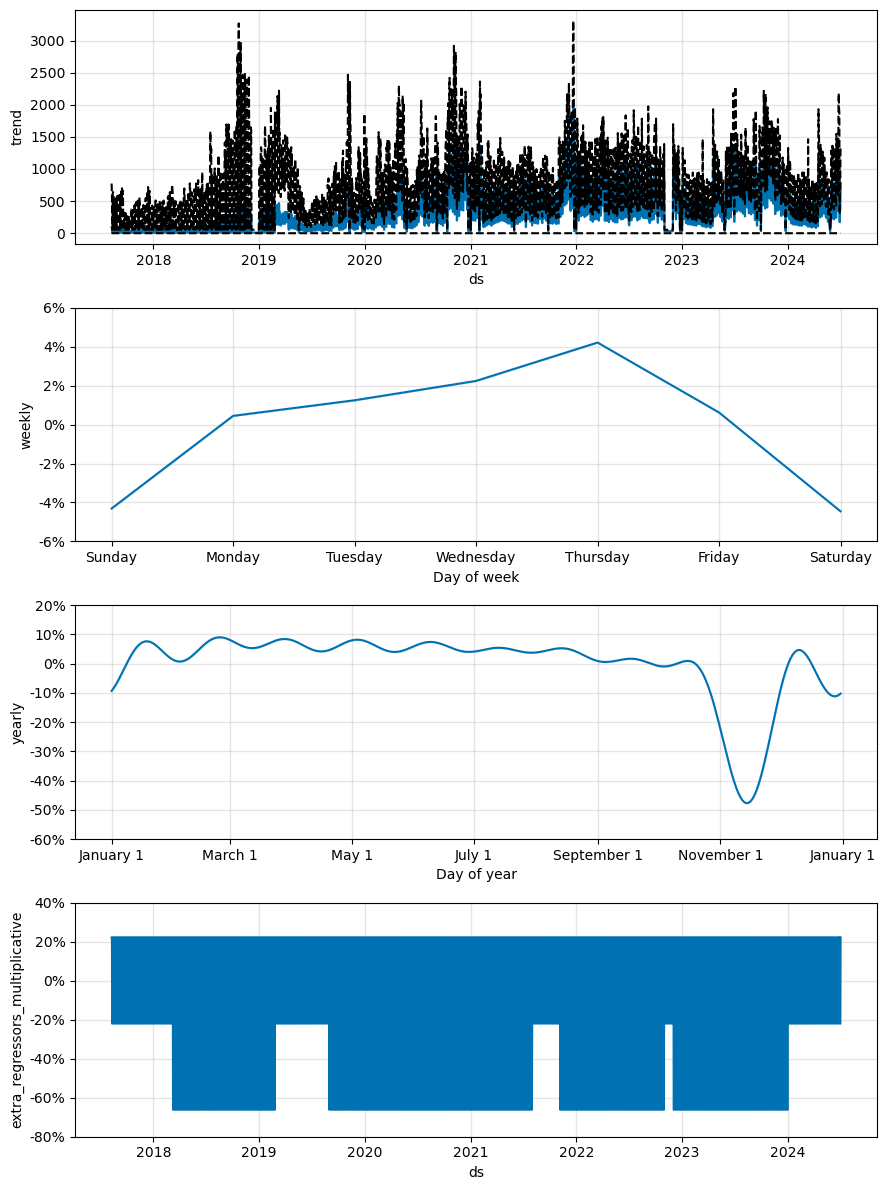

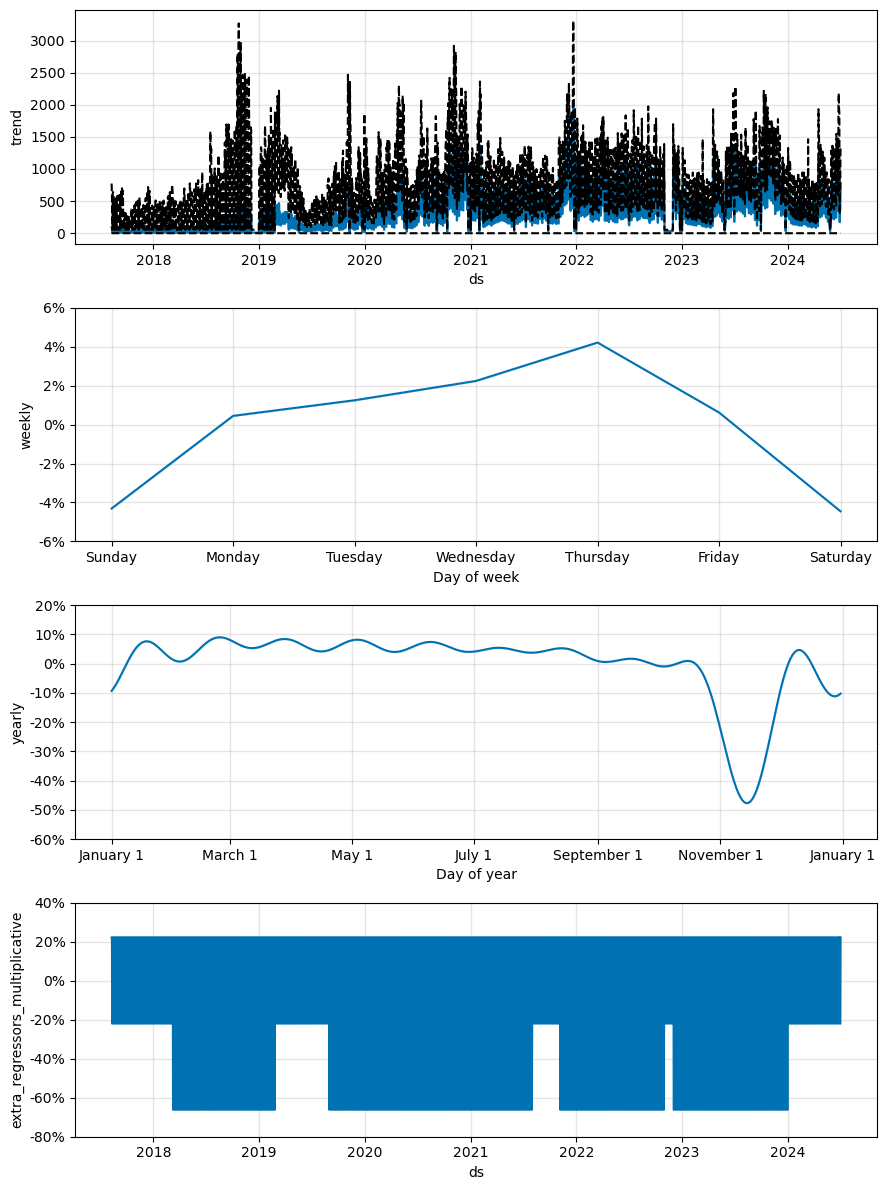

In [73]:
%load_ext autoreload
%autoreload 2

for i in cuts_df.itertuples():
    break

import pickle
from repo.Accuracy import MakeFuture
file_name = "Canada - Brand.pkl"
pickle_file_path = base_path + file_name
pickle_in = open(pickle_file_path,'rb') 
# unpickled model is the model to use, training_dataset is used to get historical spend
unpickled_model, training_dataset, model_df = pickle.load(pickle_in)

analytical_file_copy = analytical_file_df.copy()
market = 'Canada'
account_type = '-'
funnel = 'Brand'

spend_df_for_forecast = analytical_file_copy[(analytical_file_copy['market'] == market) & (analytical_file_copy['account_type'] == account_type) & \
                                             (analytical_file_copy['funnel'] == funnel)].copy()
spend_df_for_forecast['ds'] = pd.to_datetime(spend_df_for_forecast.ds)

future = MakeFuture(unpickled_model, training_dataset, i, 183, spend_df_for_forecast)
print(future.ds.max())
forecast = unpickled_model.predict(future)
unpickled_model.plot_components(forecast)

# from prophet.plot import plot_plotly, plot_components_plotly

# plot_plotly(unpickled_model, forecast)

In [74]:
i

Pandas(Index=0, market='Canada', account_type='-', funnel='Brand', changepoint_prior_scale=0.5, seasonality_prior_scale=0.01, holidays_prior_scale=1.0, seasonality_mode='multiplicative', input_mode='na', weekday_or_weekend='multiplicative', include_holiday='na', covid_year_exclude='na', covid_year_dummy='na', anomaly_2021='na', generic_cost_split='na', competitor_cost_split='na', new_confirmed='na', power='na', growth='logistic', periods=366.0, periods_for_acc_cal=183, cutoff_month=Timestamp('2024-01-01 00:00:00'))